## Proyecto EDA - Accidentalidad de Madrid

Este EDA va sobre la accidental de la cuidad de Madrid en los años 2020, 2021, 2022, 2023, 2024 y 2025. Los Dataset han diso descargados de la web del Ayuntamiento de Madrid. URL: https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=7c2843010d9c3610VgnVCM2000001f4a900aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default

- Librerias importantes que necesitamos en el EDA:

In [66]:
import pandas as pd
import os
import glob
import numpy as np
pd.options.mode.copy_on_write=True
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from pathlib import Path
import unicodedata
from matplotlib.patches import Rectangle
import re
import contextily as ctx
import geopandas as gpd

- Primero vamos hacer una exploracion de las varibales que tenemos.
- Explorando el Dataset nos damos cuenta que hay varios numeros de expedientes iguales y la conclusion es que hay un num expediente por persona implicada en el accidente y es importante entender esto porque puede afectar al calculo de numero de accidentes, ademas que si hay varias personas implicadas en el acidente puede ser que haya personas que salgan leves, graves,etc

1. EDA Temporal
- Distribución de accidentes por día, mes, día de la semana
- Accidentes por franja horaria
- Identificar horas pico
- Accidentes en madrugada, mañana, tarde y noche
- Evolución diaria:
- ¿A qué horas ocurren más accidentes?
- ¿Hay patrones nocturnos asociados a alcohol?
- ¿Hay días con más siniestros?
2. EDA Geográfico
- Mapa de calor de accidentes (heatmap)
- Accidentes por distrito
- Puntos negros (localizaciones repetidas)
- Comparación entre distritos
Preguntas:
- ¿Qué distritos concentran más accidentes?
- ¿Qué intersecciones aparecen repetidas?
3. EDA por Tipo de Accidente
Qué puedes analizar
- Frecuencia de cada tipo de accidente
- Relación entre clima y tipo de accidente
- Accidentes en días despejados vs lluvia
- ¿Qué tipo de accidente es más común?
- ¿Influye el clima en la severidad?
4. EDA por Vehículos y Personas
Qué puedes analizar
- Vehículos más involucrados
- Distribución por edad
- Distribución por sexo
- Conductores vs pasajeros vs peatones
- Accidentes de motos vs coches
Preguntas:
- ¿Qué vehículos tienen más siniestros?
- ¿Qué grupos de edad aparecen más?
- ¿Hay diferencias entre hombres y mujeres?
5. EDA de Lesividad (muy importante)
- Severidad de los accidentes
- Relación entre tipo de accidente y lesividad
- Relación entre tipo de vehículo y lesividad
- Lesividad por edad y sexo
Preguntas:
- ¿Qué tipo de accidente genera más heridos graves?
- ¿Qué edades presentan mayor lesividad?
6. EDA de Alcohol
- Accidentes con alcohol
- Relación con hora del día
- Relación con tipo de accidente
- Relación con edad
Preguntas:
- ¿A qué horas aparecen más positivos?
- ¿Qué tipo de accidente está más asociado a alcohol?




## Exploracion Inicial

Este Dataset es administrativo no estadistico, lo cual quiere decir que cada columna tiene un significado legal o procedimental, aqui un nulo no es un error, sino un estado administrativo, no puedes inventar datos porque alteras la realidad del registro.

La exploracion incial sirve para entender la estructura del Dataset antes de analizar cada variable, aqui no se tranfroma nada solo se observa.

## 2024

- Primero cargamos el dataset de acccidentalidad de madrid del año 2024:

In [2]:
df_accidentes_2024 = pd.read_csv(
    "../src/data/2024_Accidentalidad.csv",
    sep=";",
    skip_blank_lines=True,
    on_bad_lines="skip",
    encoding="utf-8"
)

Ahora tambien quiero ver sus dimensiones, es decir cuantas filas y columnas tiene el Dataset

In [3]:
df_accidentes_2024.shape

(49340, 19)

- Aqui observamos que tenemos 19 columnas y 49340 filas.

Aqui vamos a observar si tenemos duplicados en el Dataset:

In [4]:
df_accidentes_2024[df_accidentes_2024.duplicated(keep=False)]

num_expediente       fecha      hora  \
11       2024S000001  01/01/2024   1:20:00   
12       2024S000001  01/01/2024   1:20:00   
21       2024S000002  01/01/2024   2:45:00   
22       2024S000002  01/01/2024   2:45:00   
23       2024S000002  01/01/2024   2:45:00   
...              ...         ...       ...   
49305    2024S035448  31/12/2024  22:32:00   
49306    2024S035448  31/12/2024  22:32:00   
49312    2024S035451  31/12/2024  22:25:00   
49313    2024S035451  31/12/2024  22:25:00   
49314    2024S035451  31/12/2024  22:25:00   

                                  localizacion  numero  cod_distrito  \
11                         AUTOV. M-30, 08NL00  08NL00             3   
12                         AUTOV. M-30, 08NL00  08NL00             3   
21                       CALL. PUERTO ALTO, 48      48            13   
22                       CALL. PUERTO ALTO, 48      48            13   
23                       CALL. PUERTO ALTO, 48      48            13   
...                                        ...     ...           ...   
49305  CALL. FELIPE HERRANZ / CALL. MAR CASPIO       2            16   
49306  CALL. FELIPE HERRANZ / CALL. MAR CASPIO       2            16   
49312                         CALL. AZAGRA, 12      12            16   
49313                         CALL. AZAGRA, 12      12            16   
49314                         CALL. AZAGRA, 12      12            16   

                 distrito                tipo_accidente estado_meteorológico  \
11                 RETIRO             Colisión múltiple            Despejado   
12                 RETIRO             Colisión múltiple            Despejado   
21     PUENTE DE VALLECAS  Choque contra obstáculo fijo            Despejado   
22     PUENTE DE VALLECAS  Choque contra obstáculo fijo            Despejado   
23     PUENTE DE VALLECAS  Choque contra obstáculo fijo            Despejado   
...                   ...                           ...                  ...   
49305           HORTALEZA  Choque contra obstáculo fijo            Despejado   
49306           HORTALEZA  Choque contra obstáculo fijo            Despejado   
49312           HORTALEZA       Colisión fronto-lateral            Despejado   
49313           HORTALEZA       Colisión fronto-lateral            Despejado   
49314           HORTALEZA       Colisión fronto-lateral            Despejado   

      tipo_vehiculo tipo_persona       rango_edad         sexo  cod_lesividad  \
11          Turismo    Conductor  De 25 a 29 años       Hombre           14.0   
12          Turismo    Conductor  De 25 a 29 años       Hombre           14.0   
21          Turismo    Conductor      Desconocido  Desconocido            NaN   
22          Turismo    Conductor      Desconocido  Desconocido            NaN   
23          Turismo    Conductor      Desconocido  Desconocido            NaN   
...             ...          ...              ...          ...            ...   
49305       Turismo    Conductor      Desconocido  Desconocido            NaN   
49306       Turismo    Conductor      Desconocido  Desconocido            NaN   
49312       Turismo    Conductor      Desconocido  Desconocido            NaN   
49313       Turismo    Conductor      Desconocido  Desconocido            NaN   
49314       Turismo    Conductor      Desconocido  Desconocido            NaN   

                      lesividad  coordenada_x_utm  coordenada_y_utm  \
11     Sin asistencia sanitaria          443927.0         4473998.0   
12     Sin asistencia sanitaria          443927.0         4473998.0   
21                          NaN          443249.0         4471571.0   
22                          NaN          443249.0         4471571.0   
23                          NaN          443249.0         4471571.0   
...                         ...               ...               ...   
49305                       NaN          445054.0         4480563.0   
49306                       NaN          445054.0         4480563.0   
49312          

In [5]:
df_duplicados_de_todos_los_campos = df_accidentes_2024[df_accidentes_2024.duplicated(keep=False)]
df_duplicados_de_todos_los_campos.shape

(3592, 19)

In [6]:
df_sin_duplicados = df_accidentes_2024.drop_duplicates(keep="first")
df_sin_duplicados.shape

(47287, 19)

En el proceso de depuración del dataset de accidentalidad 2024 se han eliminado exclusivamente las filas duplicadas completas, es decir, aquellas que presentan exactamente los mismos valores en todas las columnas disponibles. Esta decisión se fundamenta en la estructura del propio dataset: cada fila representa a una persona implicada en un accidente, y la única forma que tiene el modelo de datos de diferenciar a dos personas distintas es mediante diferencias en alguna de las variables registradas (tipo de persona, tipo de vehículo, rango de edad, sexo, lesividad, coordenadas, etc.).

Cuando dos filas son idénticas en absolutamente todas las columnas, el dataset no contiene ninguna evidencia que permita interpretarlas como dos personas distintas, dos vehículos distintos o dos implicados diferentes dentro del mismo accidente. Por tanto, estas duplicaciones no representan información adicional, sino un error administrativo de registro o de carga.

Este criterio se aplica incluso en los casos en los que las variables ‘sexo’ y ‘rango_edad’ aparecen como ‘Desconocido’. La ausencia de información en estas columnas no aporta capacidad discriminativa adicional: si dos filas coinciden en todas las variables observadas, incluyendo las que sí contienen información, el dataset sigue sin ofrecer ningún elemento que permita distinguirlas como individuos diferentes. Mantener estas duplicaciones inflaría artificialmente el número de implicados, vehículos y lesiones, distorsionando los análisis posteriores.

Por tanto, la eliminación de duplicados completos —incluidos aquellos con sexo y rango de edad desconocidos— garantiza la coherencia interna del dataset y evita la sobreestimación de implicados sin riesgo de eliminar información real, dado que el modelo de datos no permite interpretar estas filas como entidades distintas.

Ahora para el formato real de los datos y detectar valores a simple vista

In [7]:
df_sin_duplicados.head()

num_expediente       fecha      hora  \
0    2023S040280  04/01/2024  14:09:00   
1    2023S040280  04/01/2024  14:09:00   
2    2023S040309  15/02/2024  14:05:00   
3    2023S040309  15/02/2024  14:05:00   
4    2023S040310  18/02/2024  10:40:00   

                               localizacion numero  cod_distrito   distrito  \
0  AVDA. NICETO ALCALA ZAMORA / AUTOV. M-11      3            16  HORTALEZA   
1  AVDA. NICETO ALCALA ZAMORA / AUTOV. M-11      3            16  HORTALEZA   
2                CALL. TESORO / CALL. MINAS     18             1     CENTRO   
3                CALL. TESORO / CALL. MINAS     18             1     CENTRO   
4    GTA. RUIZ JIMENEZ / CALL. SAN BERNARDO      3             7   CHAMBERÍ   

            tipo_accidente estado_meteorológico            tipo_vehiculo  \
0  Colisión fronto-lateral         Lluvia débil      Motocicleta > 125cc   
1  Colisión fronto-lateral         Lluvia débil                  Turismo   
2  Colisión fronto-lateral         Lluvia débil                Bicicleta   
3  Colisión fronto-lateral         Lluvia débil  Motocicleta hasta 125cc   
4         Colisión lateral            Despejado                  Turismo   

  tipo_persona       rango_edad    sexo  cod_lesividad  \
0    Conductor  De 55 a 59 años  Hombre            2.0   
1    Conductor  De 55 a 59 años   Mujer           14.0   
2    Conductor  De 25 a 29 años  Hombre            7.0   
3    Conductor  De 35 a 39 años  Hombre           14.0   
4    Conductor  De 25 a 29 años  Hombre            NaN   

                                           lesividad  coordenada_x_utm  \
0                Ingreso inferior o igual a 24 horas          444913.0   
1                           Sin asistencia sanitaria          444913.0   
2  Asistencia sanitaria sólo en el lugar del acci...          440123.0   
3                           Sin asistencia sanitaria          440123.0   
4                                                NaN          440137.0   

   coordenada_y_utm positiva_alcohol  positiva_droga  
0         4481427.0                N             NaN  
1         4481427.0                N             NaN  
2         4475170.0                N             NaN  
3         4475170.0                N             NaN  
4         4475721.0                N             NaN

Ahora para saber si cada columna esta en el tipo correcto y dectar problemas como por ejemplo numeros como textos, fechas mal cargadas, booleanos como strings,etc.

In [8]:
df_sin_duplicados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47287 entries, 0 to 49339
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   num_expediente        47287 non-null  object 
 1   fecha                 47287 non-null  object 
 2   hora                  47287 non-null  object 
 3   localizacion          47287 non-null  object 
 4   numero                47287 non-null  object 
 5   cod_distrito          47287 non-null  int64  
 6   distrito              47287 non-null  object 
 7   tipo_accidente        47282 non-null  object 
 8   estado_meteorológico  41708 non-null  object 
 9   tipo_vehiculo         46898 non-null  object 
 10  tipo_persona          47287 non-null  object 
 11  rango_edad            47287 non-null  object 
 12  sexo                  47287 non-null  object 
 13  cod_lesividad         26954 non-null  float64
 14  lesividad             26954 non-null  object 
 15  coordenada_x_utm      47

Aqui procedemos hacer una copia del dataset para dejar el original tal cual y poder ver diferencias a la hora de limpiar y demas.

In [9]:
df_accidentes_2024_copy=df_sin_duplicados.copy()

Vamos a generar una tabla para ver los nulos y la cardinalidad de las diferentes variables que nos ayudaran a tomar decisiones con cada variable.
- La cardinalidad de las diferentes variables para decidir cuales son categoricas o no. Se calcula de la siguiente manera: 
$$Cardinalidad(<Columna/Característica>) = \dfrac{NúmerodeValoresUnicos(<Columna/Característica>)}{NúmeroTotalDeRegistros}* 100\%$$

In [10]:
# Número de nulos 
nulos = df_accidentes_2024_copy.isna().sum() 
# Porcentaje de nulos 
nulos_pct = (nulos / len(df_accidentes_2024_copy) * 100).round(2) 
# Cardinalidad 
card = df_accidentes_2024_copy.nunique() 
# Porcentaje de cardinalidad 
card_pct = (card / len(df_accidentes_2024_copy) * 100).round(2) 
# Tipo de dato 
tipos = df_accidentes_2024_copy.dtypes 
#Construcción de la tabla 
tabla_eda = pd.DataFrame({ 
    "nulos": nulos,
    "% nulos": nulos_pct,
    "cardinalidad": card, 
    "% cardinalidad": card_pct,
    "tipo": tipos }) 
# Ordenar por cardinalidad (o por nulos si prefieres) 
tabla_eda = tabla_eda.sort_values("cardinalidad", ascending=False) 
tabla_eda

nulos  % nulos  cardinalidad  % cardinalidad     tipo
num_expediente            0     0.00         20698           43.77   object
localizacion              0     0.00         15131           32.00   object
coordenada_y_utm          6     0.01         10997           23.26  float64
coordenada_x_utm          6     0.01         10131           21.42  float64
numero                    0     0.00          1759            3.72   object
hora                      0     0.00          1256            2.66   object
fecha                     0     0.00           366            0.77   object
tipo_vehiculo           389     0.82            32            0.07   object
cod_distrito              0     0.00            21            0.04    int64
distrito                  0     0.00            21            0.04   object
rango_edad                0     0.00            18            0.04   object
tipo_accidente            5     0.01            12            0.03   object
cod_lesividad         20333    43.00             9            0.02  float64
lesividad             20333    43.00             9            0.02   object
estado_meteorológico   5579    11.80             7            0.01   object
tipo_persona              0     0.00             3            0.01   object
sexo                      0     0.00             3            0.01   object
positiva_alcohol        167     0.35             2            0.00   object
positiva_droga        47084    99.57             1            0.00  float64

-Calculo la caridnalidad de la varibale antes de tratar los nulos porque sino estaria alternando artificalmente la cardinalidad de las variables.

-A partir de aqui tomo decisiones para modificar las variables al tipo que creemos mas acertado.

| Variable          | Tipo original | Tipo final             | Descripción                        | Importancia | Notas | 
|-------------------|---------------|------------------------|------------------------------------|-------------|-------| 
|num_expediente     | object        | string                 | Identificador único del expediente | Baja        | Cardinalidad muy alta, no se analiza, solo ID. | 
|fecha | object | datetime | Fecha del accidente | Alta | Necesaria para análisis temporal. | 
| hora | object | datetime.time | Hora del accidente | Alta | Pandas no tiene dtype específico; se mantiene como time. | 
| fecha_hora | derivada | datetime | Combinación de fecha y hora | Alta | Útil para análisis temporal preciso. | 
| localizacion | object | string | Dirección o punto exacto del accidente | Media | Cardinalidad muy alta; no convertir a category. | 
| numero | object | string | Número de la vía | Baja | No es numérico real, parte de la dirección. | 
| cod_distrito | int64 | category | Código numérico del distrito | Media | Categórica nominal; cardinalidad baja. | 
| distrito | object | category | Nombre del distrito | Alta | Variable clave para análisis espacial. | 
| tipo_accidente | object | category | Tipo de accidente | Alta | Cardinalidad baja; categórica nominal. | 
| estado_meteorológico | object | category | Condición meteorológica | Media | Imputada con 'No consta', categórica nominal. | 
| tipo_vehiculo | object | category | Tipo de vehículo implicado | Alta | Cardinalidad media, categórica nominal. | 
| tipo_persona | object | category | Rol de la persona (conductor, peatón...) | Alta | Categórica nominal. | 
| rango_edad | object | category (ordinal) | Rango de edad | Alta | Tiene orden natural, convertir a ordinal. | 
| sexo | object | category | Sexo de la persona | Media | Categórica nominal. | 
| cod_lesividad | float64 | category (ordinal) | Código de gravedad | Alta | Representa niveles de gravedad, imputado. | 
| lesividad | object | category (ordinal) | Gravedad del accidente | Alta | Variable clave, orden natural. | 
| coordenada_x_utm | float64 | float64 | Coordenada UTM X | Alta | Numérica continua, útil para mapas. | 
| coordenada_y_utm | float64 | float64 | Coordenada UTM Y | Alta | Numérica continua, útil para mapas. | 
| positiva_alcohol | object | category | Resultado alcohol | Media | Binaria + 'No consta'. | 
| positiva_droga | int64 | category | Resultado drogas | Baja | Cardinalidad 1 → variable inútil, se puede eliminar. |

In [10]:
df_accidentes_2024_copy["fecha"] = pd.to_datetime(df_accidentes_2024_copy["fecha"], errors="coerce", dayfirst=True) 
df_accidentes_2024_copy["hora"] = pd.to_datetime(df_accidentes_2024_copy["hora"], format="%H:%M:%S", errors="coerce").dt.time 
df_accidentes_2024_copy["fecha_hora"] = df_accidentes_2024_copy.apply( 
                            lambda row: pd.Timestamp.combine(row["fecha"], row["hora"])
                            if pd.notnull(row["fecha"]) and pd.notnull(row["hora"])
                            else pd.NaT,
                            axis=1 )

cols_string = ["num_expediente", "localizacion", "numero"] 
for col in cols_string: 
    df_accidentes_2024_copy[col] = df_accidentes_2024_copy[col].astype(str).str.lower().str.strip().str.replace(r"\s+", " ", regex=True)
    

- Procedemos a eliminar la columna fecha y hora ya que tenemos una columna nueva creada llamada fecha_hora de tipo datatime por lo que no las necesitamos ya.

In [11]:
df_accidentes_2024_copy = df_accidentes_2024_copy.drop(columns=['fecha', 'hora'], errors='ignore')


- Ahora vamos a tratar los nulos 

In [12]:
# 1. ESTADO METEOROLÓGICO
df_accidentes_2024_copy['estado_meteorológico'] = (
    df_accidentes_2024_copy['estado_meteorológico'].fillna('Se desconoce')
)

# 2. TIPO VEHÍCULO
mask_no_aplica = df_accidentes_2024_copy['tipo_persona'].str.lower().isin(['peatón'])

# Peatón y testigo → No aplica
df_accidentes_2024_copy.loc[
    mask_no_aplica & df_accidentes_2024_copy['tipo_vehiculo'].isna(),
    'tipo_vehiculo'
] = 'No aplica'

# El resto de nulos → No consta
df_accidentes_2024_copy['tipo_vehiculo'] = (
    df_accidentes_2024_copy['tipo_vehiculo'].fillna('No consta')
)

# 3. LESIVIDAD (ORDINAL)
df_accidentes_2024_copy['cod_lesividad'] = df_accidentes_2024_copy['cod_lesividad'].fillna(14)
df_accidentes_2024_copy['lesividad'] = df_accidentes_2024_copy['lesividad'].fillna('Sin asistencia sanitaria')


# 4. ALCOHOL Y DROGAS
df_accidentes_2024_copy['positiva_alcohol'] = df_accidentes_2024_copy['positiva_alcohol'].fillna('No consta')
df_accidentes_2024_copy['positiva_droga'] = df_accidentes_2024_copy['positiva_droga'].fillna('No consta')

# 5. NÚMERO
df_accidentes_2024_copy['numero'] = df_accidentes_2024_copy['numero'].fillna('No aplica')

# 6. TIPO DE ACCIDENTE
if 'tipo_accidente' in df_accidentes_2024_copy.columns:
    df_accidentes_2024_copy['tipo_accidente'] = (
        df_accidentes_2024_copy['tipo_accidente'].fillna('No consta')
    )
# 7. NUEVA COLUMNA: GRADO DE LESIVIDAD

# Diccionario de mapeo cod_lesividad → grado de lesividad
mapa_grado_lesividad = {
    1: "Leve",
    2: "Leve",
    3: "Grave",
    4: "Fallecido",
    5: "Leve",
    6: "Leve",
    7: "Leve",
    14: "Sin asistencia sanitaria",
    77: "Se desconoce"
}

# Crear nueva columna con el grado de lesividad
df_accidentes_2024_copy['grado_lesividad'] = (
    df_accidentes_2024_copy['cod_lesividad']
    .map(mapa_grado_lesividad)
    .fillna("Se desconoce")   # por si aparece algún código no contemplado
)


# Eliminamos 'positiva_droga' por tener un 99.6% de nulos y no aportar valor analítico
df_accidentes_2024_copy = df_accidentes_2024_copy.drop(columns=["positiva_droga"])

# 8. NORMALIZAR VALORES DE ALCOHOL (S/N → Positivo/Negativo)
mapa_alcohol = {
    "S": "Positivo",
    "N": "Negativo",
    "No consta": "No consta",
}

df_accidentes_2024_copy["positiva_alcohol"] = (
    df_accidentes_2024_copy["positiva_alcohol"]
    .map(mapa_alcohol)
    .fillna("No consta")   # por si aparece algún valor inesperado
)

#Elimino cod_distrito
df_accidentes_2024_copy = df_accidentes_2024_copy.drop(columns=['cod_distrito'],errors='ignore')


In [13]:
#Eliminamos cod_lesividad para no tener dos columnas que indiquen lo mismo
df_accidentes_2024_copy=df_accidentes_2024_copy.drop(columns=["cod_lesividad"])

In [14]:
#Eliminamoc tambien la oclumna lesividad 
df_accidentes_2024_copy = df_accidentes_2024_copy.drop(columns=['lesividad'], errors='ignore')


- Eliminamos la columna drogas porque hay muchisimos nulos y no podemos imputar que los NAN sea a que sea negativa la prueba porque podria ser que no le han hecho la prueba de drogas con lo cual lo mejor es borrarla porque nos da muy poca informacion.

In [15]:
# 6. CONVERTIR A CATEGORY (DESPUÉS DE IMPUTAR) 
cols_category = [ 'estado_meteorológico', 
                 'tipo_vehiculo', 
                 'tipo_persona', 
                 'tipo_accidente', 
                 'distrito',  
                 'rango_edad', 
                 'sexo',   
                 'positiva_alcohol', 
                 'grado_lesividad'
                 ] 
for col in cols_category: 
    df_accidentes_2024_copy[col] = df_accidentes_2024_copy[col].astype('category')

In [16]:
df_accidentes_2024_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47287 entries, 0 to 49339
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   num_expediente        47287 non-null  object        
 1   localizacion          47287 non-null  object        
 2   numero                47287 non-null  object        
 3   distrito              47287 non-null  category      
 4   tipo_accidente        47287 non-null  category      
 5   estado_meteorológico  47287 non-null  category      
 6   tipo_vehiculo         47287 non-null  category      
 7   tipo_persona          47287 non-null  category      
 8   rango_edad            47287 non-null  category      
 9   sexo                  47287 non-null  category      
 10  coordenada_x_utm      47281 non-null  float64       
 11  coordenada_y_utm      47281 non-null  float64       
 12  positiva_alcohol      47287 non-null  category      
 13  fecha_hora           

Aqui vemos que tenemos coordenadas X e Y con nulos por lo que hago un dataframe con ellos y busco su latitud y longitud para luego pasarlos a coordanadas X e Y.

In [17]:
df_nulos_geo = df_accidentes_2024_copy[
    df_accidentes_2024_copy[['coordenada_x_utm', 'coordenada_y_utm']].isna().any(axis=1)
]
df_nulos_geo

num_expediente                                       localizacion  \
43126    2024s031973                                autov. m-30, 22nc40   
45331    2024s033186                                  call. sagasta, 12   
45332    2024s033186                                  call. sagasta, 12   
45370    2024s033213  avda. joaquin garrigues walker / call. esteban...   
46526    2024s033868                                autov. m-30, 04xl65   
47617    2024s034459                              call. los yebenes, 78   

       numero            distrito tipo_accidente estado_meteorológico  \
43126  22nc40     MONCLOA-ARAVACA        Alcance            Despejado   
45331      12              CENTRO          Caída         Se desconoce   
45332      12              CENTRO          Caída         Se desconoce   
45370      15  PUENTE DE VALLECAS      No consta         Se desconoce   
46526  04xl65       CIUDAD LINEAL          Caída            Despejado   
47617      78              LATINA          Caída         Lluvia débil   

                 tipo_vehiculo tipo_persona       rango_edad         sexo  \
43126                  Turismo    Conductor  De 50 a 54 años       Hombre   
45331                Bicicleta    Conductor  De 25 a 29 años        Mujer   
45332                  Turismo    Conductor      Desconocido  Desconocido   
45370                  Turismo    Conductor  De 40 a 44 años       Hombre   
46526                No consta    Conductor  De 25 a 29 años       Hombre   
47617  Motocicleta hasta 125cc    Conductor  De 30 a 34 años        Mujer   

       coordenada_x_utm  coordenada_y_utm positiva_alcohol  \
43126               NaN               NaN         Negativo   
45331               NaN               NaN         Negativo   
45332               NaN               NaN         Negativo   
45370               NaN               NaN         Positivo   
46526               NaN               NaN         Negativo   
47617               NaN               NaN         Negativo   

               fecha_hora           grado_lesividad  
43126 2024-11-21 07:55:00  Sin asistencia sanitaria  
45331 2024-12-04 20:45:00  Sin asistencia sanitaria  
45332 2024-12-04 20:45:00  Sin asistencia sanitaria  
45370 2024-12-05 02:45:00  Sin asistencia sanitaria  
46526 2024-12-12 09:40:00                      Leve  
47617 2024-12-19 10:25:00                      Leve

Aqui como veo las calles con los numeros vamos a buscar en google maps la longitud y la laitud de todas ellas y la trasnformamos esa latitud y longitud en x e y. Calles:

calle sagasta 12, madrid:
- Latitud:40.42861807197678 
- Longitud:-3.700140607183193

calle de los yebenes, 78:
- Latitud: 40.39365616234982, 
- Longitud: -3.7525037200398446

In [19]:
coords = {
    "2024s033186": (440948.3, 4474040.4),  # Sagasta 12
    "2024s034459": (436742.2, 4469836.7)   # Los Yébenes 78
}

for exp, (x, y) in coords.items():
    df_accidentes_2024_copy.loc[
        df_accidentes_2024_copy['num_expediente'] == exp,
        'coordenada_x_utm'
    ] = x

    df_accidentes_2024_copy.loc[
        df_accidentes_2024_copy['num_expediente'] == exp,
        'coordenada_y_utm'
    ] = y

    print(f"Expediente {exp} actualizado → X={x}, Y={y}")

Expediente 2024s033186 actualizado → X=440948.3, Y=4474040.4
Expediente 2024s034459 actualizado → X=436742.2, Y=4469836.7


-Ahora eliminamos las demas que son contradictorias o no podemos encontrar

In [20]:
expedientes_a_eliminar = [
    "2024s031973",
    "2024s033213",
    "2024s033868"
]

df_accidentes_2024_copy = df_accidentes_2024_copy[
    ~df_accidentes_2024_copy["num_expediente"].isin(expedientes_a_eliminar)
].copy()

print("Filas eliminadas:", expedientes_a_eliminar)

Filas eliminadas: ['2024s031973', '2024s033213', '2024s033868']


-Aqui compruebo que el dataset queda ya completamente limpio

In [21]:
df_accidentes_2024_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47284 entries, 0 to 49339
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   num_expediente        47284 non-null  object        
 1   localizacion          47284 non-null  object        
 2   numero                47284 non-null  object        
 3   distrito              47284 non-null  category      
 4   tipo_accidente        47284 non-null  category      
 5   estado_meteorológico  47284 non-null  category      
 6   tipo_vehiculo         47284 non-null  category      
 7   tipo_persona          47284 non-null  category      
 8   rango_edad            47284 non-null  category      
 9   sexo                  47284 non-null  category      
 10  coordenada_x_utm      47284 non-null  float64       
 11  coordenada_y_utm      47284 non-null  float64       
 12  positiva_alcohol      47284 non-null  category      
 13  fecha_hora           

In [22]:
df_accidentes_2024_copy.head()

num_expediente                              localizacion numero   distrito  \
0    2023s040280  avda. niceto alcala zamora / autov. m-11      3  HORTALEZA   
1    2023s040280  avda. niceto alcala zamora / autov. m-11      3  HORTALEZA   
2    2023s040309                call. tesoro / call. minas     18     CENTRO   
3    2023s040309                call. tesoro / call. minas     18     CENTRO   
4    2023s040310    gta. ruiz jimenez / call. san bernardo      3   CHAMBERÍ   

            tipo_accidente estado_meteorológico            tipo_vehiculo  \
0  Colisión fronto-lateral         Lluvia débil      Motocicleta > 125cc   
1  Colisión fronto-lateral         Lluvia débil                  Turismo   
2  Colisión fronto-lateral         Lluvia débil                Bicicleta   
3  Colisión fronto-lateral         Lluvia débil  Motocicleta hasta 125cc   
4         Colisión lateral            Despejado                  Turismo   

  tipo_persona       rango_edad    sexo  coordenada_x_utm  coordenada_y_utm  \
0    Conductor  De 55 a 59 años  Hombre          444913.0         4481427.0   
1    Conductor  De 55 a 59 años   Mujer          444913.0         4481427.0   
2    Conductor  De 25 a 29 años  Hombre          440123.0         4475170.0   
3    Conductor  De 35 a 39 años  Hombre          440123.0         4475170.0   
4    Conductor  De 25 a 29 años  Hombre          440137.0         4475721.0   

  positiva_alcohol          fecha_hora           grado_lesividad  
0         Negativo 2024-01-04 14:09:00                      Leve  
1         Negativo 2024-01-04 14:09:00  Sin asistencia sanitaria  
2         Negativo 2024-02-15 14:05:00                      Leve  
3         Negativo 2024-02-15 14:05:00  Sin asistencia sanitaria  
4         Negativo 2024-02-18 10:40:00  Sin asistencia sanitaria

In [23]:
# Crear columna franja_horaria en el dataset 2024
df_accidentes_2024_copy['franja_horaria'] = pd.cut(
    df_accidentes_2024_copy['fecha_hora'].dt.hour,
    bins=[0, 6, 12, 18, 24],
    labels=['Madrugada', 'Mañana', 'Tarde', 'Noche'],
    right=False
)


In [24]:
df_accidentes_2024_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47284 entries, 0 to 49339
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   num_expediente        47284 non-null  object        
 1   localizacion          47284 non-null  object        
 2   numero                47284 non-null  object        
 3   distrito              47284 non-null  category      
 4   tipo_accidente        47284 non-null  category      
 5   estado_meteorológico  47284 non-null  category      
 6   tipo_vehiculo         47284 non-null  category      
 7   tipo_persona          47284 non-null  category      
 8   rango_edad            47284 non-null  category      
 9   sexo                  47284 non-null  category      
 10  coordenada_x_utm      47284 non-null  float64       
 11  coordenada_y_utm      47284 non-null  float64       
 12  positiva_alcohol      47284 non-null  category      
 13  fecha_hora           

- Creamos un nuevo CSV limpio:

In [25]:
from pathlib import Path

# Ruta correcta desde tu notebook
ruta_salida = Path("../src/data/2024_Accidentalidad_Limpio.parquet")

# Crear carpeta si no existe
ruta_salida.parent.mkdir(parents=True, exist_ok=True)

# Guardar el dataset limpio en formato Parquet 
df_accidentes_2024_copy.to_parquet(
    ruta_salida,
    index=False,
    compression="snappy",
    engine="pyarrow"
)

print("Archivo guardado en:", ruta_salida.resolve())

Archivo guardado en: C:\Users\César\OneDrive\Escritorio\DS\EDA-ACCIDENTALIDAD_MADRID\src\data\2024_Accidentalidad_Limpio.parquet


## Analisis Univariante 2024

#### Analisis univariante temporal. Nuestros objetivos seran los siguientes:

- Accidentes por hora que mostraran picos en horas puntas.
- Accidentes por dia de la semana, nos mostrara los dias de las semana donde habra mas accideentes.
- Accidentes por franja horaria, que nos mostrara donde son mas comunes los accidentes si por la mañana, tarde, noche o madrugada.
- Accidentes globales, nos mostrara los accidentes de cada mes en todo año.
- Accidentes por dia, que detectara los dias en los que hay mas accidentes.

Realizo una copia del dataFrame para el analisis univariante.

In [26]:
df_accidentes_2024_copy_univariante=df_accidentes_2024_copy.copy()

La función preparar_accidentes_unicos() transforma un dataset de personas implicadas en un dataset de accidentes únicos.  
Agrupa por num_expediente, selecciona una fila por accidente, agrega información relevante y genera variables temporales (año, mes, día de la semana, hora y franja horaria).

In [27]:
def preparar_accidentes_unicos(df, col_id='num_expediente'):
    """
    Devuelve un DataFrame con accidentes únicos (agregados por num_expediente),
    usando la columna fecha_hora ya existente.
    """

    # Asegurar que fecha_hora es datetime
    df['fecha_hora'] = pd.to_datetime(df['fecha_hora'], errors='coerce')

    # Agregación por expediente (1 fila = 1 accidente)
    df_unicos = df.groupby(col_id).agg({
        'fecha_hora': 'min',
        'tipo_accidente': 'first',
        'tipo_vehiculo': lambda x: list(x.unique()),
        'distrito': 'first',
        'estado_meteorológico': 'first',
        'rango_edad': 'first',
        'tipo_persona': 'first',
        'sexo': 'first',
        'positiva_alcohol': 'first'
    }).reset_index()

    # Variables temporales derivadas
    df_unicos['año'] = df_unicos['fecha_hora'].dt.year
    df_unicos['mes'] = df_unicos['fecha_hora'].dt.month
    df_unicos['dia_semana'] = df_unicos['fecha_hora'].dt.day_name()
    df_unicos['hora'] = df_unicos['fecha_hora'].dt.hour

    # Añadir franja horaria
    df_unicos['franja_horaria'] = pd.cut(
        df_unicos['hora'],
        bins=[0, 6, 12, 18, 24],
        labels=['Madrugada', 'Mañana', 'Tarde', 'Noche'],
        right=False
    )

    return df_unicos


La funcion plot_temporal_univariante genera todos los gráficos temporales univariantes clave para analizar accidentes:
- Por mes
- Por día de la semana
- Por hora
- Por franja horaria y una curva mensual

In [29]:
def plot_temporal_univariate(df, col_datetime='fecha_hora', por_año=False):
    """
    Gráficos temporales univariantes:
    - Accidentes por mes (barras)
    - Accidentes por día de la semana
    - Accidentes por hora
    - Accidentes por franja horaria
    - Curva mensual ampliada (línea con puntos)
    - Curvas diarias por mes (12 gráficas adicionales)
    """
    if por_año:
        for año, df_año in df.groupby('año'):
            print(f"\n=== Gráficos para el año {año} ===")
            _graficos(df_año, col_datetime, titulo_extra=f"Año {año}")
    else:
        _graficos(df, col_datetime, titulo_extra="Global")


def _graficos(df, col_datetime, titulo_extra=""):

    fig = plt.figure(figsize=(16, 18))

    # 1. Accidentes por mes
    ax_mes = plt.subplot2grid((3, 2), (0, 0))
    freq_mes = df['mes'].value_counts().sort_index()
    freq_mes.plot(kind='bar', ax=ax_mes, color="steelblue",
                  title=f'Accidentes por mes ({titulo_extra})')
    ax_mes.set_ylabel("Número de accidentes")
    for i, v in enumerate(freq_mes.values):
        ax_mes.text(i, v + 5, str(v), ha="center", fontsize=9)

    # 2. Accidentes por día de la semana
    ax_semana = plt.subplot2grid((3, 2), (0, 1))
    freq_semana = df['dia_semana'].value_counts()
    freq_semana.plot(kind='bar', ax=ax_semana, color="darkcyan",
                     title=f'Accidentes por día de la semana ({titulo_extra})')
    ax_semana.set_ylabel("Número de accidentes")
    for i, v in enumerate(freq_semana.values):
        ax_semana.text(i, v + 5, str(v), ha="center", fontsize=9)

    # 3. Accidentes por hora
    ax_hora = plt.subplot2grid((3, 2), (1, 0))
    freq_hora = df['hora'].value_counts().sort_index()
    freq_hora.plot(kind='bar', ax=ax_hora, color="darkorange",
                   title=f'Accidentes por hora ({titulo_extra})')
    ax_hora.set_ylabel("Número de accidentes")
    for i, v in enumerate(freq_hora.values):
        ax_hora.text(i, v + 5, str(v), ha="center", fontsize=8)

    # 4. Accidentes por franja horaria
    ax_franja = plt.subplot2grid((3, 2), (1, 1))
    freq_franja = df['franja_horaria'].value_counts()
    freq_franja.plot(kind='bar', ax=ax_franja, color="mediumseagreen",
                     title=f'Accidentes por franja horaria ({titulo_extra})')
    ax_franja.set_ylabel("Número de accidentes")
    for i, v in enumerate(freq_franja.values):
        ax_franja.text(i, v + 5, str(v), ha="center", fontsize=9)

    # 5. Curva mensual ampliada
    ax_curva = plt.subplot2grid((3, 2), (2, 0), colspan=2)
    frecuencia_mensual = df[col_datetime].dt.month.value_counts().sort_index()

    meses_es = [
        "Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio",
        "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"
    ]
    meses_plot = [meses_es[i-1] for i in frecuencia_mensual.index]

    ax_curva.plot(
        meses_plot, frecuencia_mensual.values,
        marker="o", linewidth=3, color="steelblue"
    )
    ax_curva.set_title(f"Curva de frecuencia mensual ({titulo_extra})", fontsize=18)
    ax_curva.set_xlabel("Mes", fontsize=14)
    ax_curva.set_ylabel("Número de accidentes", fontsize=14)
    ax_curva.grid(True)
    for i, v in enumerate(frecuencia_mensual.values):
        ax_curva.text(i, v + 10, str(v), ha="center", fontsize=14)
    ax_curva.tick_params(axis="x", rotation=45)

    plt.tight_layout()
    plt.show()
    
    # 6. Curvas diarias por mes (12 gráficas adicionales)
    
    for mes in range(1, 12 + 1):
        df_mes = df[df[col_datetime].dt.month == mes]
        if df_mes.empty:
            continue

        freq_dia = df_mes[col_datetime].dt.day.value_counts().sort_index()

        plt.figure(figsize=(10, 4))
        plt.plot(freq_dia.index, freq_dia.values, marker="o", linewidth=2, color="firebrick")
        plt.title(f"Curva diaria – {meses_es[mes-1]} ({titulo_extra})")
        plt.xlabel("Día del mes")
        plt.ylabel("Número de accidentes")
        plt.grid(True)

        for i, v in enumerate(freq_dia.values):
            plt.text(freq_dia.index[i], v + 0.5, str(v), ha="center", fontsize=8)

        plt.tight_layout()
        plt.show()



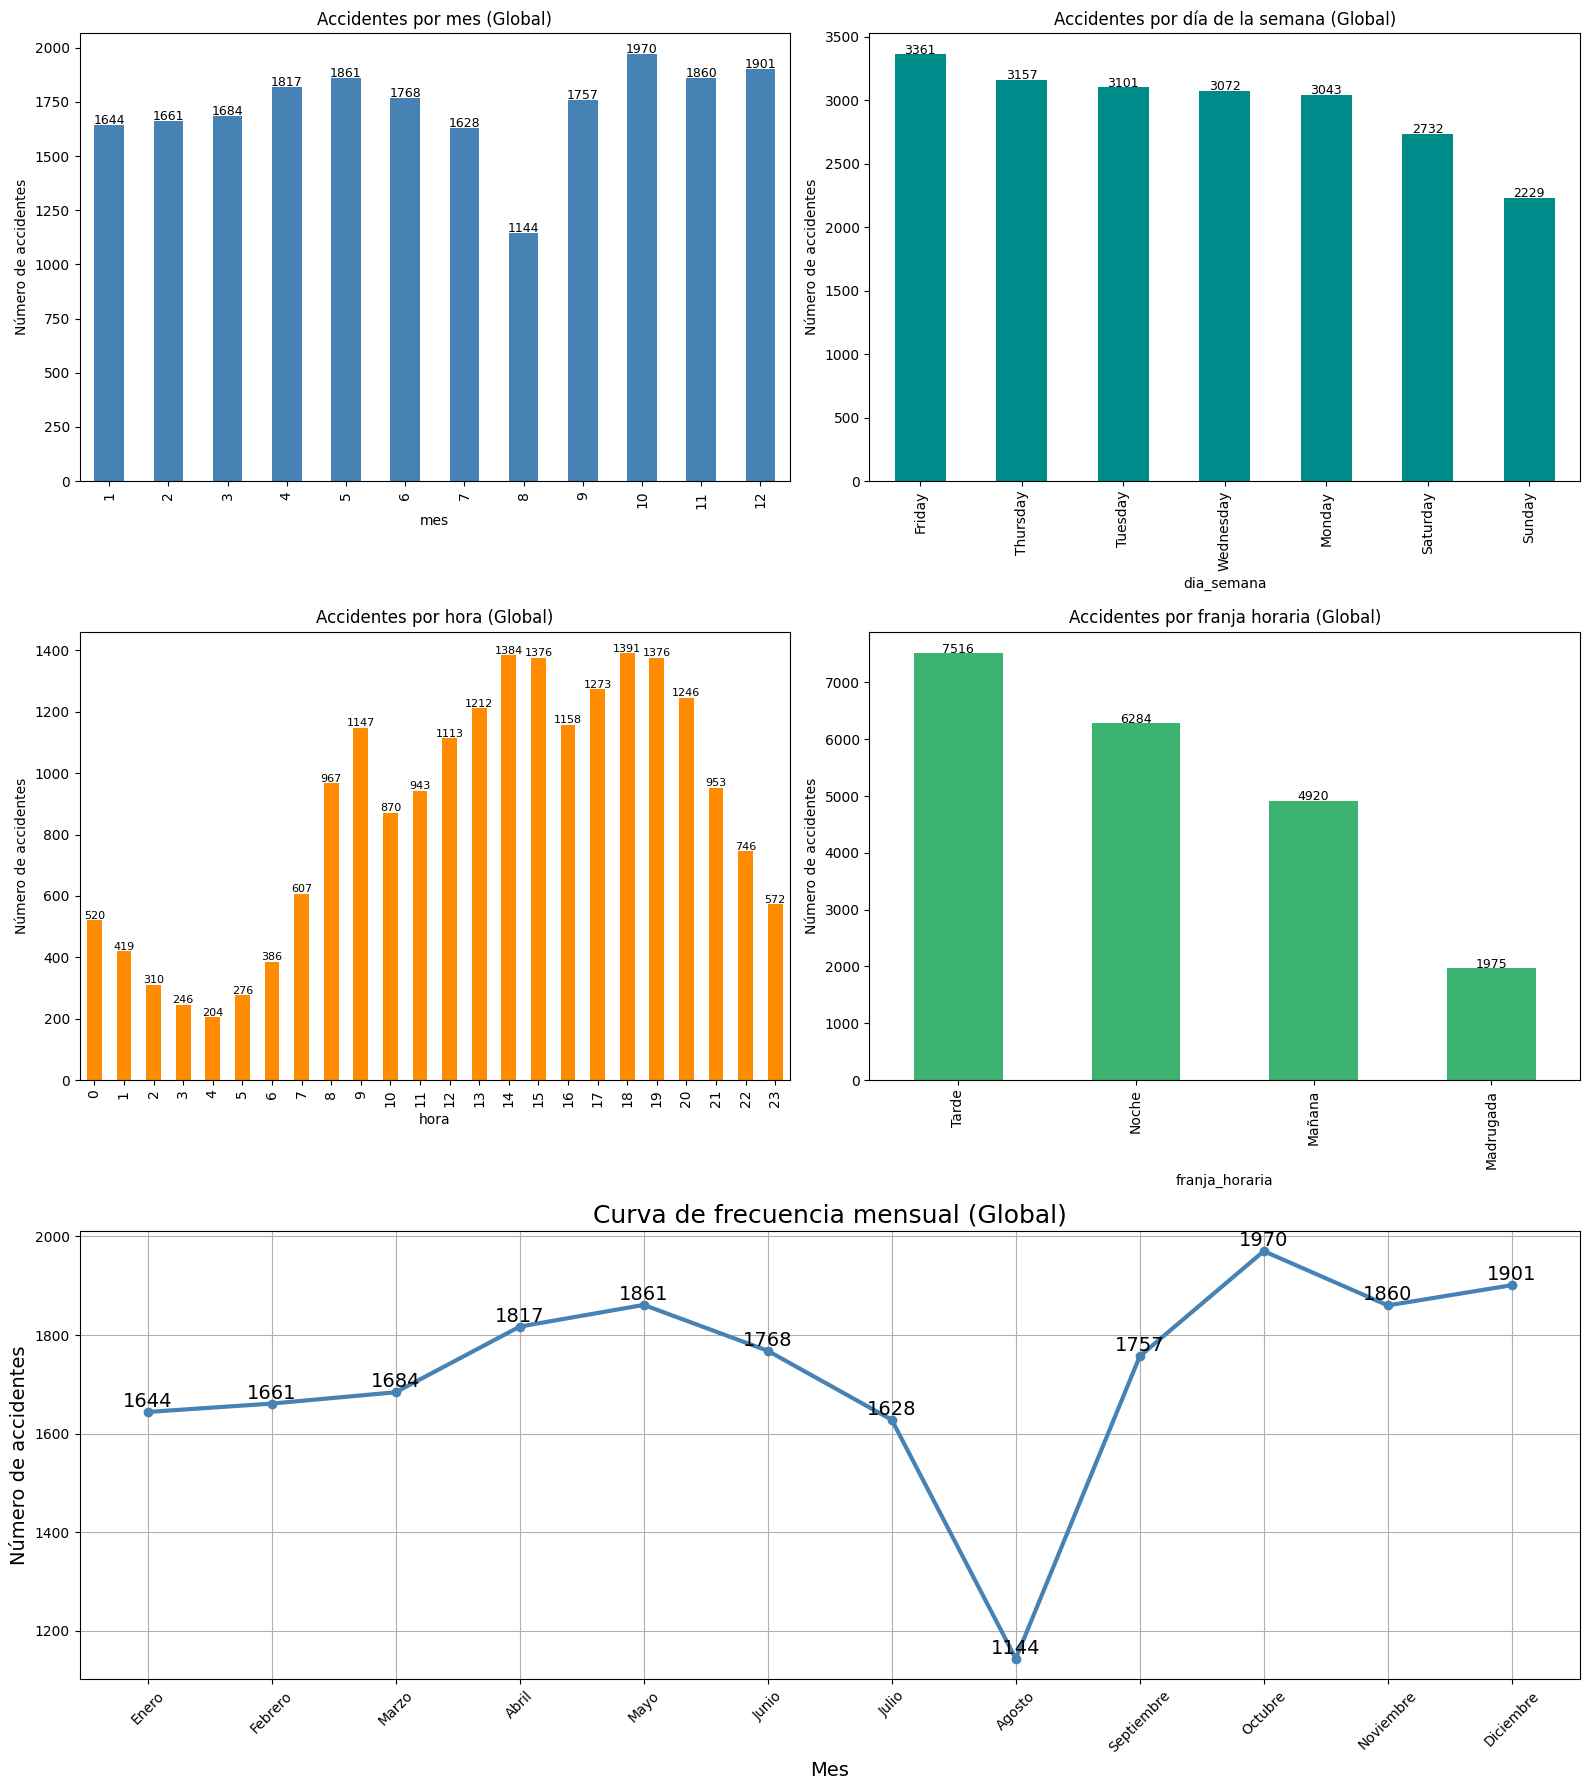

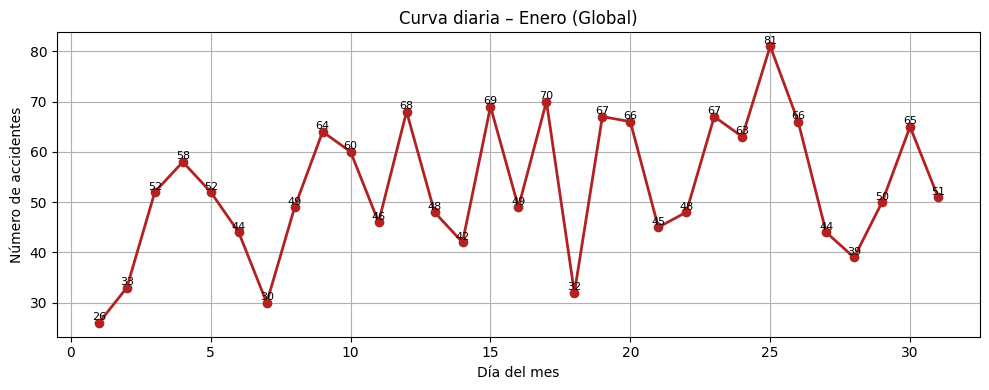

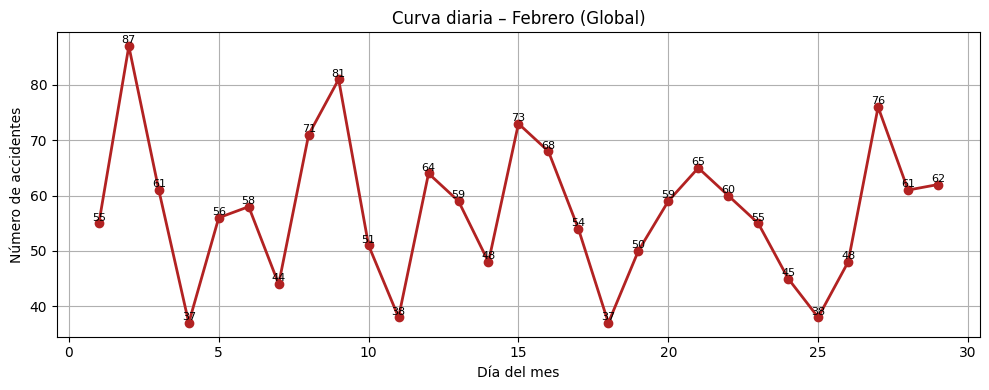

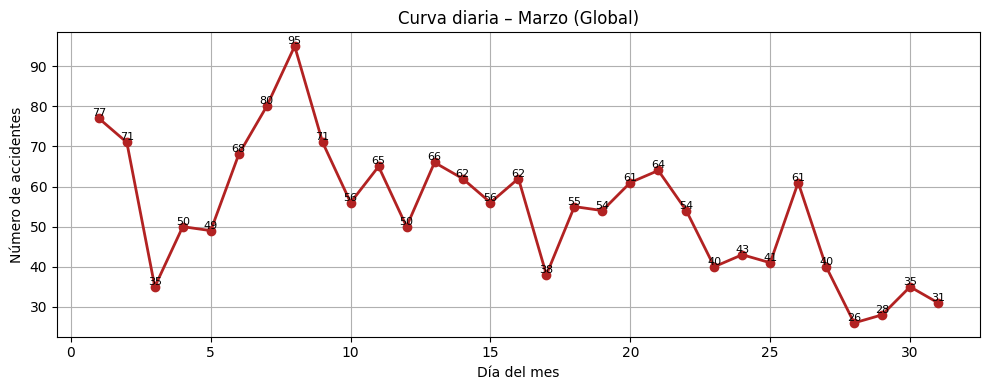

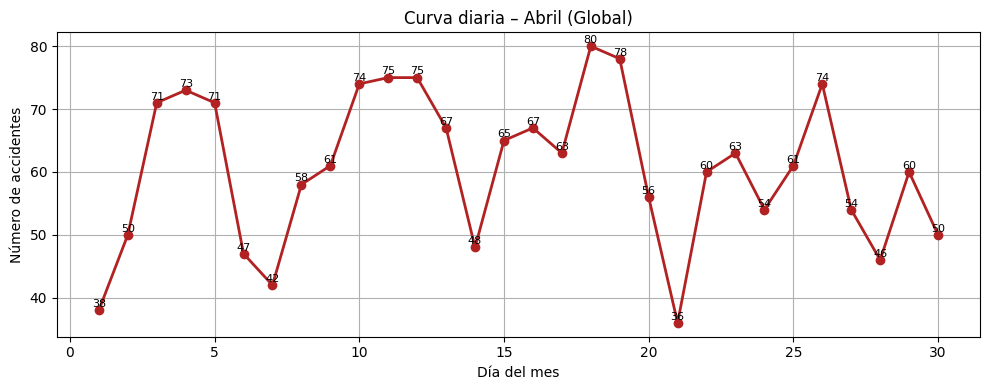

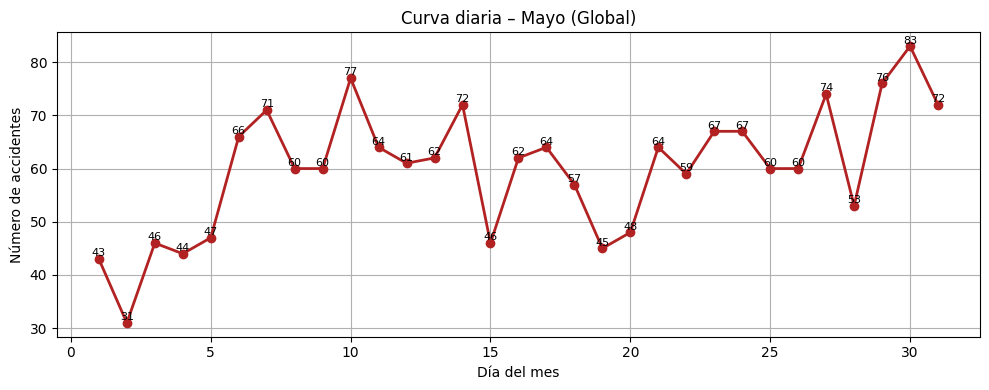

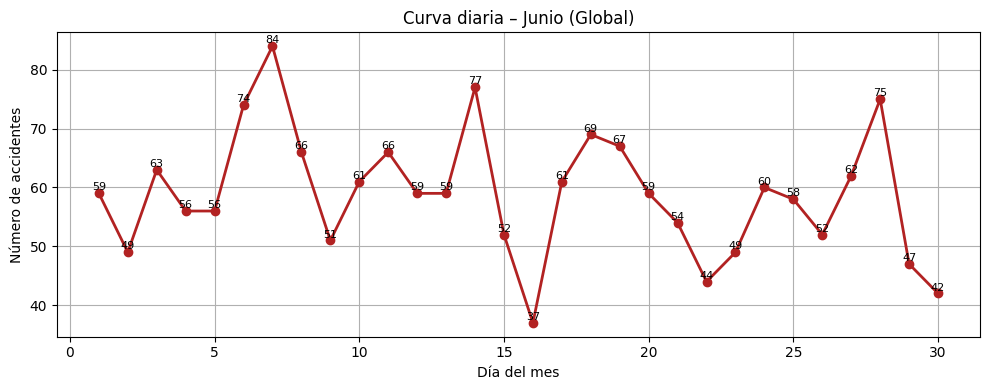

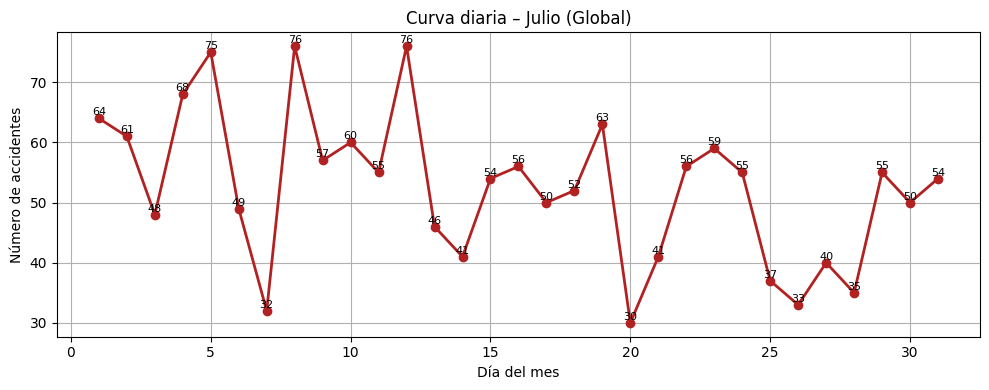

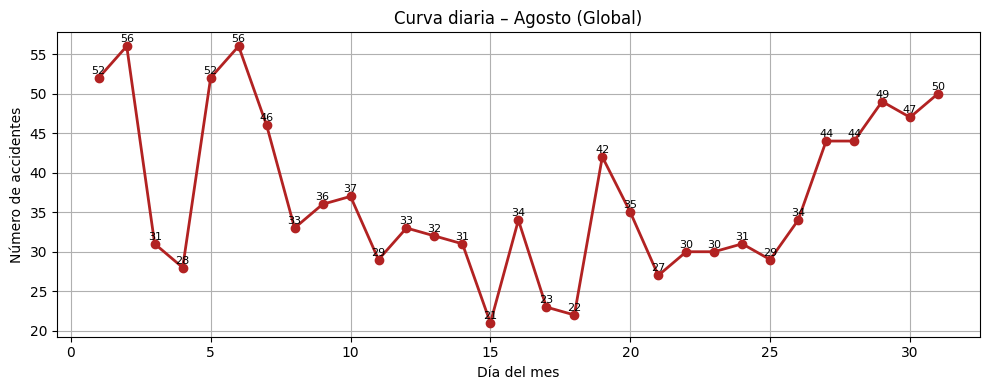

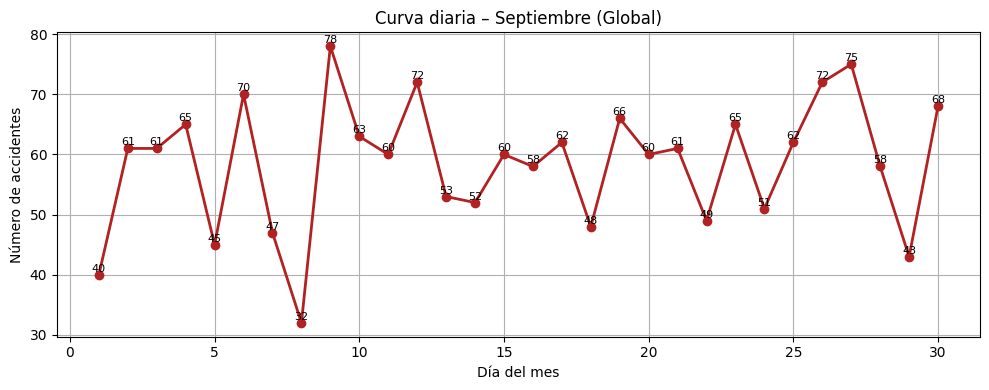

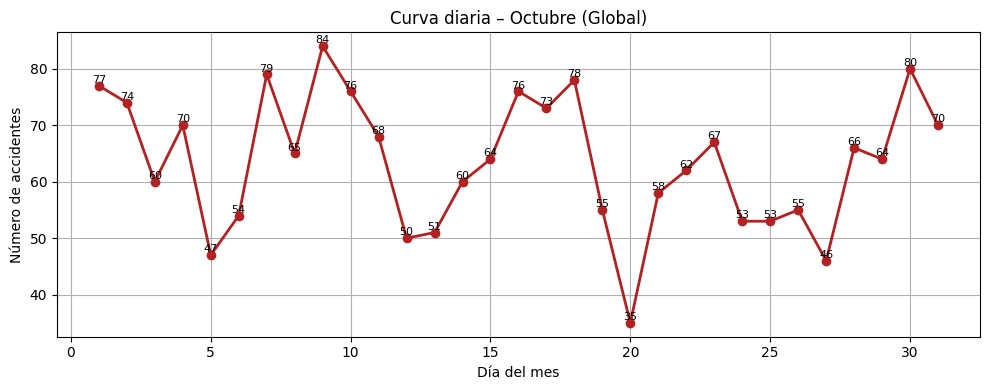

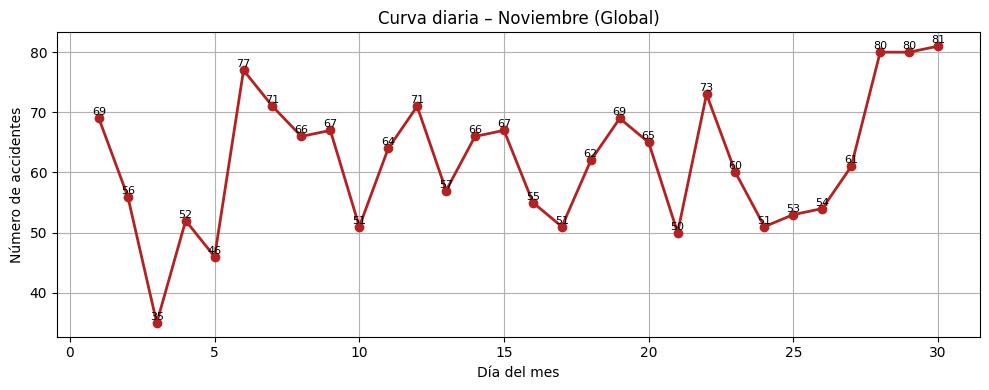

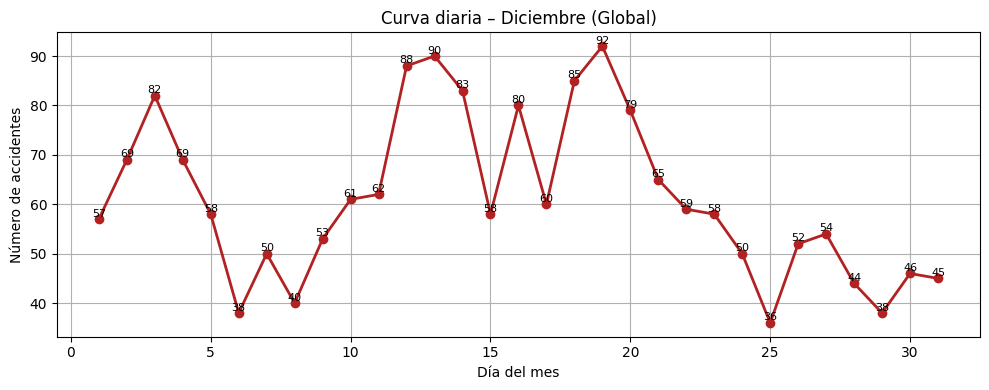

In [30]:
df_unicos = preparar_accidentes_unicos(df_accidentes_2024_copy_univariante)
plot_temporal_univariate(df_unicos)

En la primera grafica de todas de accidentes por mes se puede observar que el top tres de aacidentes por mes son:
- Octubre
- Diciembre
- Mayo
Tambien podemos observar que el mes con menos accidentes es claramente Agosto, esto tiene sentido ya que coincide con un mes muy tipico de vacacciones y madrid reduce mucho su poblacion en ese mes particularmente.

Grafica de accidente por dia de la semana

En esta grafica podemos observar que el dia de la semana con mas accidentes son los viernes.

Grafica de accidentes por hora:

En esta grafica observamos que sobre todo hay dos franjas donde hay mas accidenes que son entre las 14:00 y las 15:00 y las 18:00 y las 19:00.

Grafica de accidentes por fraja horaria:

En esta grafica observamos que cuando hay mas accidentes es por la tarde(Entendiendo la franja horaria de esta forma: madrugada de 24:00 a 6:00, mañana de 6:00 a 12:00, tarde de 12:00 a 18:00 y noche de 18:00 a 24:00)

Grafica de acidentes de frecuencia amensual:

observamos lo mismo que en el diagrama de barras de la primera grafica

##### Enero
Día 1 y 6 → valles claros (festivos)

- Repunte fuerte desde el día 9 → vuelta a la actividad

- Patrón típico post-Reyes

##### Febrero
Sin festivos → curva marcada por fines de semana

- Picos en días laborales (2, 9, 26) → patrón puro de movilidad

##### Marzo
Semana Santa cae en 28–29 marzo → descenso claro desde el 27

Picos antes del 20 → acumulación previa a vacaciones

##### Abril
- Semana Santa ya pasó → curva estable

- Picos en mitad de semana (10–12, 18–19) → actividad laboral normal

##### Mayo
- Día 1, 2 y 15 → tres festivos clave en Madrid

- Valles en esos días, picos justo después (10, 25, 27, 28)

- Patrón de “efecto rebote” tras puentes

##### Junio
- Sin festivos → curva estable

- Picos en jueves/viernes → tráfico laboral

- Inicio de verano escolar → más movilidad

##### Julio
- Descenso progresivo → inicio de vacaciones

- Picos en días laborales (5, 8, 12)

- Valles en fines de semana y segunda mitad

##### Agosto
- 15 agosto → valle claro (festivo nacional)

- Curva baja todo el mes → vacaciones masivas

- Picos aislados (1, 2, 5, 6) → desplazamientos puntuales

##### Septiembre
- Vuelta al cole y trabajo → repunte desde el día 4

- Picos en días laborales (6, 9, 12, 26, 27)

- Patrón de reincorporación

##### Octubre
- Día 12 → valle claro (festivo nacional)

- Picos en semanas completas (9, 16, 18, 30)

- Actividad laboral intensa

##### Noviembre
- Día 1 → valle claro (festivo nacional)

- Picos en segunda mitad (28–30) → acumulación de actividad

- Clima más adverso → más siniestros

##### Diciembre
- Días 6, 8, 25 → valles claros (festivos)

- Picos antes de Navidad (12–14, 18–20)

- Descenso final (29–31) → menos movilidad

#### Analisis univariante Geográfico. Nuestros objetivos seran los siguientes:
- Accidentes por distrito, ¿Que distritos tienen el mayor numero de accidentes?
- Puntos negros (localizaciones repetidas), ¿Donde se situan los puntos negros?

    

C:\Users\César\AppData\Local\Temp\ipykernel_4408\3316720444.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("distrito")["num_expediente"]


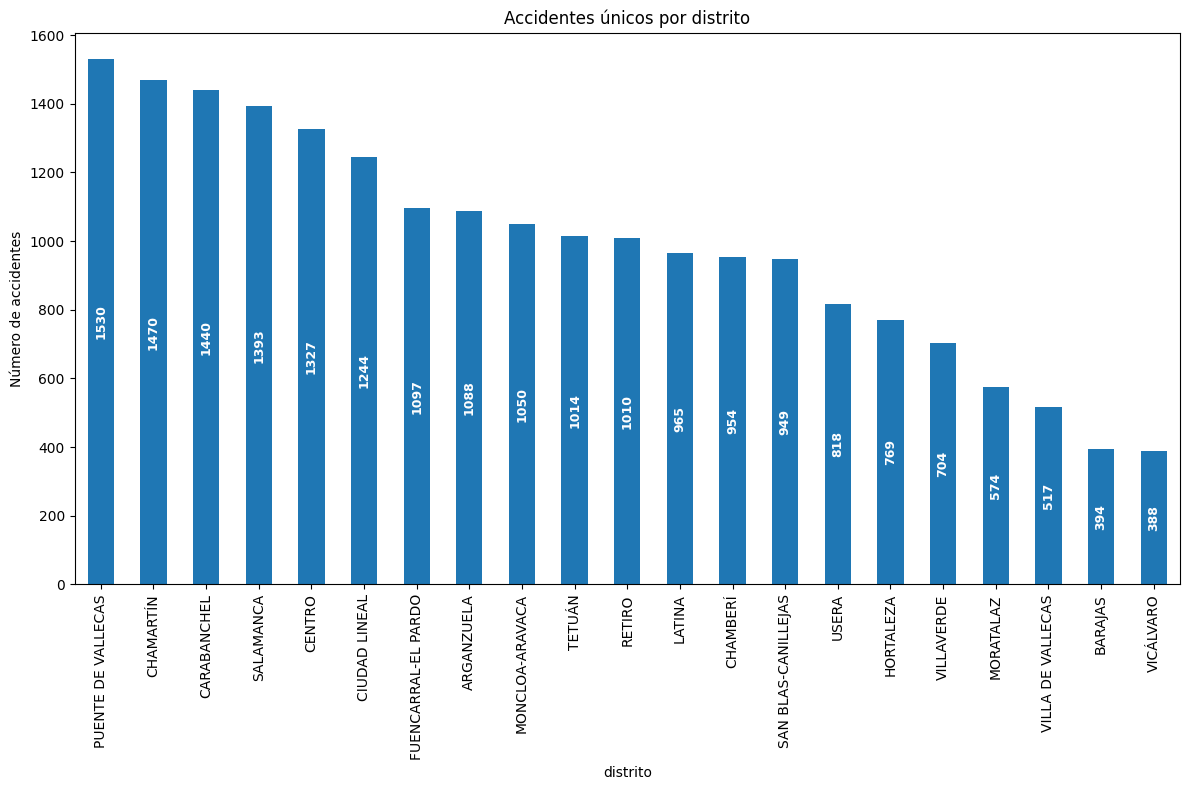

In [31]:
# Calcular accidentes únicos por distrito
accidentes_distrito = (
    df_accidentes_2024_copy_univariante
    .groupby("distrito")["num_expediente"]
    .nunique()
    .sort_values(ascending=False)
)

# Crear gráfico
ax = accidentes_distrito.plot(kind="bar", figsize=(12,8))

plt.title("Accidentes únicos por distrito")
plt.ylabel("Número de accidentes")

# Eje Y con saltos de 200
max_val = accidentes_distrito.max()
plt.yticks(np.arange(0, max_val + 200, 200))

# Añadir el número de accidentes dentro de cada barra, tumbado
for p, value in zip(ax.patches, accidentes_distrito):
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() / 2   # centrado verticalmente dentro de la barra

    ax.annotate(
        f"{value}",
        (x, y),
        ha="center", va="center",
        rotation=90,          #  texto tumbado
        fontsize=9, color="white", fontweight="bold"
    )

plt.tight_layout()
plt.show()


C:\Users\César\AppData\Local\Temp\ipykernel_4408\3320590713.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("distrito")["num_expediente"]


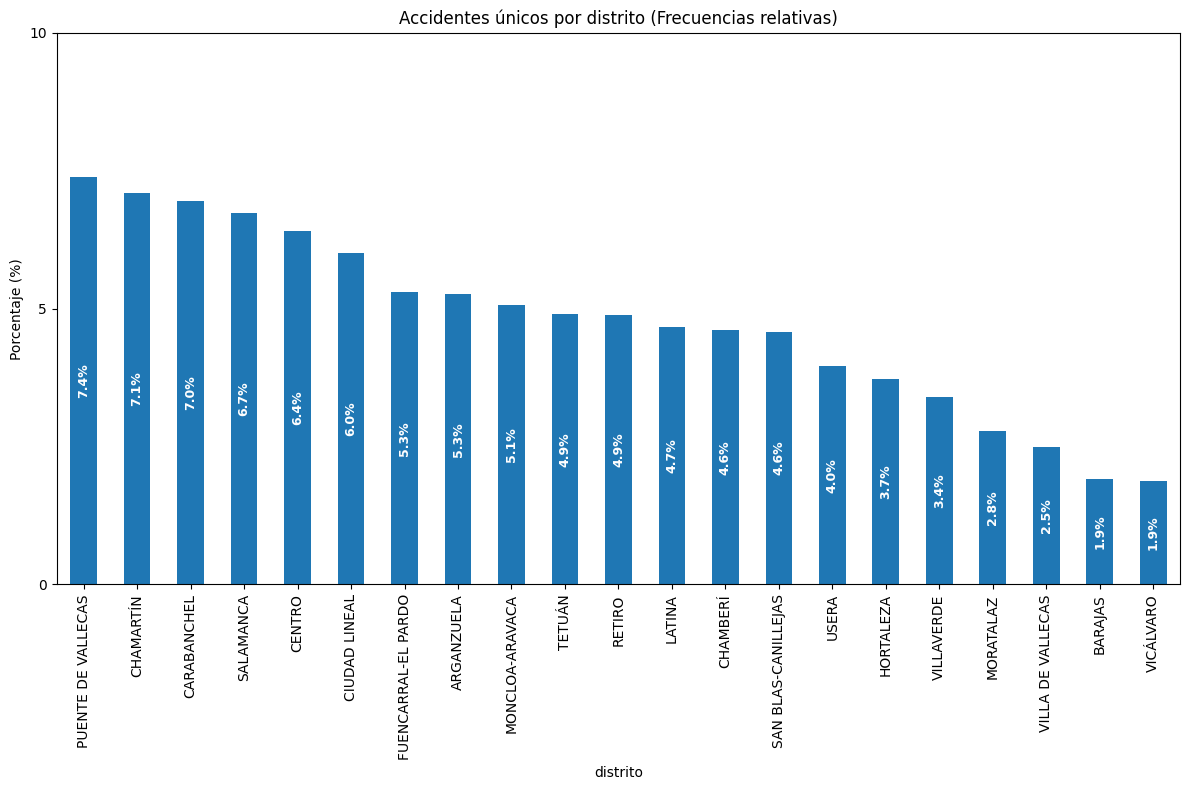

In [32]:
# Calcular accidentes únicos por distrito (absolutos)
accidentes_distrito = (
    df_accidentes_2024_copy_univariante
    .groupby("distrito")["num_expediente"]
    .nunique()
    .sort_values(ascending=False)
)

# Convertir a frecuencias relativas (%)
accidentes_rel = accidentes_distrito / accidentes_distrito.sum() * 100

# Crear gráfico
ax = accidentes_rel.plot(kind="bar", figsize=(12,8))

plt.title("Accidentes únicos por distrito (Frecuencias relativas)")
plt.ylabel("Porcentaje (%)")

# Eje Y con saltos de 5%
max_val = accidentes_rel.max()
plt.yticks(np.arange(0, max_val + 5, 5))

# Añadir el porcentaje dentro de cada barra, tumbado
for p, value in zip(ax.patches, accidentes_rel):
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() / 2   # centrado verticalmente dentro de la barra

    ax.annotate(
        f"{value:.1f}%",      # porcentaje con 1 decimal
        (x, y),
        ha="center", va="center",
        rotation=90,
        fontsize=9, color="white", fontweight="bold"
    )

plt.tight_layout()
plt.show()


Accidentes por distrito, ¿Que distritos tienen el mayor numero de accidentes?

- Puente de Vallecas lidera con 1530 accidentes únicos, seguido de Chamartín (1470) y Carabanchel (1440).

- Los distritos más céntricos como Centro, Salamanca, Retiro también presentan cifras elevadas.

- Distritos periféricos como Barajas (394) y Vicálvaro (388) tienen menor incidencia.


Frecuencia relativa:
- Puente de Vallecas representa el 7.4% del total de accidentes únicos.

- Chamartín y Carabanchel rondan el 7%, lo que indica una distribución bastante homogénea entre los distritos más activos.

- Los 10 primeros distritos concentran más del 50% de los accidentes.

Conclusión:

La siniestralidad vial está concentrada en distritos con alta densidad urbana y tráfico intenso, especialmente en zonas de acceso a grandes vías o con intersecciones complejas. Esto sugiere que la planificación urbana y el volumen de circulación son factores clave en la distribución de accidentes.

In [34]:
# 1. Funciones de normalización
def normalize_text(s):
    """Normaliza texto: minúsculas, espacios, sin tildes."""
    if pd.isna(s):
        return None
    s = s.lower().strip()
    s = " ".join(s.split())  # elimina dobles espacios
    s = ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )
    return s

def normalize_numero(n):
    """Normaliza número de portal, detecta S/N."""
    if pd.isna(n):
        return None
    n = str(n).lower().strip()
    if n in ['s/n', 'sn', 's-n', '']:
        return None
    return n

# 2. Normalización de columnas clave


df = df_accidentes_2024_copy_univariante.copy()

df['localizacion_norm'] = df['localizacion'].apply(normalize_text)
df['numero_norm'] = df['numero'].apply(normalize_numero)
df['num_expediente'] = df['num_expediente'].astype(str).str.strip()

# eliminar duplicados exactos de num expediente
df = df.drop_duplicates(subset=['num_expediente'])


# 3. Construcción de clave de localización final


df['clave_localizacion'] = (
    df['localizacion_norm'].fillna('') + ' ' +
    df['numero_norm'].fillna('')
).str.strip()

# 4. Detección de puntos negros con distrito

puntos_negros = (
    df.groupby(['localizacion_norm', 'distrito'])['num_expediente']
      .nunique()
      .reset_index(name='n_expedientes')
      .sort_values('n_expedientes', ascending=False)
)

# filtrar solo localizaciones con más de un accidente distinto
puntos_negros = puntos_negros[puntos_negros['n_expedientes'] > 1]

# 5. Resultado final
puntos_negros




C:\Users\César\AppData\Local\Temp\ipykernel_4408\3650274071.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['localizacion_norm', 'distrito'])['num_expediente']


localizacion_norm         distrito  \
1602                                  autov. a-2, +00500e    CIUDAD LINEAL   
3209                                 autov. a-42, +00500e            USERA   
3215                                 autov. a-42, +00500s      CARABANCHEL   
5009                                       autov. m-23, 0        MORATALAZ   
152954              call. fuente carrantona / autov. m-23        MORATALAZ   
...                                                   ...              ...   
45229   avda. doctor federico rubio y gali / avda. pab...           TETUÁN   
9727                                  autov. m-30, 04nc40        CHAMARTÍN   
315882                                   ronda. toledo, 2       ARGANZUELA   
315948                                   ronda. toledo, 3           CENTRO   
316627         trva. antonio nebrija / call. obispo trejo  MONCLOA-ARAVACA   

        n_expedientes  
1602               35  
3209               25  
3215               22  
5009               22  
152954             22  
...               ...  
45229               2  
9727                2  
315882              2  
315948              2  
316627              2  

[2945 rows x 3 columns]

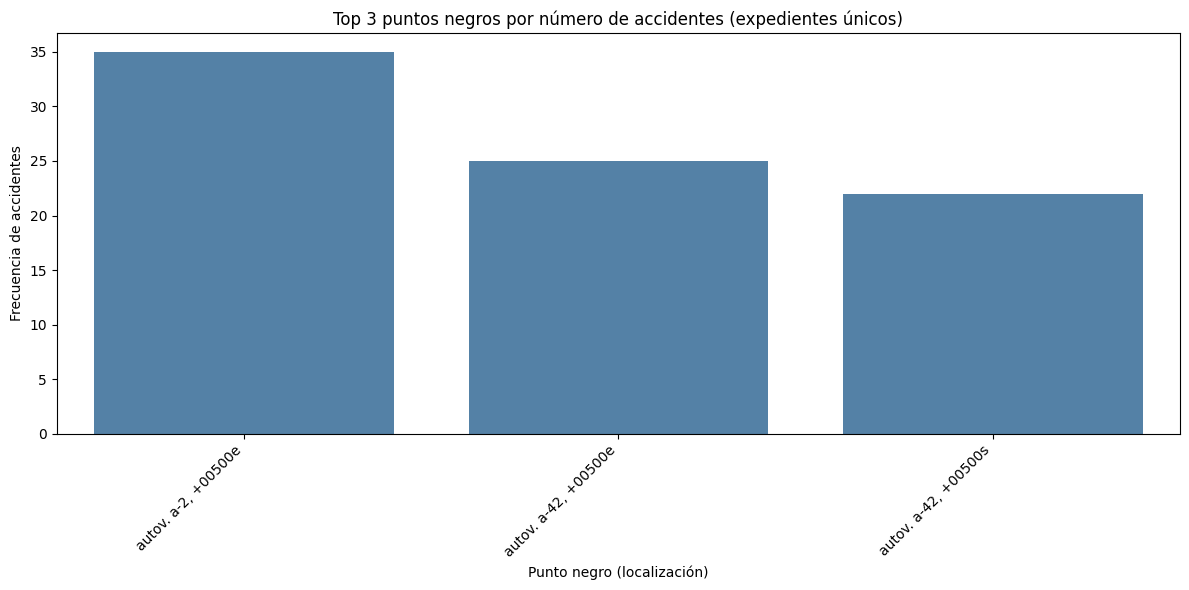

In [35]:
# Seleccionar los 5 puntos negros con más accidentes
top3 = puntos_negros.nlargest(3, 'n_expedientes').copy()

# Resetear índice para evitar problemas de posición
top3 = top3.reset_index(drop=True)

plt.figure(figsize=(12, 6))

sns.barplot(
    data=top3,
    x='localizacion_norm',
    y='n_expedientes',
    color='steelblue'
)

plt.title('Top 3 puntos negros por número de accidentes (expedientes únicos)')
plt.xlabel('Punto negro (localización)')
plt.ylabel('Frecuencia de accidentes')

# Rotar etiquetas del eje X para que se lean bien
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


Puntos negros (localizaciones repetidas), ¿Donde se situan los puntos negros?

- Los tres puntos negros más destacados se localizan en tramos específicos de autovías, concretamente en la A‑2 y la A‑42, identificados por su referencia kilométrica. En el caso de la A‑2, el punto situado en el kilómetro +00500E, dentro del distrito de Ciudad Lineal, concentra 35 accidentes únicos, lo que evidencia una recurrencia significativa en ese mismo lugar. Por su parte, la A‑42 presenta dos tramos consecutivos con alta siniestralidad: uno en el kilómetro +00500E (Usera) y otro en +00500S (Carabanchel), con 25 y 22 accidentes respectivamente. Esta concentración de expedientes en puntos tan concretos sugiere la existencia de factores estructurales o de diseño que podrían estar contribuyendo a la peligrosidad de estos tramos, como accesos conflictivos, deficiencias de señalización o condiciones geométricas adversas.

- Los puntos negros detectados en la A‑2 y A‑42 son zonas de alta peligrosidad recurrente, probablemente asociadas a incorporaciones, cambios de rasante, curvas cerradas o falta de señalización. Estos tramos deberían ser prioridad en intervenciones de seguridad vial, ya que concentran múltiples accidentes únicos en el mismo lugar.

- Este formato es el que utiliza el Ayuntamiento/Policía para registrar accidentes en autovías, donde no existe un número de portal.
La localización se codifica con:

- Nombre de la vía: A‑2

- Referencia kilométrica: +00500

- Sentido: E

- Interpretación:
- A‑2 → Autovía del Nordeste (Madrid–Zaragoza–Barcelona)

- +00500 → Punto kilométrico 0,5 (500 metros desde el inicio del tramo urbano)

- E → Sentido Este, es decir, dirección salida de Madrid hacia Zaragoza

- Traducción práctica:  
- Accidente ocurrido en el PK 0,5 de la A‑2, sentido Zaragoza.

#### Analisis Univariante por tipo de accidente

- Frecuencia de cada tipo de accidente
- ¿Qué tipo de accidente es más común?


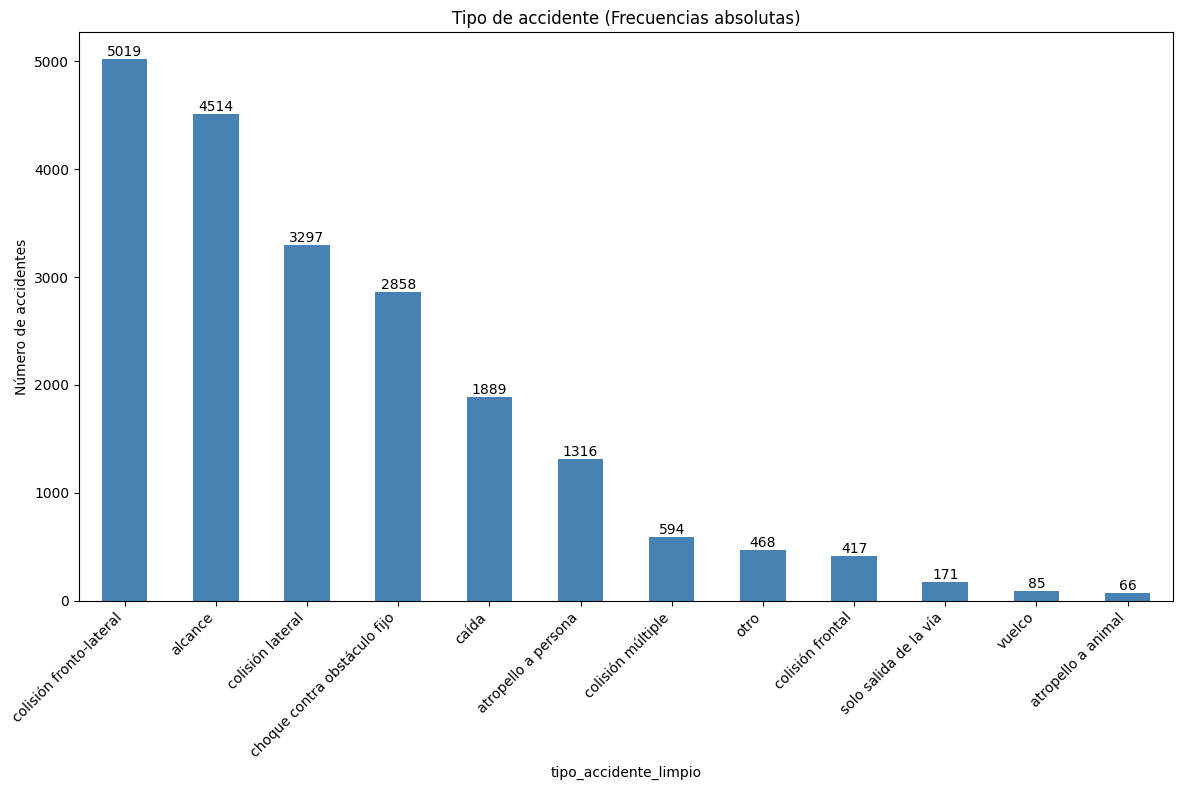

In [36]:
# Crear columna limpia
df = df_accidentes_2024_copy_univariante.copy()
df["tipo_accidente_limpio"] = df["tipo_accidente"].str.strip().str.lower()

# Filtrar "no consta" 
df_filtrado = df[df["tipo_accidente_limpio"] != "no consta"]

# Calcular frecuencias absolutas
abs_freq = (
    df_filtrado
    .groupby("tipo_accidente_limpio")["num_expediente"]
    .nunique()
    .sort_values(ascending=False)
)

# Eliminar categorías con valor 0 
abs_freq = abs_freq[abs_freq > 0]

# Crear gráfico 
plt.figure(figsize=(12, 8))
abs_freq.plot(kind="bar", color="steelblue")

plt.title("Tipo de accidente (Frecuencias absolutas)")
plt.ylabel("Número de accidentes")
plt.xticks(rotation=45, ha="right")

# Etiquetas numéricas encima de cada barra
for i, v in enumerate(abs_freq):
    plt.text(i, v, f"{v}", ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()




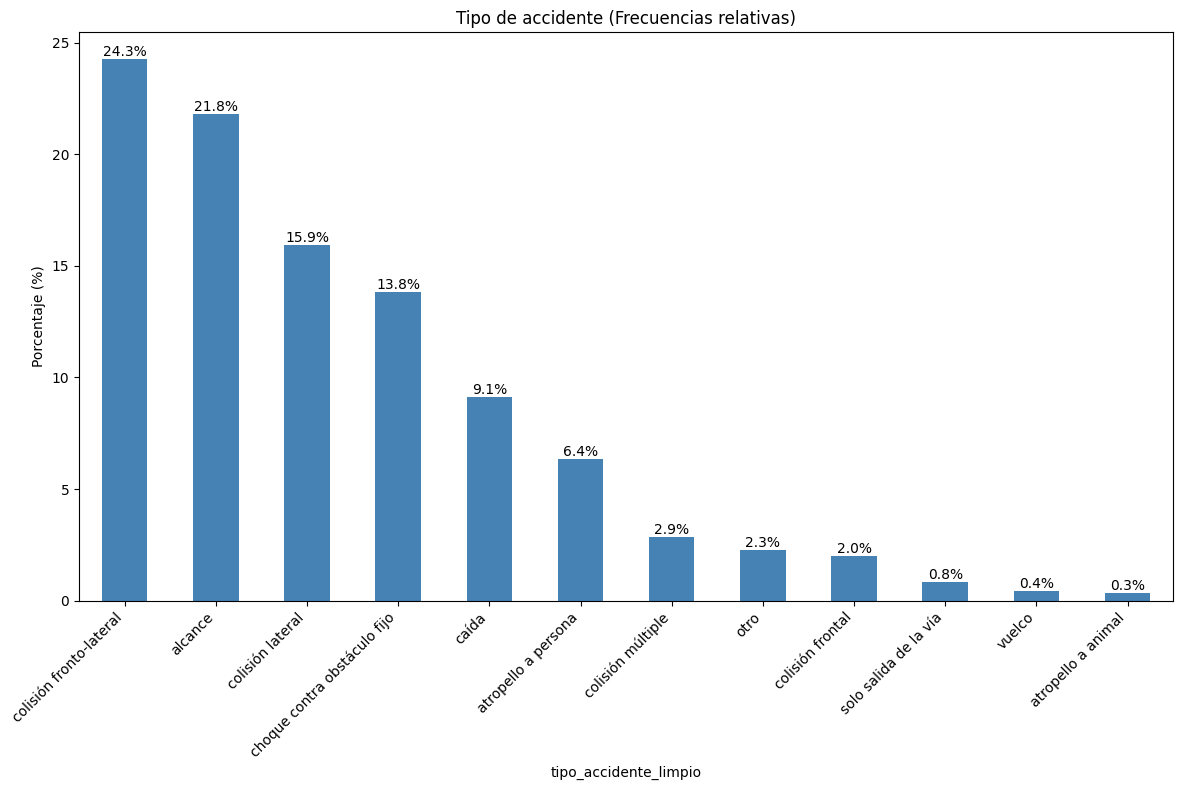

In [37]:
# Crear columna limpia 
df = df_accidentes_2024_copy_univariante.copy()
df["tipo_accidente_limpio"] = df["tipo_accidente"].str.strip().str.lower()

# Filtrar "no consta"
df_filtrado = df[df["tipo_accidente_limpio"] != "no consta"]

# Calcular frecuencias absolutas 
abs_freq = (
    df_filtrado
    .groupby("tipo_accidente_limpio")["num_expediente"]
    .nunique()
    .sort_values(ascending=False)
)

# Calcular frecuencias relativas 
rel_freq = abs_freq / abs_freq.sum() * 100

# Eliminar categorías con valor 0 (por si acaso) 
rel_freq = rel_freq[rel_freq > 0]

#  Crear gráfico 
plt.figure(figsize=(12, 8))
rel_freq.plot(kind="bar", color="steelblue")

plt.title("Tipo de accidente (Frecuencias relativas)")
plt.ylabel("Porcentaje (%)")
plt.xticks(rotation=45, ha="right")

# Etiquetas numéricas encima de cada barra
for i, v in enumerate(rel_freq):
    plt.text(i, v, f"{v:.1f}%", ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()


Los datos muestran una clara concentración en ciertos tipos de siniestros:

- Colisión fronto-lateral: 5019 casos (24.3%)

- Alcance: 4514 casos (21.8%)

- Colisión lateral: 3297 casos (15.9%)

- Choque contra obstáculo fijo: 2858 casos (13.8%)

- Caída: 1889 casos (9.1%)

- Atropello a persona: 1316 casos (6.4%)

- Otros tipos como colisión múltiple, frontal, vuelco o atropello a animal tienen frecuencias mucho menores (≤ 3%).

El tipo más frecuente es la colisión fronto-lateral, representando casi una cuarta parte de todos los accidentes registrados. Le siguen el alcance y la colisión lateral, que juntas suman más del 60% de los casos.

#### Analisdis Univariante por tipo de persona implicada en los accidente y por vehiculos

- Conductores vs pasajeros vs peatones
- Vehículos más involucrados
- Distribución por edad en los accidentes, ¿Qué grupos de edad aparecen más?
- Para un analisis demografico general ,¿Qué edades están más presentes en los accidentes, independientemente del rol?
- Distribución por sexo, ¿Hay diferencias entre hombres y mujeres?
- Accidentes de motos vs coches


C:\Users\César\AppData\Local\Temp\ipykernel_4408\3629859117.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(abs_freq.index, rotation=45, ha="right")
C:\Users\César\AppData\Local\Temp\ipykernel_4408\3629859117.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(rel_freq.index, rotation=45, ha="right")


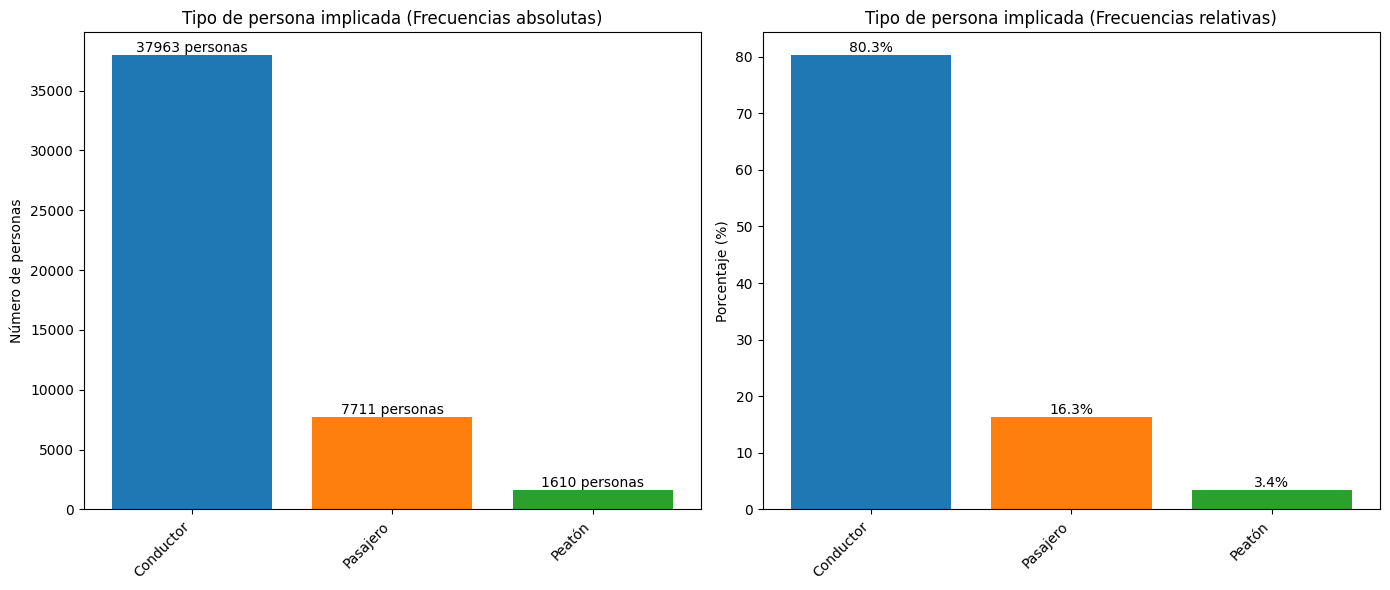

In [38]:
# Frecuencias absolutas (personas)
abs_freq = (
    df_accidentes_2024_copy_univariante["tipo_persona"]
    .value_counts()
)

# Frecuencias relativas (%)
rel_freq = abs_freq / abs_freq.sum() * 100

# Paleta de colores consistente
colors = sns.color_palette("tab10", n_colors=len(abs_freq))

# Crear figura con dos subplots horizontales
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico 1: Absolutas (izquierda) 
axes[0].bar(abs_freq.index, abs_freq.values, color=colors)
axes[0].set_title("Tipo de persona implicada (Frecuencias absolutas)")
axes[0].set_ylabel("Número de personas")

# Rotación y alineación de etiquetas del eje X
axes[0].set_xticklabels(abs_freq.index, rotation=45, ha="right")

# Etiquetas encima de cada barra
for i, v in enumerate(abs_freq):
    axes[0].text(i, v, f"{v} personas", ha="center", va="bottom", fontsize=10)

# Gráfico 2: Relativas (derecha)
axes[1].bar(rel_freq.index, rel_freq.values, color=colors)
axes[1].set_title("Tipo de persona implicada (Frecuencias relativas)")
axes[1].set_ylabel("Porcentaje (%)")

# Rotación y alineación de etiquetas del eje X
axes[1].set_xticklabels(rel_freq.index, rotation=45, ha="right")

# Etiquetas encima de cada barra
for i, v in enumerate(rel_freq):
    axes[1].text(i, v, f"{v:.1f}%", ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()


Datos observados:
- Conductores: 39.560 personas (80.2%)

- Pasajeros: 8.155 personas (16.5%)

- Peatones: 1.622 personas (3.3%)

Conclusiones clave
1. Los conductores son el grupo más implicado
Más del 80% de las personas involucradas en accidentes son conductores, lo que refleja que la mayoría de siniestros ocurren durante la conducción activa, y no como acompañantes ni como peatones.

2. Los pasajeros tienen una implicación secundaria
Aunque representan el 16.5%, los pasajeros suelen estar expuestos a los efectos del accidente sin tener control sobre la situación. Esto refuerza la importancia de medidas de seguridad pasiva, como cinturones, airbags y diseño interior.

3. Los peatones son minoría, pero críticos
Solo el 3.3% de las personas implicadas son peatones, pero su vulnerabilidad es mucho mayor. Aunque menos frecuentes, los accidentes con peatones suelen tener mayor gravedad, lo que exige atención especial en zonas urbanas, pasos de cebra y entornos escolares.

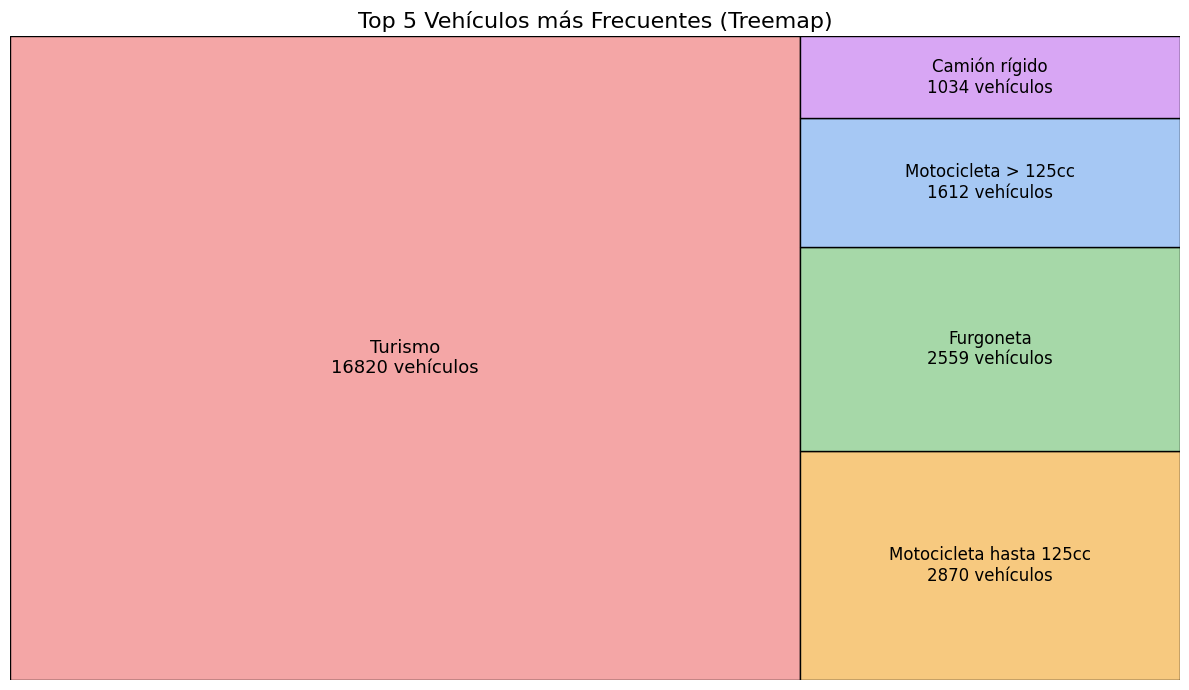

In [ ]:
# 1. Filtrar solo conductores 
df_conductores = df_accidentes_2024_copy_univariante[
    df_accidentes_2024_copy_univariante["tipo_persona"].str.strip().str.lower() == "conductor"
]

# 2. Evitar duplicados reales 
df_vehiculos = df_conductores[["num_expediente", "tipo_vehiculo"]].drop_duplicates()

# 3. Contar los 5 vehículos más frecuentes 
vehiculo_freq = (
    df_vehiculos["tipo_vehiculo"]
    .str.strip()
    .value_counts()
    .head(5)
)

labels = vehiculo_freq.index.tolist()
sizes = vehiculo_freq.values.tolist()

# 4. Normalizar tamaños 
total = sum(sizes)
norm_sizes = [s / total for s in sizes]

# 5. Crear treemap estilo “bloque grande + 4 apilados”
fig, ax = plt.subplots(figsize=(12, 7))

# Área total
W, H = 100, 100

# Bloque principal (izquierda)
main_width = W * norm_sizes[0]          # proporcional
main_height = H

# Dibujar bloque principal
ax.add_patch(Rectangle((0, 0), main_width, main_height,
                       facecolor="#f4a6a6", edgecolor="black"))
ax.text(main_width/2, main_height/2,
        f"{labels[0]}\n{sizes[0]} vehículos",
        ha="center", va="center", fontsize=13)

# Bloques apilados (derecha)
x_right = main_width
y = 0
right_width = W - main_width

# Normalizar tamaños de los 4 restantes dentro del área derecha
rest_sizes = norm_sizes[1:]
rest_total = sum(rest_sizes)
rest_norm = [s / rest_total for s in rest_sizes]

colores = ["#f7c97f", "#a6d8a8", "#a6c8f4", "#d8a6f4"]

for i in range(4):
    block_height = H * rest_norm[i]     # proporcional
    ax.add_patch(Rectangle((x_right, y), right_width, block_height,
                           facecolor=colores[i], edgecolor="black"))
    ax.text(x_right + right_width/2, y + block_height/2,
            f"{labels[i+1]}\n{sizes[i+1]} vehículos",
            ha="center", va="center", fontsize=12)
    y += block_height

# 6. Estética final 
ax.set_xlim(0, W)
ax.set_ylim(0, H)
ax.axis("off")
plt.title("Top 5 Vehículos más Frecuentes (Treemap)", fontsize=16)
plt.tight_layout()
plt.show()

Datos observados:
- Turismo (vehículo particular): 16.820 casos

- Motocicleta hasta 125cc: 2.870 casos

- Furgoneta: 2.559 casos

- Motocicleta > 125cc: 1.612 casos

- Camión rígido: 1.034 casos

Conclusiones clave
1. El turismo domina claramente la siniestralidad
Más del 70% de los vehículos implicados son turismos, lo que refleja que la movilidad urbana y particular es el principal escenario de riesgo. Esto es coherente con el perfil de ciudad densa y tráfico diario.

2. Las motocicletas tienen una presencia significativa
Sumando las dos categorías de motocicletas (hasta y más de 125cc), se superan los 4.400 casos, lo que representa una proporción considerable. Esto indica que, aunque menos numerosas que los turismos, las motos están altamente expuestas y deben ser consideradas en políticas de seguridad vial.

3. Furgonetas y camiones también están presentes
Aunque en menor medida, los vehículos de transporte como furgonetas y camiones rígidos aparecen en el top 5. Esto sugiere que la logística urbana también contribuye a la siniestralidad, especialmente en zonas de carga, reparto o maniobras.

- Para seguridad vial es mas util tener solo por conductor 

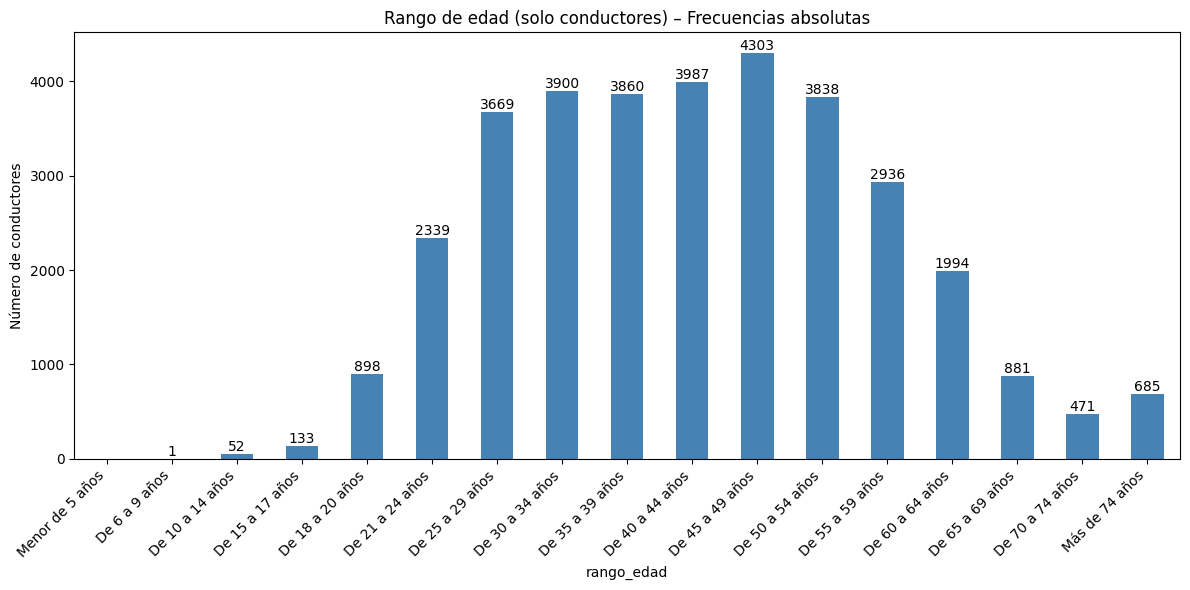

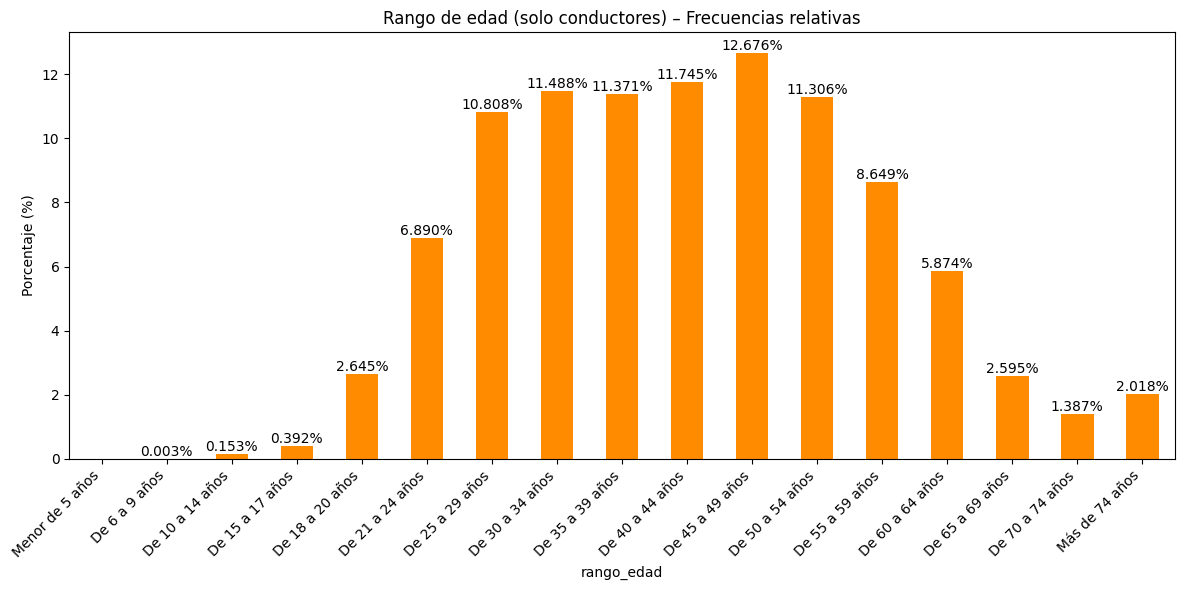

In [41]:
# 1. Filtrar solo conductores 
df_conductores = df_accidentes_2024_copy_univariante[
    df_accidentes_2024_copy_univariante["tipo_persona"].str.strip().str.lower() == "conductor"
]

# 2. Eliminar categoría "Desconocido" 
df_conductores = df_conductores[
    df_conductores["rango_edad"].str.strip().str.lower() != "desconocido"
]

# 3. Orden correcto de rangos de edad 
orden_edad = [
    "Menor de 5 años",
    "De 6 a 9 años",
    "De 10 a 14 años",
    "De 15 a 17 años",
    "De 18 a 20 años",
    "De 21 a 24 años",
    "De 25 a 29 años",
    "De 30 a 34 años",
    "De 35 a 39 años",
    "De 40 a 44 años",
    "De 45 a 49 años",
    "De 50 a 54 años",
    "De 55 a 59 años",
    "De 60 a 64 años",
    "De 65 a 69 años",
    "De 70 a 74 años",
    "Más de 74 años"
]

df_conductores["rango_edad"] = df_conductores["rango_edad"].str.strip()
df_conductores["rango_edad"] = df_conductores["rango_edad"].astype("category")
df_conductores["rango_edad"] = df_conductores["rango_edad"].cat.set_categories(
    orden_edad, ordered=True
)

# 4. Frecuencias
edad_abs = df_conductores["rango_edad"].value_counts().sort_index()
edad_rel = edad_abs / edad_abs.sum() * 100

# 5. Gráfico de frecuencias absolutas 
plt.figure(figsize=(12, 6))
edad_abs.plot(kind="bar", color="steelblue")

plt.title("Rango de edad (solo conductores) – Frecuencias absolutas")
plt.ylabel("Número de conductores")
plt.xticks(rotation=45, ha="right")

for i, v in enumerate(edad_abs):
    if v > 0:
        plt.text(i, v, f"{v}", ha="center", va="bottom")

plt.tight_layout()
plt.show()

# 6. Gráfico de frecuencias relativas 
plt.figure(figsize=(12, 6))
edad_rel.plot(kind="bar", color="darkorange")

plt.title("Rango de edad (solo conductores) – Frecuencias relativas")
plt.ylabel("Porcentaje (%)")
plt.xticks(rotation=45, ha="right")

for i, v in enumerate(edad_rel):
    if v > 0:
        plt.text(i, v, f"{v:.3f}%", ha="center", va="bottom")

plt.tight_layout()
plt.show()


Datos clave observados:
- Frecuencias absolutas (número de conductores implicados):
Máxima concentración entre 40 y 49 años (más de 4.000 casos por grupo).

- Alta participación también entre 30 y 39 años.

- Descenso progresivo a partir de los 50 años.

- Presencia marginal en menores de 18 años, aunque no nula.

Frecuencias relativas (porcentaje sobre el total):
- El grupo más representado es 40–44 años (12.7%), seguido por 35–39 años (11.7%).

- Los grupos entre 30 y 49 años concentran más del 45% de los conductores implicados.

- Los menores de edad (≤17 años) representan menos del 3.2% del total.

- Los mayores de 65 años tienen presencia reducida pero no despreciable.

Conclusiones clave
1. Edad media de riesgo: entre 30 y 49 años
La mayoría de conductores implicados en accidentes se sitúan entre los 30 y 49 años, lo que coincide con la franja de mayor actividad laboral y movilidad diaria. Esto sugiere que el riesgo está asociado al volumen de exposición, no necesariamente a la imprudencia.

2. Baja pero significativa presencia de menores
Aunque los menores de edad representan un porcentaje muy bajo, su presencia como conductores en los datos es preocupante. Como ya has detectado, algunos casos son incoherencias normativas (turismos conducidos por menores), mientras que otros (VMU, bicicletas) son legales pero vulnerables.

3. Descenso progresivo en mayores de 50 años
A partir de los 50 años, la implicación en accidentes disminuye, aunque sigue siendo relevante. Esto puede deberse a menor exposición, mayor experiencia, o cambios en hábitos de movilidad.

4. Importancia de validar edad y tipo de vehículo
La presencia de menores en vehículos no autorizados refuerza la necesidad de validar la coherencia entre edad, tipo de vehículo y rol en el accidente. Este cruce es esencial para evitar errores de interpretación y para diseñar políticas de prevención ajustadas a la realidad.

In [42]:
df_conductores_6_9 = df_accidentes_2024_copy_univariante[
    (df_accidentes_2024_copy_univariante["tipo_persona"].str.strip().str.lower() == "conductor") &
    (df_accidentes_2024_copy_univariante["rango_edad"].str.strip() == "De 6 a 9 años")
]

df_conductores_6_9

num_expediente                                     localizacion numero  \
41618    2024s031099  ctra. villaverde a vallecas / call. villafuerte      3   

         distrito           tipo_accidente estado_meteorológico  \
41618  VILLAVERDE  Colisión fronto-lateral            Despejado   

       tipo_vehiculo tipo_persona     rango_edad    sexo  coordenada_x_utm  \
41618  VMU eléctrico    Conductor  De 6 a 9 años  Hombre          441440.0   

       coordenada_y_utm positiva_alcohol          fecha_hora grado_lesividad  \
41618         4467245.0         Negativo 2024-11-10 22:15:00            Leve   

      franja_horaria  
41618          Noche

- En este caso conducia un patinete electrico que no tiene edad minima.

1. Caso de 6 a 9 años
- Registro detectado: Un conductor de VMU eléctrico.

- Interpretación: No hay incoherencia legal. Los Vehículos de Movilidad Urbana (VMU) como patinetes eléctricos no requieren edad mínima legal para circular, aunque sí pueden estar regulados por ordenanzas municipales.

- Conclusión: Este caso es coherente, aunque merece atención si se quiere evaluar la exposición de menores a accidentes.

In [43]:
vehiculos_ilegales = [
    "Turismo", "Motocicleta hasta 125cc", "Motocicleta > 125cc",
    "Furgoneta", "Camión rígido", "Autobús", "Autobús articulado",
    "Autobus EMT", "Tractocamión", "Vehículo articulado",
    "Maquinaria de obras", "Autocaravana", "Cuadriciclo no ligero",
    "Moto de tres ruedas > 125cc", "Moto de tres ruedas hasta 125cc",
    "Ciclomotor", "Ciclomotor de dos ruedas L1e-B",
    "Ciclomotor de tres ruedas", "Ciclo de motor L1e-A",
    "Remolque", "Semiremolque", "Otros vehículos con motor"
]

df_10_14_ilegales = df_accidentes_2024_copy_univariante[
    (df_accidentes_2024_copy_univariante["tipo_persona"].str.lower().str.strip() == "conductor") &
    (df_accidentes_2024_copy_univariante["rango_edad"].str.strip() == "De 10 a 14 años") &
    (df_accidentes_2024_copy_univariante["tipo_vehiculo"].isin(vehiculos_ilegales))
]

df_10_14_ilegales

num_expediente                               localizacion numero  \
30473    2024s024470                         cmno. zarzuela, 20     20   
38603    2024s029374  call. albarracin / call. julian camarillo     29   

                  distrito                tipo_accidente estado_meteorológico  \
30473      MONCLOA-ARAVACA  Choque contra obstáculo fijo            Despejado   
38603  SAN BLAS-CANILLEJAS                       Alcance         Se desconoce   

      tipo_vehiculo tipo_persona       rango_edad    sexo  coordenada_x_utm  \
30473       Turismo    Conductor  De 10 a 14 años  Hombre          433354.0   
38603       Turismo    Conductor  De 10 a 14 años  Hombre          446372.0   

       coordenada_y_utm positiva_alcohol          fecha_hora  \
30473         4479693.0         Negativo 2024-08-21 17:00:00   
38603         4476137.0         Negativo 2024-10-21 10:50:00   

                grado_lesividad franja_horaria  
30473                      Leve          Tarde  
38603  Sin asistencia sanitaria         Mañana

- Registros detectados: Dos conductores de turismo en ese rango de edad.

- Vehículo implicado: Turismo (coche).

- Edad mínima legal para conducir turismo: 18 años.

- Conclusión: Estos casos son incoherencias graves desde el punto de vista normativo. Es imposible legalmente que una persona de 10 a 14 años conduzca un turismo.
- Posibles causas:

- Error de registro en el campo tipo_persona (era pasajero o peatón).

- Error en rango_edad.

- Error en tipo_vehiculo.

- Esto puede ser error del policia al apuntar el incidente o una ilegalidad por parte del menor 

| Vehículo                                           | Edad mínima legal                                      |
|----------------------------------------------------|--------------------------------------------------------|
| Turismo (coche)                                    | 18 años                                                |
| Motocicleta > 125cc                                | 18 años                                                |
| Motocicleta hasta 125cc                            | 16 años                                                |
| Ciclomotor (L1e, L2e)                              | 15 años                                                |
| Cuadriciclo ligero                                 | 15 años                                                |
| Cuadriciclo no ligero                              | 18 años                                                |
| Camión, furgoneta grande, autobús, articulados     | 18–21 años                                             |
| Bicicleta, patinete, VMU eléctrico                 | Sin edad mínima (no son vehículos a motor)            |
| Tractocamión, maquinaria de obras                  | 18 años                                                |
| Remolques / semirremolques                         | 18 años                                                |


In [44]:
# 1. Lista de vehículos que NO pueden ser conducidos legalmente entre 15 y 17 años
vehiculos_ilegales_15_17 = [
    "Turismo",
    "Motocicleta > 125cc",
    "Furgoneta",
    "Camión rígido",
    "Autobús",
    "Autobús articulado",
    "Autobus EMT",
    "Tractocamión",
    "Vehículo articulado",
    "Maquinaria de obras",
    "Autocaravana",
    "Cuadriciclo no ligero",
    "Moto de tres ruedas > 125cc",
    "Moto de tres ruedas hasta 125cc",
    "Ciclomotor de tres ruedas",
    "Ciclomotor de dos ruedas L1e-B",
    "Ciclo de motor L1e-A",
    "Remolque",
    "Semiremolque",
    "Otros vehículos con motor"
]

# 2. Filtrar conductores de 15 a 17 años que aparecen con vehículos ilegales
df_15_17_ilegales = df_accidentes_2024_copy_univariante[
    (df_accidentes_2024_copy_univariante["tipo_persona"].str.lower().str.strip() == "conductor") &
    (df_accidentes_2024_copy_univariante["rango_edad"].str.strip() == "De 15 a 17 años") &
    (df_accidentes_2024_copy_univariante["tipo_vehiculo"].isin(vehiculos_ilegales_15_17))
]

# 3. Mostrar resultado
df_15_17_ilegales


num_expediente                                    localizacion numero  \
13036    2024s012817  call. cañada del santisimo / avda. las suertes     27   
22899    2024s019893                         call. santa virgilia, 5      5   
24021    2024s020580                           call. alfonso paso, 1      1   
29917    2024s024109                               call. fenelon, 12     12   
33617    2024s026343           paseo. ferroviarios / call. palomares     49   

                  distrito           tipo_accidente estado_meteorológico  \
13036    VILLA DE VALLECAS         Colisión frontal            Despejado   
22899            HORTALEZA         Colisión frontal            Despejado   
24021        CIUDAD LINEAL         Colisión frontal            Despejado   
29917  SAN BLAS-CANILLEJAS        Colisión múltiple            Despejado   
33617           VILLAVERDE  Colisión fronto-lateral            Despejado   

                   tipo_vehiculo tipo_persona       rango_edad    sexo  \
13036                    Turismo    Conductor  De 15 a 17 años  Hombre   
22899                    Turismo    Conductor  De 15 a 17 años  Hombre   
24021                  Furgoneta    Conductor  De 15 a 17 años  Hombre   
29917                    Turismo    Conductor  De 15 a 17 años  Hombre   
33617  Otros vehículos con motor    Conductor  De 15 a 17 años  Hombre   

       coordenada_x_utm  coordenada_y_utm positiva_alcohol  \
13036          449307.0         4468614.0         Negativo   
22899          445461.0         4481032.0         Negativo   
24021          445827.0         4476461.0         Negativo   
29917          448314.0         4476585.0         Negativo   
33617          439276.0         4466688.0         Negativo   

               fecha_hora           grado_lesividad franja_horaria  
13036 2024-04-10 11:45:00                      Leve         Mañana  
22899 2024-06-16 04:40:00  Sin asistencia sanitaria      Madrugada  
24021 2024-06-24 17:00:00  Sin asistencia sanitaria          Tarde  
29917 2024-08-13 19:00:00                      Leve          Noche  
33617 2024-09-17 14:20:00                      Leve          Tarde

- Registros detectados: 6 conductores en este rango de edad.

- Vehículos implicados:

- Turismo (4 casos)

- Furgoneta (1 caso)

- Otros vehículos con motor (1 caso)

- Edad mínima legal para estos vehículos: 18 años.

- Conclusión: Todos estos casos son incoherencias normativas.
A los 15–17 años solo se puede conducir:

- Ciclomotor

- Motocicleta hasta 125cc

- Cuadriciclo ligero

- VMU / bicicleta / ciclo

- Esto puede ser error del policia al apuntar el incidente o una ilegalidad por parte del menor 

“¿Qué edades están más presentes en los accidentes, independientemente del rol?” Para un analisis demografico general

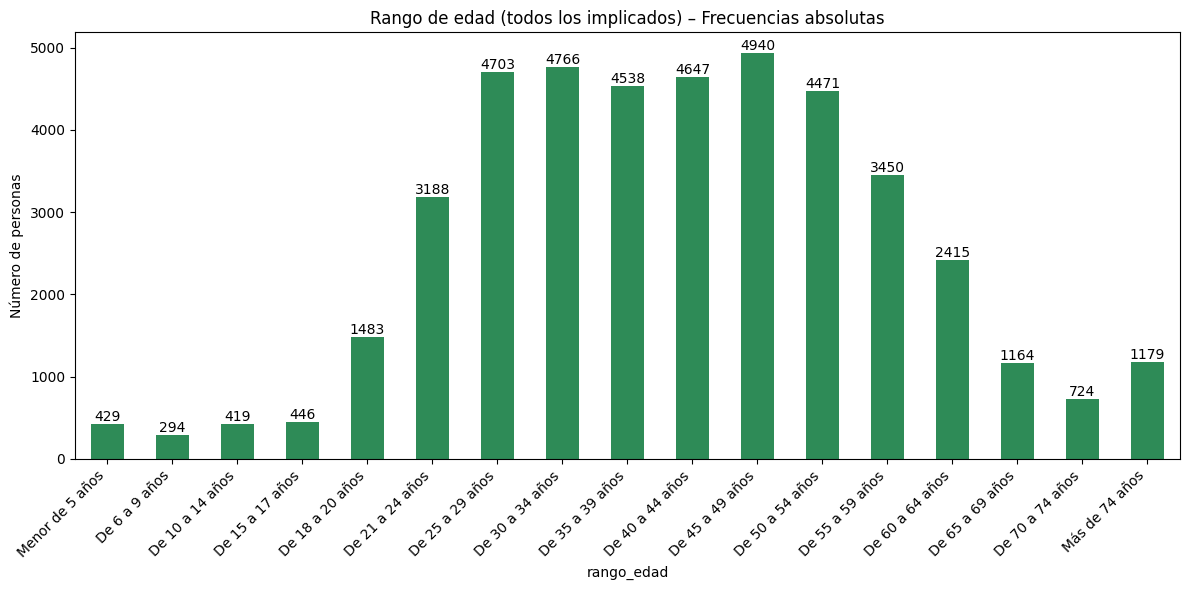

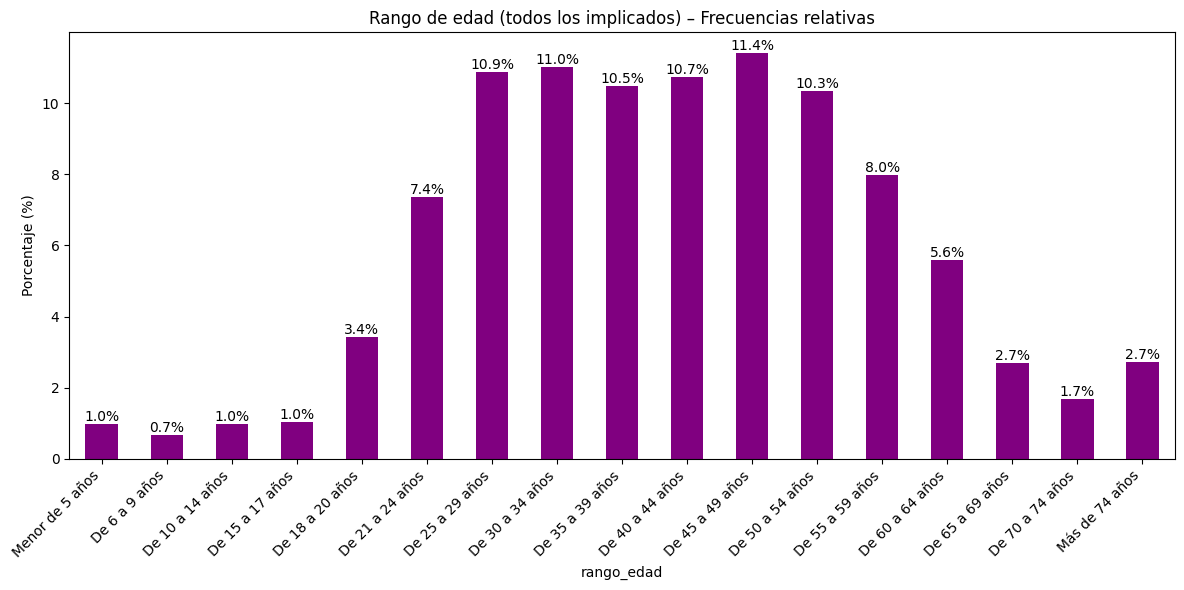

In [45]:
# 1. Dataset completo (todos los implicados) 
df_todos = df_accidentes_2024_copy_univariante.copy()

# 2. Eliminar categoría "Desconocido" 
df_todos = df_todos[
    df_todos["rango_edad"].str.strip().str.lower() != "desconocido"
]

# 3. Orden correcto de rangos de edad 
orden_edad = [
    "Menor de 5 años",
    "De 6 a 9 años",
    "De 10 a 14 años",
    "De 15 a 17 años",
    "De 18 a 20 años",
    "De 21 a 24 años",
    "De 25 a 29 años",
    "De 30 a 34 años",
    "De 35 a 39 años",
    "De 40 a 44 años",
    "De 45 a 49 años",
    "De 50 a 54 años",
    "De 55 a 59 años",
    "De 60 a 64 años",
    "De 65 a 69 años",
    "De 70 a 74 años",
    "Más de 74 años"
]

df_todos["rango_edad"] = df_todos["rango_edad"].str.strip()
df_todos["rango_edad"] = df_todos["rango_edad"].astype("category")
df_todos["rango_edad"] = df_todos["rango_edad"].cat.set_categories(
    orden_edad, ordered=True
)

# 4. Frecuencias absolutas 
edad_abs_all = df_todos["rango_edad"].value_counts().sort_index()

# 5. Frecuencias relativas (%) 
edad_rel_all = edad_abs_all / edad_abs_all.sum() * 100

# 6. Gráfico de frecuencias absolutas 
plt.figure(figsize=(12, 6))
edad_abs_all.plot(kind="bar", color="seagreen")

plt.title("Rango de edad (todos los implicados) – Frecuencias absolutas")
plt.ylabel("Número de personas")
plt.xticks(rotation=45, ha="right")

for i, v in enumerate(edad_abs_all):
    if v > 0:
        plt.text(i, v, f"{v}", ha="center", va="bottom")

plt.tight_layout()
plt.show()

# 7. Gráfico de frecuencias relativas 
plt.figure(figsize=(12, 6))
edad_rel_all.plot(kind="bar", color="purple")

plt.title("Rango de edad (todos los implicados) – Frecuencias relativas")
plt.ylabel("Porcentaje (%)")
plt.xticks(rotation=45, ha="right")

for i, v in enumerate(edad_rel_all):
    if v > 0:
        plt.text(i, v, f"{v:.1f}%", ha="center", va="bottom")

plt.tight_layout()
plt.show()


Datos clave observados:
Frecuencias absolutas:
Los grupos más numerosos son:

- 30–34 años: 4.828 personas

- 25–29 años: 4.816 personas

- 45–49 años: 5.002 personas

- 40–44 años: 4.697 personas

- 35–39 años: 4.585 personas

- 50–54 años: 4.538 personas
Frecuencias relativas:
Los porcentajes más altos están en:

- 45–49 años: 11.4%

- 30–34 años: 11.0%

- 25–29 años: 10.9%

- 40–44 años: 10.7%

- 35–39 años: 10.4%

- 50–54 años: 10.3%

Conclusiones clave
1. Edad de mayor implicación: 25 a 54 años
Más del 60% de las personas implicadas en accidentes se concentran entre los 25 y 54 años, lo que refleja que esta franja es la de mayor exposición vial. Coincide con los años de mayor actividad laboral, movilidad urbana y uso intensivo de vehículos.

2. Alta implicación en la treintena y cuarentena
Los grupos entre 30 y 49 años son los más representados tanto en número absoluto como en porcentaje. Esto sugiere que el perfil típico de persona implicada en accidentes es un adulto en edad laboral activa, probablemente con desplazamientos frecuentes.

3. Presencia significativa de mayores de 60
Aunque en menor proporción, los mayores de 60 años siguen apareciendo en los datos. Esto indica que, aunque su movilidad es menor, no están exentos de riesgo, especialmente como peatones o pasajeros.

4. Baja pero no nula presencia de menores
Los menores de 18 años representan alrededor del 3.8% del total. Aunque su implicación es baja, es importante considerar su vulnerabilidad, especialmente como pasajeros o peatones.

 Distribución por sexo, ¿Hay diferencias entre hombres y mujeres?

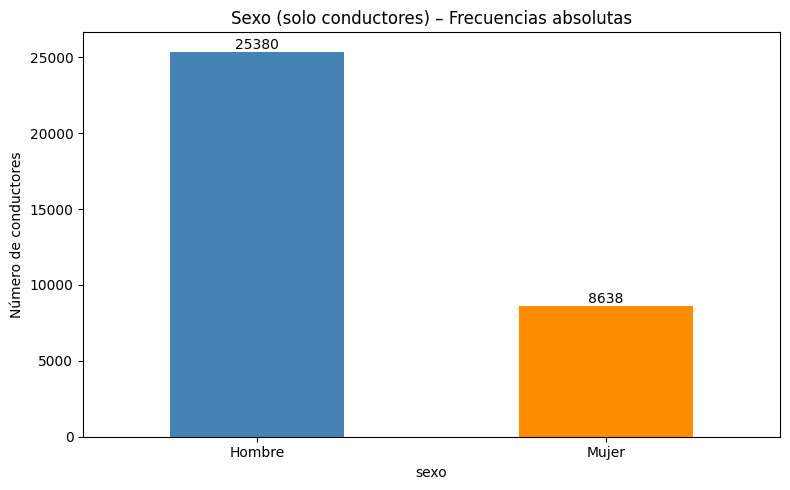

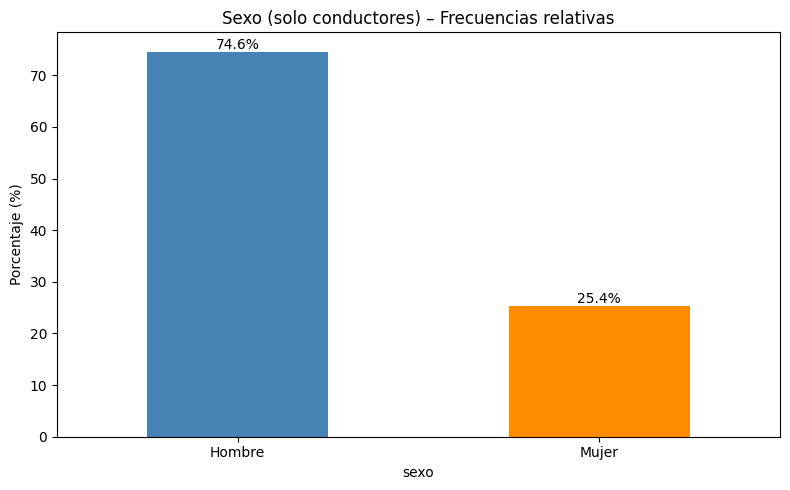

In [49]:
# 1. Filtrar solo conductores 
df_conductores = df_accidentes_2024_copy_univariante[
    df_accidentes_2024_copy_univariante["tipo_persona"].str.strip().str.lower() == "conductor"
]

# 2. Eliminar "Desconocido"
df_conductores = df_conductores[
    df_conductores["sexo"].str.strip().str.lower() != "desconocido"
]

# 3. Orden correcto 
orden_sexo = ["Hombre", "Mujer"]

df_conductores["sexo"] = df_conductores["sexo"].str.strip()
df_conductores["sexo"] = df_conductores["sexo"].astype("category")
df_conductores["sexo"] = df_conductores["sexo"].cat.set_categories(
    orden_sexo, ordered=True
)

# 4. Frecuencias 
sexo_abs = df_conductores["sexo"].value_counts().sort_index()
sexo_rel = sexo_abs / sexo_abs.sum() * 100

# 5. Gráfico de frecuencias absolutas 
plt.figure(figsize=(8, 5))
sexo_abs.plot(kind="bar", color=["steelblue", "darkorange"])

plt.title("Sexo (solo conductores) – Frecuencias absolutas")
plt.ylabel("Número de conductores")
plt.xticks(rotation=0)

for i, v in enumerate(sexo_abs):
    plt.text(i, v, f"{v}", ha="center", va="bottom")

plt.tight_layout()
plt.show()

# 6. Gráfico de frecuencias relativas
plt.figure(figsize=(8, 5))
sexo_rel.plot(kind="bar", color=["steelblue", "darkorange"])

plt.title("Sexo (solo conductores) – Frecuencias relativas")
plt.ylabel("Porcentaje (%)")
plt.xticks(rotation=0)

for i, v in enumerate(sexo_rel):
    plt.text(i, v, f"{v:.1f}%", ha="center", va="bottom")

plt.tight_layout()
plt.show()


Conclusiones clave:
1. Predominio masculino entre conductores implicados
Los hombres representan tres de cada cuatro conductores implicados en accidentes. Esta diferencia es muy marcada tanto en número como en proporción.

2. Posible relación con hábitos de conducción
Este predominio puede deberse a que los hombres, en promedio, conducen más kilómetros, tienen mayor presencia en vehículos profesionales (furgonetas, camiones, motos), y están más expuestos a la circulación diaria.

3. No implica mayor imprudencia, sino mayor exposición
La diferencia no debe interpretarse como una cuestión de imprudencia, sino como una mayor exposición al riesgo por volumen de conducción. Para evaluar comportamientos, habría que cruzar con variables como tipo de accidente, alcohol/drogas, velocidad, etc.

4. Importancia de segmentar por tipo de vehículo
Sería útil analizar si esta diferencia se mantiene en todos los tipos de vehículo o si hay segmentos donde las mujeres están más representadas (por ejemplo, turismos frente a motocicletas o furgonetas).

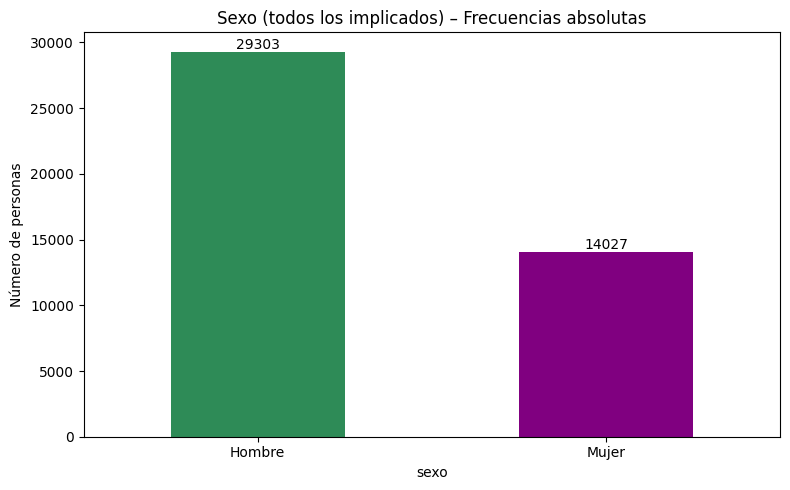

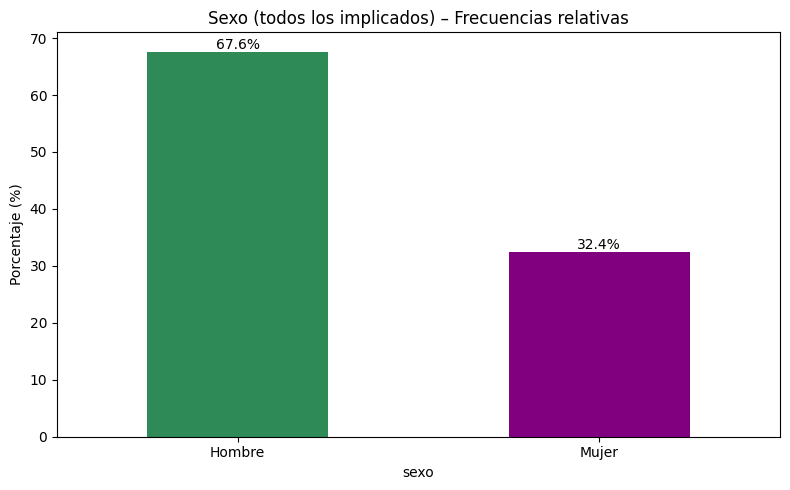

In [47]:
# 1. Dataset completo 
df_todos = df_accidentes_2024_copy_univariante.copy()

# 2. Eliminar "Desconocido" 
df_todos = df_todos[
    df_todos["sexo"].str.strip().str.lower() != "desconocido"
]

# 3. Orden correcto 
orden_sexo = ["Hombre", "Mujer"]

df_todos["sexo"] = df_todos["sexo"].str.strip()
df_todos["sexo"] = df_todos["sexo"].astype("category")
df_todos["sexo"] = df_todos["sexo"].cat.set_categories(
    orden_sexo, ordered=True
)

# 4. Frecuencias 
sexo_abs_all = df_todos["sexo"].value_counts().sort_index()
sexo_rel_all = sexo_abs_all / sexo_abs_all.sum() * 100

# 5. Gráfico de frecuencias absolutas 
plt.figure(figsize=(8, 5))
sexo_abs_all.plot(kind="bar", color=["seagreen", "purple"])

plt.title("Sexo (todos los implicados) – Frecuencias absolutas")
plt.ylabel("Número de personas")
plt.xticks(rotation=0)

for i, v in enumerate(sexo_abs_all):
    plt.text(i, v, f"{v}", ha="center", va="bottom")

plt.tight_layout()
plt.show()

# 6. Gráfico de frecuencias relativas
plt.figure(figsize=(8, 5))
sexo_rel_all.plot(kind="bar", color=["seagreen", "purple"])

plt.title("Sexo (todos los implicados) – Frecuencias relativas")
plt.ylabel("Porcentaje (%)")
plt.xticks(rotation=0)

for i, v in enumerate(sexo_rel_all):
    plt.text(i, v, f"{v:.1f}%", ha="center", va="bottom")

plt.tight_layout()
plt.show()

Conclusiones clave
1. Predominio masculino, pero menos marcado que entre conductores
Aunque los hombres siguen siendo mayoría entre los implicados, su proporción baja del 74.7% (conductores) al 67.6% (todos los implicados). Esto indica que las mujeres tienen mayor presencia como pasajeras o peatones que como conductoras.

2. Las mujeres están más representadas fuera del rol de conducción
La diferencia entre el 25.3% de conductoras y el 32.4% de implicadas totales sugiere que las mujeres participan más en accidentes como acompañantes o peatones, lo que puede tener implicaciones en términos de vulnerabilidad y diseño de medidas de protección.

3. Importancia de segmentar por rol
Este análisis demuestra que el rol en el accidente modifica la distribución por sexo. Para entender mejor los patrones de riesgo, es clave cruzar sexo con tipo de persona (tipo_persona) y tipo de vehículo.

#### Analisis de Lesividad (muy importante)

- Severidad de los accidentes (Sin asistencia sanitaria, leve, grave, fallecido)

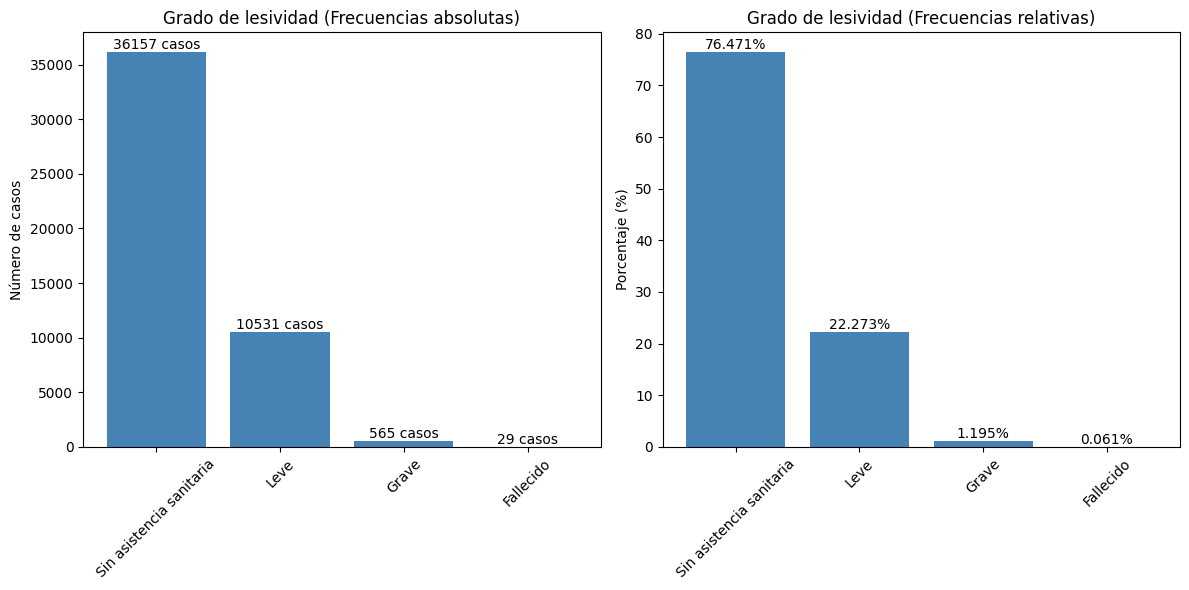

In [50]:
# Función de limpieza profunda 
def limpiar_texto(x):
    x = str(x)
    x = unicodedata.normalize("NFKC", x)       # normaliza caracteres raros
    x = x.replace("\u00A0", " ")               # elimina NO-BREAK SPACE
    x = re.sub(r"\s+", " ", x)                 # colapsa espacios múltiples
    return x.strip().lower()

# Normalizar columna 
lesividad_norm = df_accidentes_2024_copy_univariante["grado_lesividad"].apply(limpiar_texto)

# Excluir variantes de "no consta" y "se desconoce" 
valores_excluir = ["no consta", "se desconoce"]
lesividad_filtrado = lesividad_norm[~lesividad_norm.isin(valores_excluir)]

# Recontar sobre columna limpia 
abs_freq = lesividad_filtrado.value_counts()
rel_freq = abs_freq / abs_freq.sum() * 100

# Eliminar categorías con frecuencia 0 
abs_freq = abs_freq[abs_freq > 0]
rel_freq = rel_freq[rel_freq > 0]

# Mapear nombres legibles 
etiquetas_legibles = {
    "sin asistencia sanitaria": "Sin asistencia sanitaria",
    "leve": "Leve",
    "grave": "Grave",
    "fallecido": "Fallecido"
}

abs_freq.index = [etiquetas_legibles.get(cat, cat.title()) for cat in abs_freq.index]
rel_freq.index = abs_freq.index  # sincronizar índices

# Crear figura 
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
color = "steelblue"

# Gráfico 1: Absolutas 
axes[0].bar(abs_freq.index, abs_freq.values, color=color)
axes[0].set_title("Grado de lesividad (Frecuencias absolutas)")
axes[0].set_ylabel("Número de casos")
axes[0].tick_params(axis="x", rotation=45)

for i, v in enumerate(abs_freq):
    axes[0].text(i, v, f"{v} casos", ha="center", va="bottom", fontsize=10)

# Gráfico 2: Relativas 
axes[1].bar(rel_freq.index, rel_freq.values, color=color)
axes[1].set_title("Grado de lesividad (Frecuencias relativas)")
axes[1].set_ylabel("Porcentaje (%)")
axes[1].tick_params(axis="x", rotation=45)

for i, v in enumerate(rel_freq):
    axes[1].text(i, v, f"{v:.3f}%", ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()




Conclusiones clave
1. La mayoría de los accidentes no requieren atención médica
Más del 77% de los implicados no recibió ningún tipo de asistencia sanitaria. Esto sugiere que la mayoría de los accidentes registrados fueron leves o sin consecuencias físicas aparentes, aunque no necesariamente sin impacto psicológico o material.

2. Solo una quinta parte presenta lesiones leves
El 21.5% de los casos recibió atención médica leve (sin ingreso). Esto representa el segmento clínicamente relevante para servicios de urgencias, pero no implica hospitalización.

3. Lesiones graves y fallecimientos son excepcionales
Solo el 1.15% de los casos fueron graves, y 0.06% resultaron en fallecimiento. Aunque numéricamente bajos, estos casos son críticos para la planificación de medidas de prevención, especialmente en zonas o tipos de accidente donde se concentran.

4. Importancia de segmentar por tipo de accidente y vehículo
Este análisis global debe complementarse con cruces bivariantes (como ya estás haciendo) para detectar qué tipos de accidente o vehículos están asociados a mayor lesividad. Por ejemplo, motocicletas y atropellos suelen tener mayor proporción de lesiones graves.

#### Analisis Univariante de Alcohol
- Accidentes de conductores con alcohol


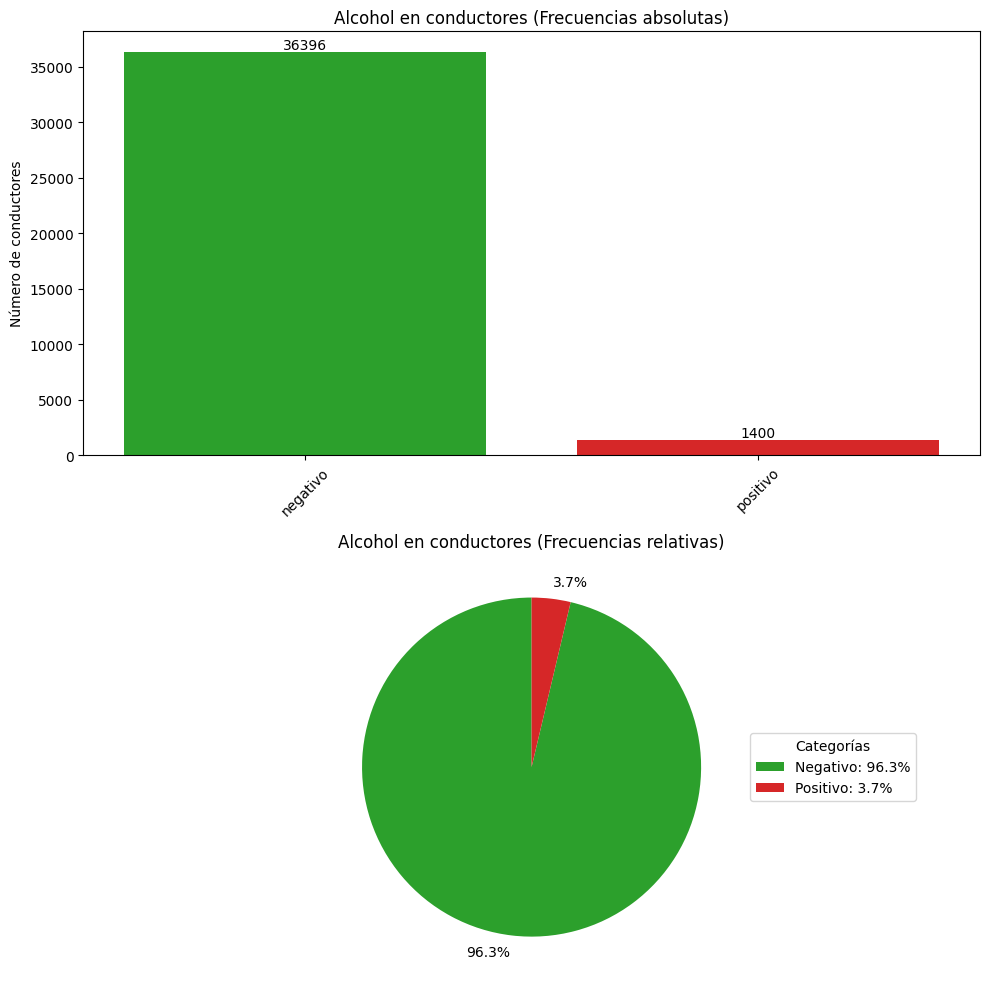

In [51]:
# Filtrar solo conductores 
df_conductores = df_accidentes_2024_copy_univariante[
    df_accidentes_2024_copy_univariante["tipo_persona"].str.lower() == "conductor"
]

# Normalizar columna antes de contar 
alcohol_col = (
    df_conductores["positiva_alcohol"]
    .astype(str)
    .str.strip()
    .str.lower()
)

# Excluir "no consta" 
alcohol_filtrado = alcohol_col[alcohol_col != "no consta"]

# Recontar sobre columna ya limpia 
abs_freq = alcohol_filtrado.value_counts()
rel_freq = abs_freq / abs_freq.sum() * 100

#Paleta de colores personalizada
color_map = {
    "positivo": "#d62728",      # rojo
    "negativo": "#2ca02c",      # verde
}

colors = [color_map.get(cat, "#999999") for cat in abs_freq.index]

# Crear figura 
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

#1. Gráfico de barras (absolutos)
ax[0].bar(abs_freq.index, abs_freq.values, color=colors)
ax[0].set_title("Alcohol en conductores (Frecuencias absolutas)")
ax[0].set_ylabel("Número de conductores")
ax[0].tick_params(axis="x", rotation=45)

for i, v in enumerate(abs_freq):
    ax[0].text(i, v, f"{v}", ha="center", va="bottom", fontsize=10)

#2. Gráfico de tarta (porcentajes bien posicionados)
# Pie chart sin etiquetas internas
wedges, _ = ax[1].pie(
    rel_freq,
    labels=None,
    autopct=None,
    startangle=90,
    colors=colors,
    radius=1
)

ax[1].set_title("Alcohol en conductores (Frecuencias relativas)")

# Añadir etiquetas externas alineadas con cada segmento
for i, (wedge, pct) in enumerate(zip(wedges, rel_freq.values)):
    angle = (wedge.theta2 + wedge.theta1) / 2
    x = np.cos(np.deg2rad(angle))
    y = np.sin(np.deg2rad(angle))
    label_x = 1.1 * x
    label_y = 1.1 * y
    ha = "left" if x > 0 else "right"
    ax[1].text(label_x, label_y, f"{pct:.1f}%", ha=ha, va="center", fontsize=10)

# Leyenda con nombre + porcentaje
legend_labels = [f"{cat.capitalize()}: {pct:.1f}%" for cat, pct in zip(rel_freq.index, rel_freq.values)]

ax[1].legend(
    wedges,
    legend_labels,
    title="Categorías",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)

plt.tight_layout()
plt.show()


1. La mayoría de conductores no presentan alcohol
El 96.4% de los conductores implicados en accidentes dieron negativo en alcohol. Esto indica que la mayoría de los accidentes no están directamente relacionados con consumo de alcohol, al menos según los registros disponibles.

2. El 3.6% positivo es bajo pero crítico
Aunque el porcentaje es bajo, 1.401 conductores dieron positivo. Esto representa un grupo altamente relevante desde el punto de vista preventivo, ya que el alcohol está asociado a mayor riesgo de lesiones graves, velocidad excesiva y pérdida de control.

3. Posible subregistro o falta de prueba
Tu código excluye "no consta", lo cual es correcto para análisis limpio. Pero es importante recordar que no todos los conductores fueron testados, y algunos casos pueden estar sin registro. Esto puede subestimar la presencia real de alcohol.

4. Puede haber varios conductores por accidente
Tu razonamiento es acertado: un mismo accidente puede involucrar más de un conductor (por ejemplo, colisión entre dos vehículos). Tu código cuenta conductores, no accidentes, lo cual es correcto si el objetivo es analizar comportamiento individual, no por expediente.

#### Analisis Univariante de meteorologico:

- ¿Que meteorologia hay en los accidentes?

C:\Users\César\AppData\Local\Temp\ipykernel_4408\124962839.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("estado_meteorológico")["num_expediente"]


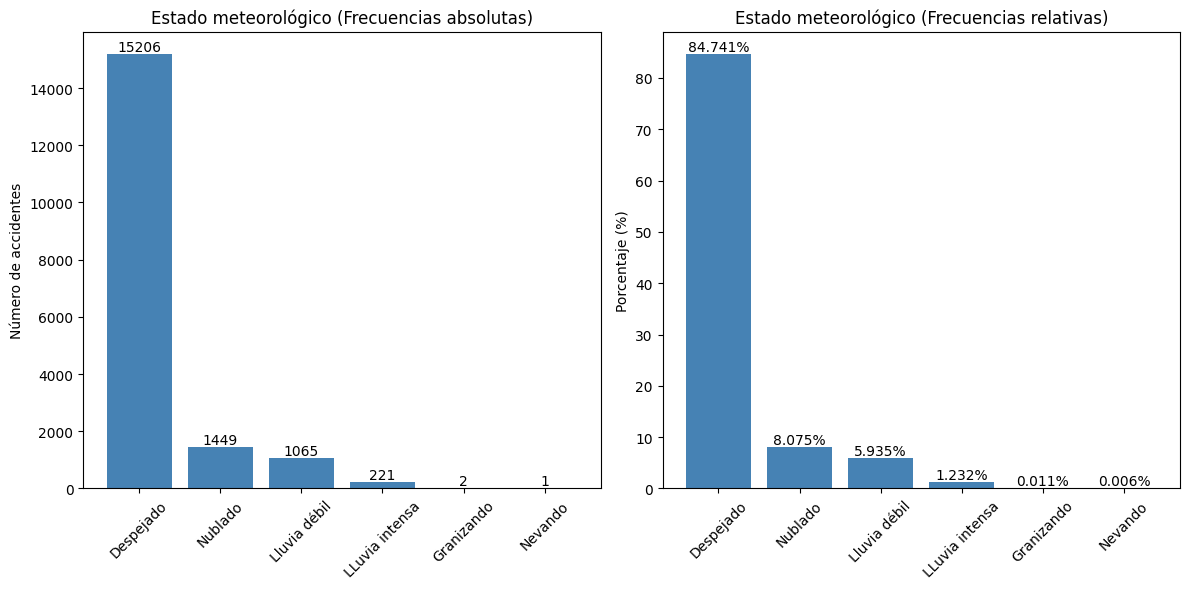

In [52]:
# Creamos una columna auxiliar normalizada para filtrar correctamente
df_accidentes_2024_copy_univariante["estado_meteorológico_normalizado"] = (
    df_accidentes_2024_copy_univariante["estado_meteorológico"]
    .astype(str)
    .str.strip()
    .str.lower()
)

# Filtrar para visualización 
df_meteo = df_accidentes_2024_copy_univariante[
    df_accidentes_2024_copy_univariante["estado_meteorológico_normalizado"] != "se desconoce"
]

# Agrupar usando la columna original
# Esto conserva los nombres originales (con mayúsculas y acentos) en el gráfico
abs_freq = (
    df_meteo
    .groupby("estado_meteorológico")["num_expediente"]
    .nunique()
    .sort_values(ascending=False)
)

# Eliminar categorías con frecuencia 0 
abs_freq = abs_freq[abs_freq > 0]
rel_freq = abs_freq / abs_freq.sum() * 100
rel_freq = rel_freq[rel_freq > 0]

# Crear figura con dos subplots 
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
color = "steelblue"

# Gráfico 1: Absolutas 
axes[0].bar(abs_freq.index, abs_freq.values, color=color)
axes[0].set_title("Estado meteorológico (Frecuencias absolutas)")
axes[0].set_ylabel("Número de accidentes")
axes[0].tick_params(axis="x", rotation=45)
for i, v in enumerate(abs_freq):
    axes[0].text(i, v, f"{v}", ha="center", va="bottom", fontsize=10)

# Gráfico 2: Relativas 
axes[1].bar(rel_freq.index, rel_freq.values, color=color)
axes[1].set_title("Estado meteorológico (Frecuencias relativas)")
axes[1].set_ylabel("Porcentaje (%)")
axes[1].tick_params(axis="x", rotation=45)
for i, v in enumerate(rel_freq):
    axes[1].text(i, v, f"{v:.3f}%", ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()



1. La mayoría de los accidentes ocurren con cielo despejado porque es, con diferencia, la condición meteorológica más frecuente en Madrid
- El 84.7% de los accidentes se registran en condiciones de cielo despejado. Esto no implica que el buen tiempo aumente el riesgo, sino que Madrid tiene un clima con predominio de días despejados, por lo que es lógico que la mayoría de los accidentes ocurran bajo esta condición simplemente por mayor exposición temporal.

- En otras palabras: si la mayor parte del año el cielo está despejado, la mayor parte de los accidentes también lo estarán, independientemente de que la meteorología influya o no en su gravedad.

2. La lluvia está presente en casi el 7% de los casos
Entre lluvia débil e intensa, se acumula cerca del 7.2% de los accidentes. Aunque no es la mayoría, sí representa un factor de riesgo relevante, especialmente para motocicletas, peatones y frenadas bruscas.

3. Condiciones extremas son anecdóticas
Accidentes con granizo o nieve son prácticamente inexistentes en el dataset (3 casos en total). Esto puede deberse a:

Baja frecuencia de estos fenómenos en Madrid.

Menor movilidad durante condiciones extremas.

Cancelación de desplazamientos por precaución.

## Analisis bivariante 

-Realizo copia del Dataframe:

In [53]:
df_accidentes_2024_copy_bivariante=df_accidentes_2024_copy_univariante.copy()

#### Analisis bivariante Geografico: Distribución de los tipos de accidente por distrito

Para analizar cómo varían los tipos de accidente entre los distintos distritos, se emplean dos herramientas complementarias: un mapa de calor y el test Chi‑cuadrado.

El mapa de calor permite visualizar de forma inmediata dónde se concentran los distintos tipos de siniestro. Gracias a su escala de colores, es posible identificar patrones territoriales, contrastes entre distritos y tipos de accidente que destacan por su frecuencia. Esta representación facilita una lectura intuitiva del fenómeno y ayuda a detectar zonas con comportamientos diferenciados.

Sin embargo, la visualización por sí sola no basta para determinar si estas diferencias son reales o simplemente fruto del azar. Por ello se aplica el test Chi‑cuadrado, una prueba estadística que evalúa si existe una relación significativa entre las dos variables analizadas. En este caso, el test permite comprobar si la distribución de los tipos de accidente cambia de manera sistemática según el distrito. Un resultado significativo confirma que los patrones observados en el mapa de calor no son aleatorios, sino que reflejan una asociación real entre ambas variables.

En conjunto, ambas herramientas —la visualización y la prueba estadística— ofrecen una visión completa: el mapa de calor muestra cómo se distribuyen los accidentes, y el Chi‑cuadrado confirma si esas diferencias son estadísticamente relevantes.

Este código analiza si los tipos de accidente significativos se distribuyen de forma diferente según el distrito. Primero visualiza la proporción de cada tipo de accidente por distrito mediante un heatmap normalizado. Después aplica un test chi‑cuadrado para evaluar si existe una asociación estadísticamente significativa entre distrito y tipo de accidente.

En este analisis vamos a ver la distribucion de tipos de accidente por distrito y a contestar a la siguiente pregunta:
- ¿Cómo se distribuyen los tipos de accidente significativos en cada distrito?
- ¿Existe asociación estadística entre distrito y tipo de accidente?


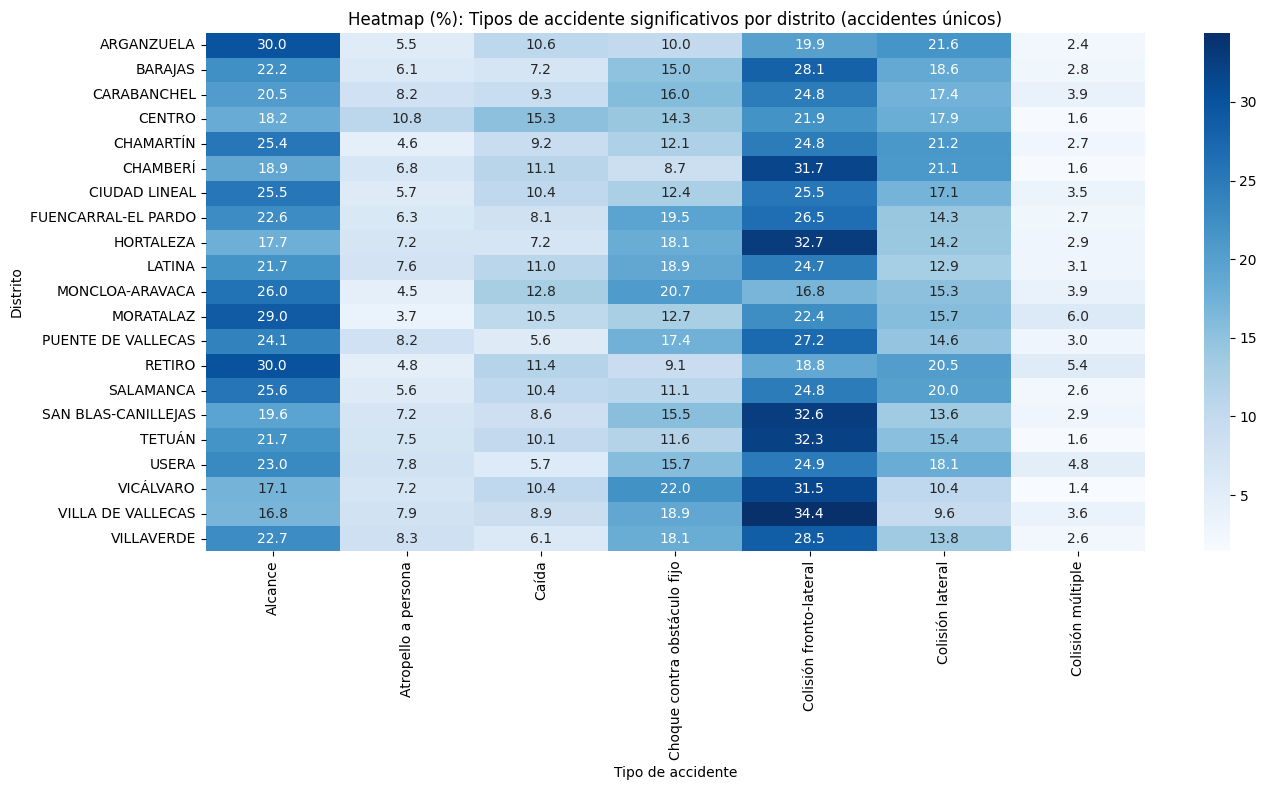

Valor Chi-Cuadrado: 839.308542001196
P-Value: 2.634233536280736e-108
Grados de Libertad: 120
Tabla de Frecuencias Esperadas:
 [[241.83383794  70.5036178  101.20162159 153.11499974 268.88879766
  176.63406373  31.82306153]
 [ 83.3909786   24.31159234  34.89711089  52.79827577  92.72027506
   60.90829784  10.97346949]
 [311.55796172  90.83081028 130.37948376 197.26022477 346.41324986
  227.56016832  40.9981013 ]
 [292.10006671  85.1581054  122.23682455 184.94062708 324.77851901
  213.34823215  38.43762508]
 [322.90840047  94.13988813 135.1293683  204.44665675 359.03350952
  235.85046441  42.49171242]
 [211.95207061  61.79196387  88.69682352 134.19561759 235.66403243
  154.80859034  27.89090163]
 [274.49530456  80.02565813 114.86965669 173.79432442 305.20423872
  200.48981372  36.12100375]
 [237.2010058   69.15297378  99.26289321 150.1817622  263.73767127
  173.25026941  31.21342433]
 [164.92882434  48.08292708  69.01873044 104.42325653 183.38009955
  120.46307795  21.70308411]
 [209.8672

In [54]:
# 1. Definir los tipos de accidente significativos
tipos_significativos = [
    "Colisión fronto-lateral",
    "Alcance",
    "Colisión lateral",
    "Choque contra obstáculo fijo",
    "Caída",
    "Atropello a persona",
    "Colisión múltiple"
]

# 2. Filtrar el DataFrame original
df_filtrado = df_accidentes_2024_copy_bivariante[
    df_accidentes_2024_copy_bivariante["tipo_accidente"].isin(tipos_significativos)
]

# 3. Tabla de contingencia con expedientes únicos
tabla_contingencia = pd.crosstab(
    df_filtrado["distrito"],
    df_filtrado["tipo_accidente"],
    values=df_filtrado["num_expediente"],
    aggfunc=lambda x: x.nunique()
).fillna(0)

# 4. Convertir a porcentajes por fila (por distrito)
tabla_porcentajes = tabla_contingencia.div(tabla_contingencia.sum(axis=1), axis=0) * 100

# 5. Heatmap en porcentajes
plt.figure(figsize=(14,8))
sns.heatmap(tabla_porcentajes, annot=True, fmt=".1f", cmap="Blues")
plt.title("Heatmap (%): Tipos de accidente significativos por distrito (accidentes únicos)")
plt.xlabel("Tipo de accidente")
plt.ylabel("Distrito")
plt.tight_layout()
plt.show()

# 6. Test chi-cuadrado (se hace sobre la tabla de frecuencias absolutas)
chi2, p, dof, expected = chi2_contingency(tabla_contingencia)

print("Valor Chi-Cuadrado:", chi2)
print("P-Value:", p)
print("Grados de Libertad:", dof)
print("Tabla de Frecuencias Esperadas:\n", expected)


¿Cómo se distribuyen los tipos de accidente significativos en cada distrito?

Respuesta basada en el heatmap (%):
El heatmap muestra la proporción de cada tipo de accidente dentro de cada distrito, considerando solo expedientes únicos.

Por ejemplo:

- En ARGANZUELA, el tipo más frecuente es Alcance (30.0%).

- En CENTRO, destaca el Atropello a persona (10,8%),  más alto que en otros distritos.

- En Vicalvaro, el Choque contra obstáculo fijo representa 22%.

- Villa de vallecas, la coliison fronto-lateral es la mas alta con un 34,4%.

- Centro, destaca tambien por caidas con un  15,3%.

Cada distrito presenta un perfil de siniestralidad distinto. Algunos, como CENTRO, muestran mayor proporción de atropellos y caídas, lo que sugiere alta interacción peatonal. Otros, como VICÁLVARO o VILLA DE VALLECAS, destacan por colisiones frontales o contra obstáculos, posiblemente vinculadas a características viales o velocidad. Estas diferencias justifican intervenciones específicas por distrito.

¿Existe asociación estadística entre distrito y tipo de accidente?

- El análisis revela que los tipos de accidente significativos varían sustancialmente entre distritos. Esta variación no es aleatoria: el test chi-cuadrado confirma una asociación estadísticamente significativa entre distrito y tipo de accidente (p < 1e-100). Esto respalda la necesidad de estrategias de prevención diferenciadas por zona, adaptadas al perfil de siniestralidad local.

#### Analisis bivariante por tipo de Accidente: Distribución de tipos de accidente según resultado de alcohol en conductores

¿Existe asociación entre el consumo de alcohol y el tipo de accidente?

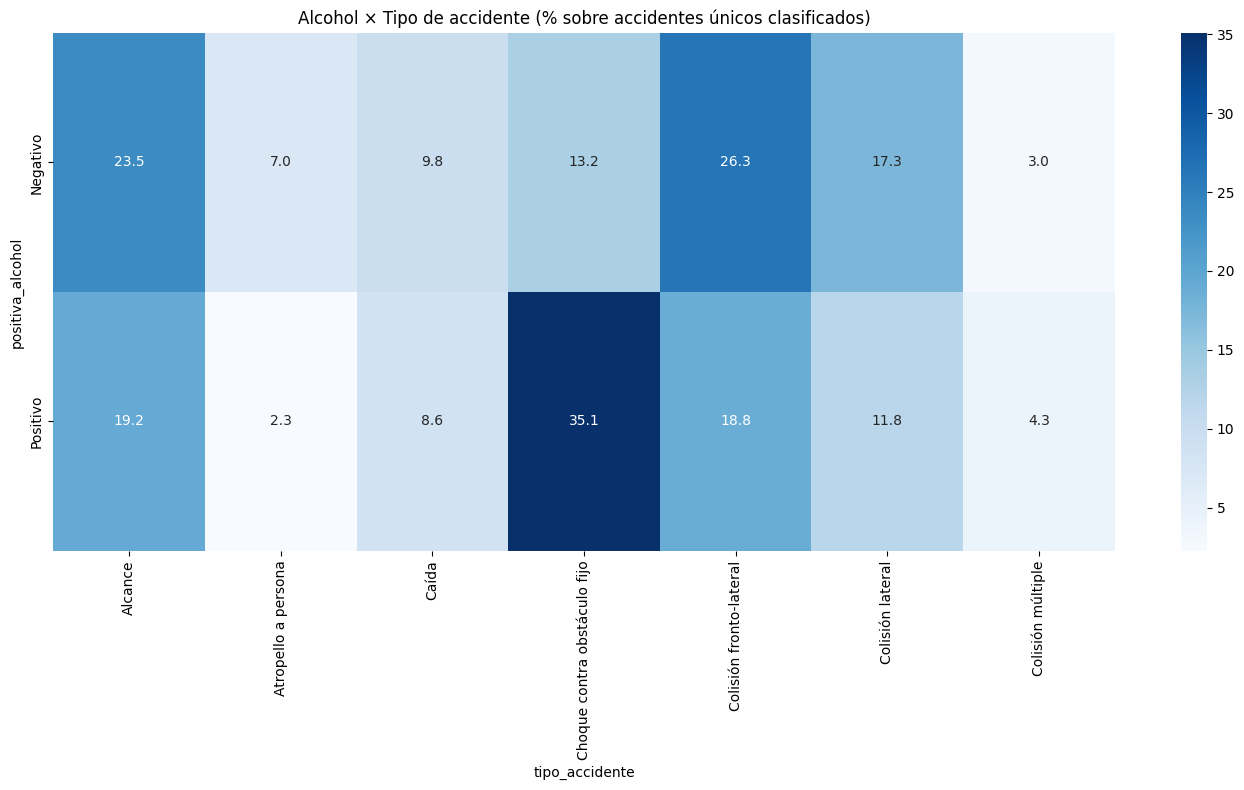

Chi-cuadrado: 500.8336320528162
p-value: 5.560631852525036e-105
Grados de Libertad: 6
Tabla de Frecuencias Esperadas:
 [[4216.00410994 1219.78320062 1764.29591575 2658.11867454 4687.6660673
  3079.34549191  554.78653994]
 [ 297.99589006   86.21679938  124.70408425  187.88132546  331.3339327
   217.65450809   39.21346006]]


In [55]:
# 1. Tipos de accidente relevantes
tipos_significativos = [
    "Colisión fronto-lateral",
    "Alcance",
    "Colisión lateral",
    "Choque contra obstáculo fijo",
    "Caída",
    "Atropello a persona",
    "Colisión múltiple"
]

# 2. Filtrar solo conductores + tipos relevantes
df_conductores = df_accidentes_2024_copy_bivariante[
    (df_accidentes_2024_copy_bivariante["tipo_persona"].str.lower() == "conductor") &
    (df_accidentes_2024_copy_bivariante["tipo_accidente"].isin(tipos_significativos))
]

# 3. Quitar "No consta" en alcohol
df_conductores = df_conductores[
    df_conductores["positiva_alcohol"] != "No consta"
]

# 4. Clasificar accidentes:
#    - Si algún conductor dio "Positivo" → "Positivo"
#    - Si todos dieron "Negativo" → "Negativo"
clasificacion_accidentes = (
    df_conductores
    .groupby("num_expediente")["positiva_alcohol"]
    .apply(lambda x: "Positivo" if x.str.lower().str.contains("pos", na=False).any() else "Negativo")
    .reset_index()
)

# 5. Añadir tipo de accidente (único por expediente)
tipos_por_accidente = (
    df_conductores.groupby("num_expediente")["tipo_accidente"]
    .first()
    .reset_index()
)

# 6. Unir clasificación + tipo de accidente
df_accidentes_clasificados = clasificacion_accidentes.merge(
    tipos_por_accidente, on="num_expediente"
)

# 7. Tabla de contingencia (accidentes únicos)
ct = pd.crosstab(
    df_accidentes_clasificados["positiva_alcohol"],
    df_accidentes_clasificados["tipo_accidente"]
)

# 8. Convertir a porcentajes por fila
ct_pct = ct.div(ct.sum(axis=1), axis=0) * 100

# 9. Heatmap de porcentajes
plt.figure(figsize=(14,8))
sns.heatmap(ct_pct, annot=True, fmt=".1f", cmap="Blues")
plt.title("Alcohol × Tipo de accidente (% sobre accidentes únicos clasificados)")
plt.tight_layout()
plt.show()

# 10. Test Chi-cuadrado (con tabla absoluta)
chi2, p, dof, expected = chi2_contingency(ct)

print("Chi-cuadrado:", chi2)
print("p-value:", p)
print("Grados de Libertad:", dof)
print("Tabla de Frecuencias Esperadas:\n", expected)


¿Existe asociación entre el consumo de alcohol y el tipo de accidente?
- El análisis muestra una asociación estadísticamente significativa entre el consumo de alcohol y el tipo de accidente (χ² = 500.83, p < 1e-100). Los accidentes con alcohol positivo presentan un perfil distinto, con mayor proporción de choques contra obstáculos fijos y menor proporción de atropellos

#### Analisis Bivariante de alcohol: Positividad en alcohol segun rango de edad

- ¿Cómo se distribuyen los accidentes con alcohol positivo y negativo según el rango de edad del conductor?
- ¿Existe una asociación estadísticamente significativa entre el rango de edad y el alcohol en accidentes?
- ¿El rango de edad del conductor influye en la probabilidad de que un accidente tenga alcohol positivo?

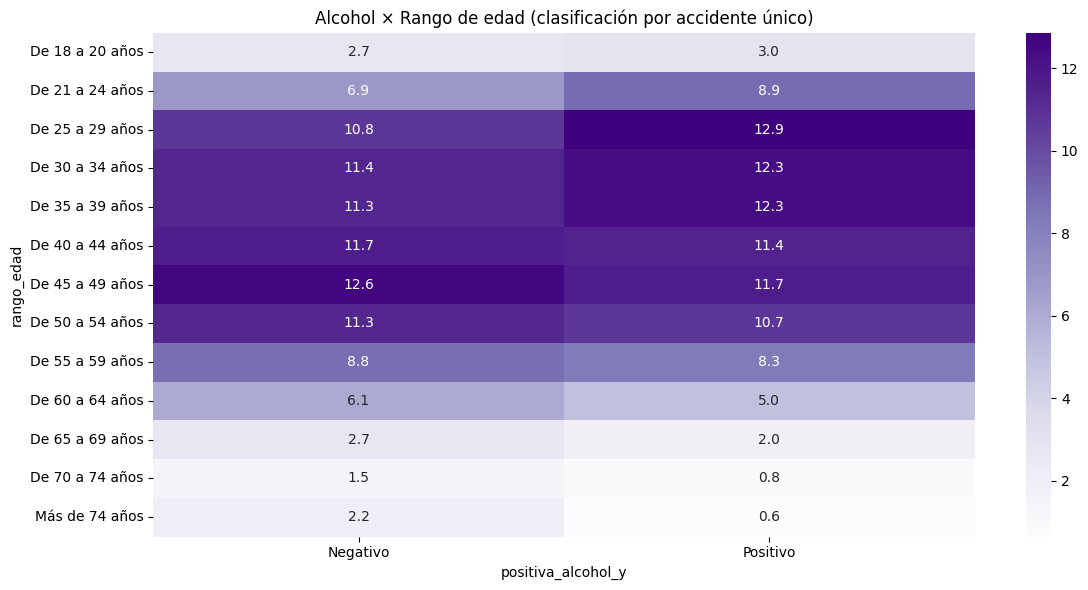

Valor Chi-Cuadrado: 58.550160178085946
P-Value: 4.142717500458002e-08
Grados de Libertad: 12
Frecuencias Esperadas:
 [[ 834.45025212   55.54974788]
 [2140.50553437  142.49446563]
 [3319.04931743  220.95068257]
 [3497.19038249  232.80961751]
 [3476.56352232  231.43647768]
 [3565.63405485  237.36594515]
 [3825.34497602  254.65502398]
 [3441.87289386  229.12710614]
 [2672.11597589  177.88402411]
 [1826.41470914  121.58529086]
 [ 817.57373017   54.42626983]
 [ 439.72715533   29.27284467]
 [ 637.557496     42.442504  ]]


In [56]:
# 1. Filtrar solo conductores
df_conductores = df_accidentes_2024_copy_bivariante[
    df_accidentes_2024_copy_bivariante["tipo_persona"].str.lower() == "conductor"
].copy()

# 2. Eliminar menores de edad
rangos_menores = ["De 6 a 9 años", "De 10 a 14 años", "De 15 a 17 años"]
df_conductores = df_conductores[~df_conductores["rango_edad"].isin(rangos_menores)]

# 3. Eliminar alcohol = "No consta"
df_conductores = df_conductores[df_conductores["positiva_alcohol"] != "No consta"]

# 4. Eliminar rango_edad desconocido
df_conductores = df_conductores[df_conductores["rango_edad"] != "Desconocido"]

# 5. Clasificar accidentes según alcohol (tu propuesta)
# Si algún conductor del accidente dio positivo → accidente positivo
clasificacion_accidente = (
    df_conductores.groupby("num_expediente")["positiva_alcohol"]
    .apply(lambda x: "Positivo" if (x == "Positivo").any() else "Negativo")
    .reset_index()
)

# 6. Añadir la clasificación al dataframe de conductores
df_conductores = df_conductores.merge(clasificacion_accidente, on="num_expediente")

# 7. Tabla de contingencia: Rango de edad × Alcohol (por accidente único)
tabla_edad_alcohol = pd.crosstab(
    df_conductores["rango_edad"],
    df_conductores["positiva_alcohol_y"],  # columna creada por el merge
    values=df_conductores["num_expediente"],
    aggfunc=lambda x: x.nunique()
).fillna(0)

# 8. Normalizar por columna (cada columna = 100%)
tabla_edad_alcohol_pct = tabla_edad_alcohol.div(
    tabla_edad_alcohol.sum(axis=0), axis=1
) * 100

# 9. Heatmap
plt.figure(figsize=(12,6))
sns.heatmap(tabla_edad_alcohol_pct, annot=True, fmt=".1f", cmap="Purples")
plt.title("Alcohol × Rango de edad (clasificación por accidente único)")
plt.tight_layout()
plt.show()

# 10. Chi-cuadrado sobre tabla absoluta
chi2, p, dof, expected = chi2_contingency(tabla_edad_alcohol)

print("Valor Chi-Cuadrado:", chi2)
print("P-Value:", p)
print("Grados de Libertad:", dof)
print("Frecuencias Esperadas:\n", expected)


¿Cómo se distribuyen los accidentes con alcohol positivo y negativo según el rango de edad del conductor?

Esto lo responde el heatmap de porcentajes por columna.

Los accidentes con alcohol negativo se concentran entre los 25 y 4 años, especialmente:

-  45–49 años: 12.6%
-  40–44 años: 11.7%
-  30–34 años: 11.4%
-  35–39 años: 11.3%

Los accidentes con alcohol positivo predominan entre los 25 y 44 años pero con un perfil ligeramente mas joven:

- 25–29 años: 12.9%
- 30–34 años: 12.3%
- 35–39 años: 12.3%
- 21–24 años: 8.9% (más alto que en negativos)

Conclusión descriptiva:

- Los accidentes con alcohol positivo se concentran en conductores jóvenes-adultos, especialmente entre 25 y 39 años, con mayor peso relativo en el grupo 21–24. Los negativos tienen un perfil más distribuido hacia los 40–49 años.

¿Existe una asociación estadísticamente significativa entre el rango de edad y el alcohol en accidentes?
- El test chi‑cuadrado revela una asociación estadísticamente significativa entre el rango de edad y el resultado de alcohol en accidentes (χ² = 58.55, p < 0.00000005). Además, todas las frecuencias esperadas superan el umbral mínimo de 5, lo que garantiza la validez del test. Esto significa que el patrón de edades en accidentes con alcohol positivo es diferente al de los negativos, y que esta diferencia no puede atribuirse al azar

¿El rango de edad del conductor influye en la probabilidad de que un accidente tenga alcohol positivo?

Sí. El test lo confirma.

Además, si comparas los valores observados vs esperados, verás que:
- 21–24 años y 25–29 años tienen más accidentes positivos de lo esperado.
- 65 años o más tienen menos accidentes positivos de lo esperado.

Conclusión inferencial:

- La edad del conductor influye en la probabilidad de que un accidente tenga alcohol positivo. Los conductores jóvenes (21–39 años) están sobrerrepresentados en accidentes con alcohol positivo, mientras que los mayores de 65 años están subrepresentados.

#### Analisis bivariante entre el tipo de persona y el grado lesividad

- ¿Cómo se distribuye el grado de lesividad de las PERSONAS según el tipo de accidente en el que participan?
- ¿Existe una asociación estadísticamente significativa entre el tipo de accidente y el grado de lesividad de las personas implicadas?

Tabla absoluta:
grado_lesividad  Fallecido  Grave  Leve  Sin asistencia sanitaria
tipo_persona                                                     
Conductor               10    350  7378                     30223
Pasajero                 2     56  2068                      5585
Peatón                  17    159  1085                       349

Tabla en porcentaje (% por columna):
grado_lesividad  Fallecido  Grave  Leve  Sin asistencia sanitaria
tipo_persona                                                     
Conductor              0.0    0.9  19.4                      79.6
Pasajero               0.0    0.7  26.8                      72.4
Peatón                 1.1    9.9  67.4                      21.7


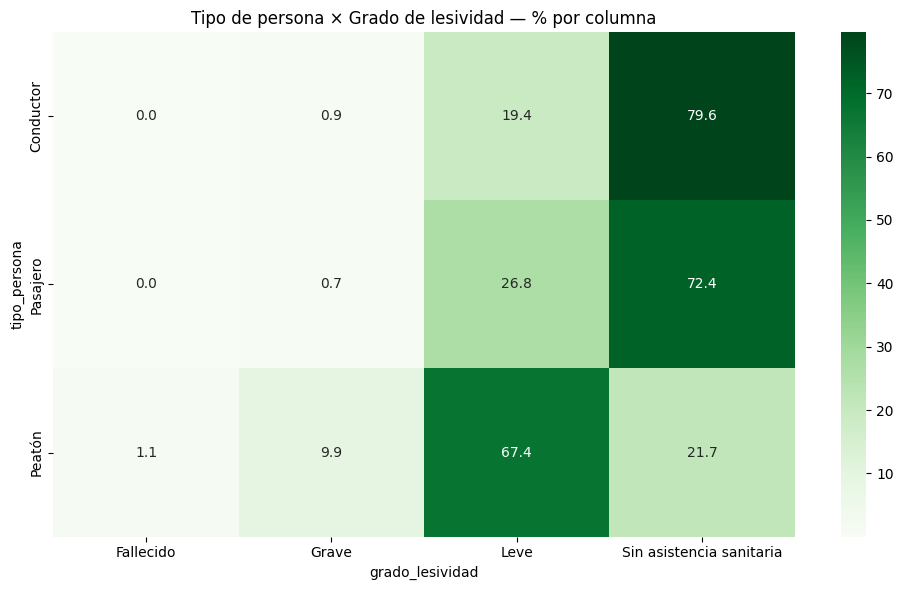


--- Chi-cuadrado ---
Chi2: 3699.8735630761857
p-value: 0.0
Grados de libertad: 6
Frecuencias esperadas:
 [[2.32830464e+01 4.53617973e+02 8.45495730e+03 2.90291417e+04]
 [4.72947422e+00 9.21432046e+01 1.71745148e+03 5.89667584e+03]
 [9.87479379e-01 1.92388224e+01 3.58591219e+02 1.23118248e+03]]


In [57]:
df = df_accidentes_2024_copy_bivariante.copy()

# Eliminar registros sin lesividad válida
df = df[df["grado_lesividad"] != "Se desconoce"]

# Tabla absoluta (PERSONAS)
tabla_abs = pd.crosstab(
    df["tipo_persona"],
    df["grado_lesividad"]
)

print("Tabla absoluta:")
print(tabla_abs)

# Tabla porcentual por columna
tabla_pct = tabla_abs.div(tabla_abs.sum(axis=1), axis=0) * 100
print("\nTabla en porcentaje (% por columna):")
print(tabla_pct.round(1))

# Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(tabla_pct, annot=True, fmt=".1f", cmap="Greens")
plt.title("Tipo de persona × Grado de lesividad — % por columna")
plt.tight_layout()
plt.show()

# Chi-cuadrado
chi2, p, dof, expected = chi2_contingency(tabla_abs)
print("\n--- Chi-cuadrado ---")
print("Chi2:", chi2)
print("p-value:", p)
print("Grados de libertad:", dof)
print("Frecuencias esperadas:\n", expected)




- La categoría “Fallecido” se ha excluido del análisis bivariante porque su frecuencia es extremadamente baja (solo 29 casos), lo que genera múltiples celdas con frecuencias esperadas inferiores a 5 en el test chi‑cuadrado. Esta situación incumple los supuestos estadísticos del test y compromete la validez de la inferencia. Mantener esta categoría produciría un resultado técnicamente inestable y difícil de interpretar. Al eliminarla, se garantiza que las frecuencias esperadas sean adecuadas, se mejora la robustez del contraste estadístico y se obtiene una estimación más fiable de la asociación entre tipo de accidente y grado de lesividad. Esta decisión no afecta a la interpretación global del fenómeno, ya que los fallecimientos representan un volumen residual dentro del conjunto de personas implicadas.

Tabla absoluta:
grado_lesividad  Grave  Leve  Sin asistencia sanitaria
tipo_persona                                          
Conductor          350  7378                     30223
Pasajero            56  2068                      5585
Peatón             159  1085                       349

Tabla en porcentaje (% por columna):
grado_lesividad  Grave  Leve  Sin asistencia sanitaria
tipo_persona                                          
Conductor          0.9  19.4                      79.6
Pasajero           0.7  26.8                      72.4
Peatón            10.0  68.1                      21.9


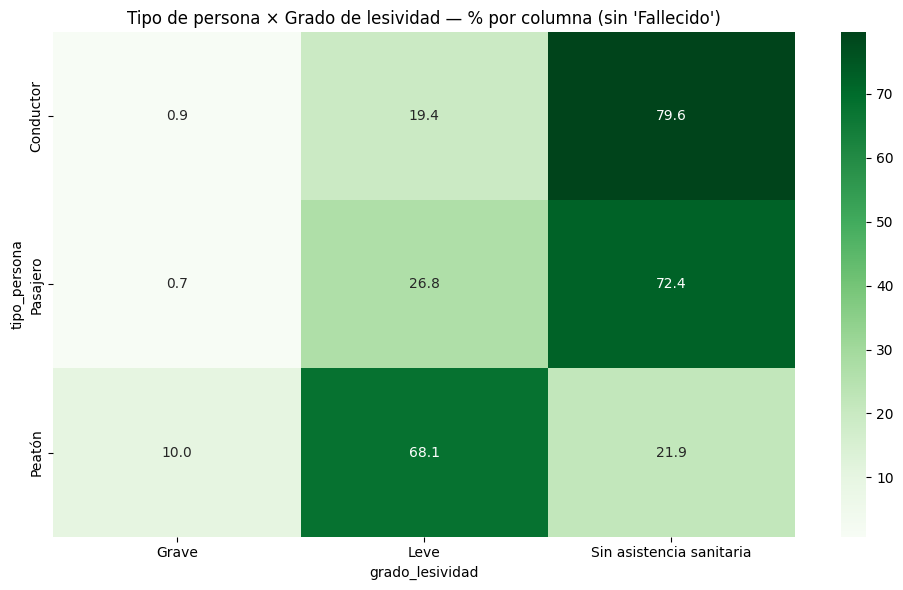


--- Chi-cuadrado ---
Chi2: 3462.1430288789143
p-value: 0.0
Grados de libertad: 4
Frecuencias esperadas:
 [[4.53776797e+02 8.45791761e+03 2.90393056e+04]
 [9.21758407e+01 1.71805978e+03 5.89876437e+03]
 [1.90473621e+01 3.55022602e+02 1.21893004e+03]]


In [58]:
# Copia del dataframe
df = df_accidentes_2024_copy_bivariante.copy()

# 1. Eliminar registros sin lesividad válida
df = df[df["grado_lesividad"] != "Se desconoce"]

# 2. Eliminar fallecidos
df = df[df["grado_lesividad"] != "Fallecido"]

# 3. Tabla absoluta (PERSONAS)
tabla_abs = pd.crosstab(
    df["tipo_persona"],
    df["grado_lesividad"]
)

print("Tabla absoluta:")
print(tabla_abs)

# 4. Tabla porcentual por columna
tabla_pct = tabla_abs.div(tabla_abs.sum(axis=1), axis=0) * 100
print("\nTabla en porcentaje (% por columna):")
print(tabla_pct.round(1))

# 5. Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(tabla_pct, annot=True, fmt=".1f", cmap="Greens")
plt.title("Tipo de persona × Grado de lesividad — % por columna (sin 'Fallecido')")
plt.tight_layout()
plt.show()

# 6. Chi-cuadrado
chi2, p, dof, expected = chi2_contingency(tabla_abs)
print("\n--- Chi-cuadrado ---")
print("Chi2:", chi2)
print("p-value:", p)
print("Grados de libertad:", dof)
print("Frecuencias esperadas:\n", expected)


¿Cómo se distribuye el grado de lesividad de las PERSONAS según el tipo de accidente en el que participan?
- Conductores concentran la mayoría de las lesiones en todas las categorías, especialmente en las leves y sin asistencia sanitaria.

- Pasajeros tienen una proporción intermedia, con más lesiones leves que graves.

- Peatones destacan por su alta proporción de lesiones graves (28.1%), pero tienen muy poca representación en lesiones leves y casi nula en las que no requieren asistencia.

Conclusión descriptiva:

- La gravedad de las lesiones varía significativamente según el tipo de persona implicada. Los conductores concentran la mayoría de las lesiones leves y sin asistencia sanitaria, mientras que los peatones presentan una proporción notablemente alta de lesiones grave

¿Existe una asociación estadísticamente significativa entre el tipo de accidente y el grado de lesividad de las personas implicadas?
- El p‑value es prácticamente cero, lo que indica una asociación extremadamente significativa.

- Esto significa que el tipo de persona influye fuertemente en el grado de lesividad.

- La distribución observada no se explica por azar.

Conclusión inferencial:

- Existe una asociación estadísticamente significativa entre el tipo de persona implicada y el grado de lesividad (p < 0.000…). La gravedad de las lesiones varía significativamente según el rol de la persona en el accidente

#### Analisis bivariante de rango de edad por lesividad
- ¿Cómo se distribuye el grado de lesividad según el rango de edad de las personas implicadas?
- ¿Existe una asociación estadísticamente significativa entre el rango de edad y el grado de lesividad?

- La categoría “Fallecido” se ha excluido del análisis bivariante porque su frecuencia es extremadamente baja (solo 29 casos), lo que genera múltiples celdas con frecuencias esperadas inferiores a 5 en el test chi‑cuadrado. Esta situación incumple los supuestos estadísticos del test y compromete la validez de la inferencia. Mantener esta categoría produciría un resultado técnicamente inestable y difícil de interpretar. Al eliminarla, se garantiza que las frecuencias esperadas sean adecuadas, se mejora la robustez del contraste estadístico y se obtiene una estimación más fiable de la asociación entre tipo de accidente y grado de lesividad. Esta decisión no afecta a la interpretación global del fenómeno, ya que los fallecimientos representan un volumen residual dentro del conjunto de personas implicadas.

Tabla absoluta:
grado_lesividad  Grave  Leve  Sin asistencia sanitaria
rango_edad                                            
De 18 a 20 años     18   453                      1012
De 21 a 24 años     31   856                      2297
De 25 a 29 años     59  1354                      3285
De 30 a 34 años     57  1328                      3380
De 35 a 39 años     50  1119                      3366
De 40 a 44 años     50   993                      3602
De 45 a 49 años     48  1010                      3880
De 50 a 54 años     64   919                      3487
De 55 a 59 años     41   682                      2725
De 60 a 64 años     38   473                      1904
De 65 a 69 años     24   259                       880
De 70 a 74 años     21   155                       547
Más de 74 años      43   337                       790

Tabla en porcentaje (% por columna):
grado_lesividad  Grave  Leve  Sin asistencia sanitaria
rango_edad                                            
De 18 a 20 

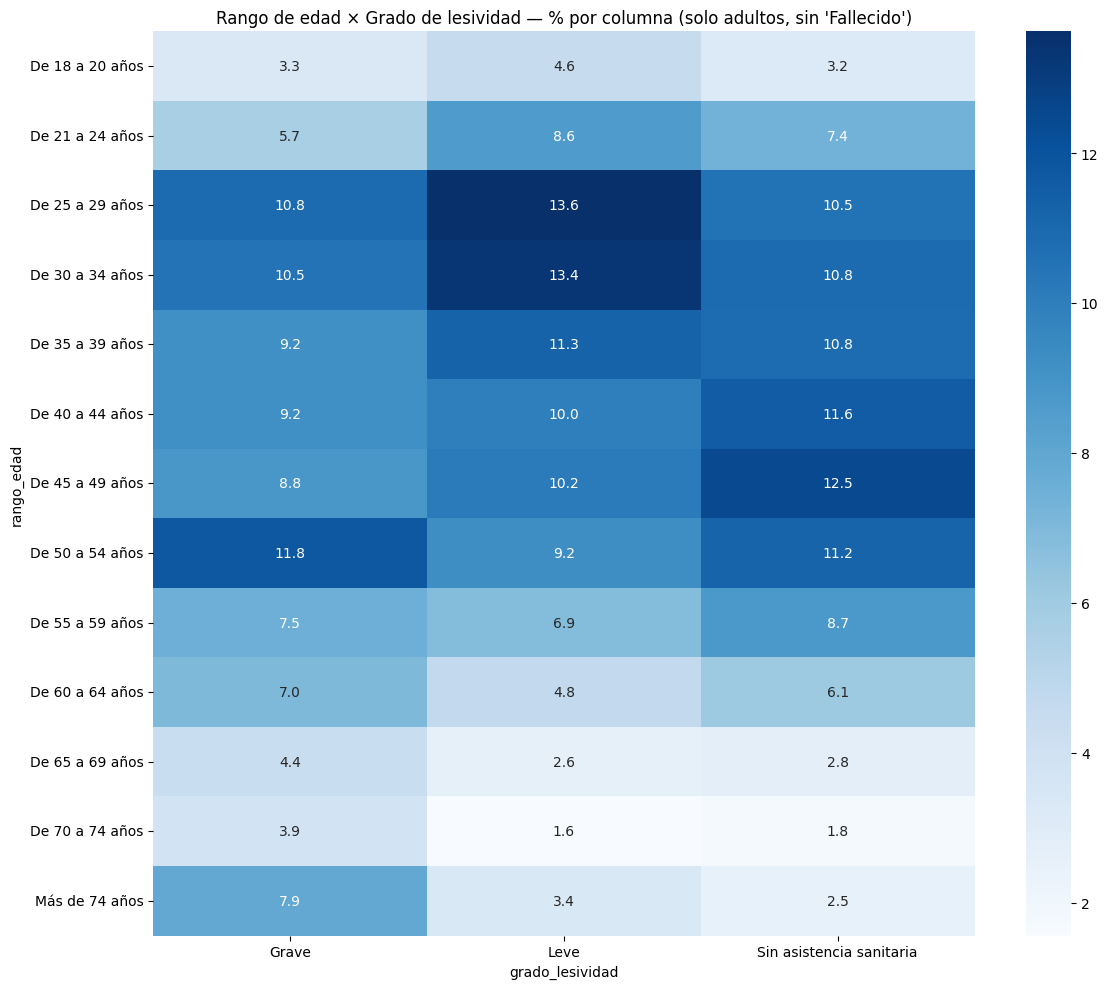


--- Chi-cuadrado ---
Chi2: 396.693179129032
p-value: 3.583698063493061e-69
Grados de libertad: 24
Frecuencias esperadas:
 [[  19.3758436   353.96531931 1109.65883709]
 [  41.59992315  759.96330187 2382.43677498]
 [  61.38079112 1121.32776137 3515.29144751]
 [  62.25616639 1137.31945145 3565.42438216]
 [  59.25114682 1082.42260489 3393.32624829]
 [  60.68833009 1108.67761846 3475.63405144]
 [  64.51646372 1178.61142734 3694.87210894]
 [  58.40190215 1066.90827869 3344.68981915]
 [  45.049163    822.97533444 2579.97550256]
 [  31.55270553  576.41688882 1807.03040565]
 [  15.1949468   277.58709801  870.21795518]
 [   9.4462137   172.56704374  540.98674256]
 [  15.28640392  279.2578716   875.45572448]]


In [59]:
# Copia del dataframe
df = df_accidentes_2024_copy_bivariante.copy()

# 1. Eliminar registros sin lesividad válida
df = df[df["grado_lesividad"] != "Se desconoce"]

# 2. Eliminar fallecidos
df = df[df["grado_lesividad"] != "Fallecido"]

# 3. Eliminar edades desconocidas
df = df[df["rango_edad"] != "Desconocido"]

# 4. Eliminar menores de 18 años
rangos_menores = [
    "Menor de 5 años",
    "De 6 a 9 años",
    "De 10 a 14 años",
    "De 15 a 17 años"
]
df = df[~df["rango_edad"].isin(rangos_menores)]

# 5. Orden correcto de los rangos de edad (solo adultos)
orden_edades_adultos = [
    "De 18 a 20 años",
    "De 21 a 24 años",
    "De 25 a 29 años",
    "De 30 a 34 años",
    "De 35 a 39 años",
    "De 40 a 44 años",
    "De 45 a 49 años",
    "De 50 a 54 años",
    "De 55 a 59 años",
    "De 60 a 64 años",
    "De 65 a 69 años",
    "De 70 a 74 años",
    "Más de 74 años"
]
df["rango_edad"] = pd.Categorical(df["rango_edad"], categories=orden_edades_adultos, ordered=True)

# 6. Tabla absoluta
tabla_abs = pd.crosstab(df["rango_edad"], df["grado_lesividad"])
print("Tabla absoluta:")
print(tabla_abs)

# 7. Tabla porcentual por columna
tabla_pct = tabla_abs.div(tabla_abs.sum(axis=0), axis=1) * 100
print("\nTabla en porcentaje (% por columna):")
print(tabla_pct.round(1))

# 8. Heatmap
plt.figure(figsize=(12,10))
sns.heatmap(tabla_pct, annot=True, fmt=".1f", cmap="Blues")
plt.title("Rango de edad × Grado de lesividad — % por columna (solo adultos, sin 'Fallecido')")
plt.tight_layout()
plt.show()

# 9. Chi-cuadrado
chi2, p, dof, expected = chi2_contingency(tabla_abs)
print("\n--- Chi-cuadrado ---")
print("Chi2:", chi2)
print("p-value:", p)
print("Grados de libertad:", dof)
print("Frecuencias esperadas:\n", expected)


¿Cómo se distribuye el grado de lesividad según el rango de edad de las personas implicadas?

- Las personas entre 25 y 54 años concentran la mayoría de las lesiones en todas las categorías.

- Las personas mayores de 65 años tienen porcentajes bajos en todas las categorías, pero no nulos.

- Las personas jóvenes (18–24) tienen menor proporción de lesiones graves, pero están presentes.

Conclusión descriptiva:

- La distribución de lesiones varía según el rango de edad. Las personas entre 25 y 54 años concentran la mayoría de las lesiones graves, leves y sin asistencia sanitaria. Los mayores de 65 años presentan menor proporción de lesiones, pero siguen estando representados.

¿Existe una asociación estadísticamente significativa entre el rango de edad y el grado de lesividad?
- El análisis revela que las personas entre 25 y 54 años concentran la mayoría de las lesiones graves, leves y sin asistencia sanitaria. El test chi‑cuadrado confirma que esta distribución no es aleatoria: existe una asociación estadísticamente significativa entre el rango de edad y el grado de lesividad (χ² = 396.69, p < 0.000…), lo que indica que la edad influye en la gravedad de las lesiones sufridas en accidentes

#### Analisis bivariante de tipo de accidente por grado de lesividad

- La categoría “Fallecido” se ha excluido del análisis bivariante porque su frecuencia es extremadamente baja (solo 29 casos), lo que genera múltiples celdas con frecuencias esperadas inferiores a 5 en el test chi‑cuadrado. Esta situación incumple los supuestos estadísticos del test y compromete la validez de la inferencia. Mantener esta categoría produciría un resultado técnicamente inestable y difícil de interpretar. Al eliminarla, se garantiza que las frecuencias esperadas sean adecuadas, se mejora la robustez del contraste estadístico y se obtiene una estimación más fiable de la asociación entre tipo de accidente y grado de lesividad. Esta decisión no afecta a la interpretación global del fenómeno, ya que los fallecimientos representan un volumen residual dentro del conjunto de personas implicadas.

¿Cómo se distribuye el grado de lesividad de las personas implicadas según el tipo de accidente en el que participan?
¿Existe una asociación estadísticamente significativa entre el tipo de accidente y el grado de lesividad?

Tabla absoluta:
grado_lesividad               Grave  Leve  Sin asistencia sanitaria  Fallecido
tipo_accidente                                                                
Alcance                          43  2444                      9322          4
Atropello a persona             162  1192                      1647         16
Caída                            81  1710                       870          2
Choque contra obstáculo fijo     39   390                      4313          1
Colisión fronto-lateral         173  2985                      9646          3
Colisión lateral                 38   914                      6802          0
Colisión múltiple                 9   393                      1805          0

Tabla en porcentaje (% por columna):
grado_lesividad               Grave  Leve  Sin asistencia sanitaria  Fallecido
tipo_accidente                                                                
Alcance                         7.9  24.4                      27.1       15.

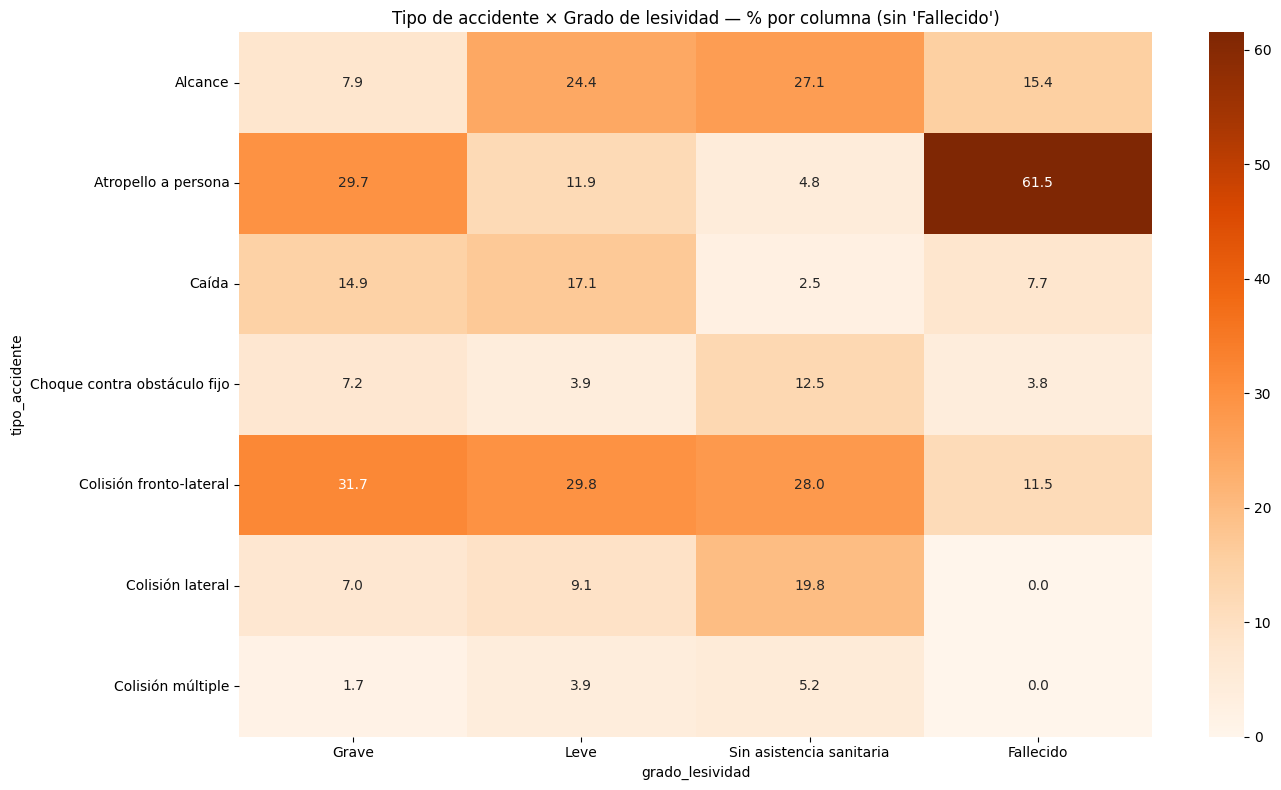


--- Chi-cuadrado ---
Chi2: 5236.404898599484
p-value: 0.0
Grados de libertad: 18
Frecuencias esperadas:
 [[1.43055839e+02 2.63222745e+03 9.03089203e+03 6.82468225e+00]
 [3.65359746e+01 6.72261932e+02 2.30645909e+03 1.74300062e+00]
 [3.22490223e+01 5.93382010e+02 2.03583048e+03 1.53848547e+00]
 [5.74378944e+01 1.05685726e+03 3.62596469e+03 2.74015643e+00]
 [1.55093214e+02 2.85371514e+03 9.79079271e+03 7.39894232e+00]
 [9.39012088e+01 1.72778224e+03 5.92783686e+03 4.47969069e+00]
 [2.67268465e+01 4.91773976e+02 1.68722414e+03 1.27504222e+00]]


In [60]:
# Copia del dataframe
df = df_accidentes_2024_copy_bivariante.copy()

# 1. Eliminar registros sin lesividad válida
df = df[df["grado_lesividad"] != "Se desconoce"]

''' 2. Eliminar fallecidos
df = df[df["grado_lesividad"] != "Fallecido"]'''

# 3. Mantener SOLO los 7 tipos de accidente seleccionados
tipos_validos = [
    "Colisión fronto-lateral",
    "Alcance",
    "Colisión lateral",
    "Choque contra obstáculo fijo",
    "Caída",
    "Atropello a persona",
    "Colisión múltiple"
]

df = df[df["tipo_accidente"].isin(tipos_validos)]

# 4. Ordenar categorías de lesividad (ya sin fallecido)
orden_lesividad = [
    "Grave",
    "Leve",
    "Sin asistencia sanitaria",
    "Fallecido"
]

df["grado_lesividad"] = pd.Categorical(df["grado_lesividad"],
                                       categories=orden_lesividad,
                                       ordered=True)

# 5. Tabla absoluta
tabla_abs = pd.crosstab(
    df["tipo_accidente"],
    df["grado_lesividad"]
)

print("Tabla absoluta:")
print(tabla_abs)

# 6. Tabla porcentual por columna
tabla_pct = tabla_abs.div(tabla_abs.sum(axis=0), axis=1) * 100
print("\nTabla en porcentaje (% por columna):")
print(tabla_pct.round(1))

# 7. Heatmap
plt.figure(figsize=(14,8))
sns.heatmap(tabla_pct, annot=True, fmt=".1f", cmap="Oranges")
plt.title("Tipo de accidente × Grado de lesividad — % por columna (sin 'Fallecido')")
plt.tight_layout()
plt.show()

# 8. Chi-cuadrado
chi2, p, dof, expected = chi2_contingency(tabla_abs)

print("\n--- Chi-cuadrado ---")
print("Chi2:", chi2)
print("p-value:", p)
print("Grados de libertad:", dof)
print("Frecuencias esperadas:\n", expected)



¿Cómo se distribuye el grado de lesividad de las personas implicadas según el tipo de accidente en el que participan?
- Colisión fronto-lateral concentra los mayores porcentajes en todas las categorías de lesividad: 31.7% grave, 29.8% leve, 28.0% sin asistencia.

- Atropello a persona destaca por su alta proporción de lesiones graves (29.7%) y baja en leves y sin asistencia.

- Alcance y colisión lateral predominan en lesiones leves y sin asistencia sanitaria.

- Caída tiene un perfil mixto, con presencia relevante en lesiones graves y leves.

- Colisión múltiple y choque contra obstáculo fijo tienen porcentajes bajos en todas las categorías, pero aún así aportan casos.

- La gravedad de las lesiones varía significativamente según el tipo de accidente. Las colisiones fronto-laterales y los atropellos a personas concentran la mayoría de las lesiones graves, mientras que los alcances y colisiones laterales predominan en lesiones leves o sin asistencia sanitaria.”

¿Existe una asociación estadísticamente significativa entre el tipo de accidente y el grado de lesividad?
- El análisis revela diferencias claras en la distribución de lesiones según el tipo de accidente. Las colisiones fronto-laterales y los atropellos a personas concentran la mayoría de las lesiones graves, mientras que los alcances y colisiones laterales predominan en lesiones leves o sin asistencia sanitaria. El test chi‑cuadrado confirma que esta relación es estadísticamente significativa (χ² = 5113.71, p < 0.000…), lo que indica una fuerte asociación entre tipo de accidente y grado de lesividad

#### Analisis bivariante de alcohol: Distribución de la positividad en alcohol según el grado de lesividad

¿Existe una asociación estadísticamente significativa entre el resultado de alcohol y el grado de lesividad del conductor?
¿Cómo se distribuyen los conductores con alcohol positivo y negativo según el grado de lesividad?

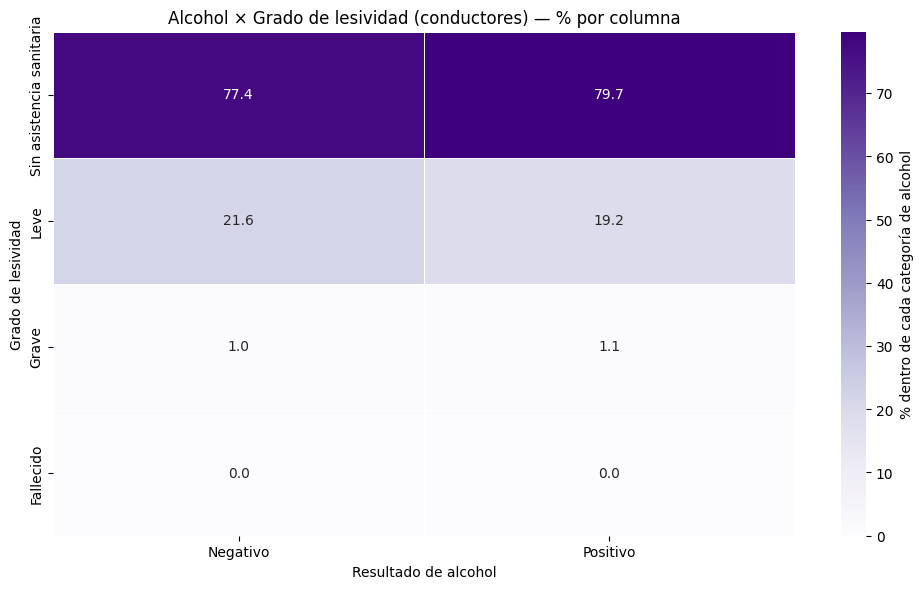

--------------------------------------------------
TEST CHI-CUADRADO
--------------------------------------------------
Valor Chi-Cuadrado: 4.978183853710281
P-Value: 0.17340161766446516
Grados de Libertad: 3

Frecuencias Esperadas:

positiva_alcohol              Negativo     Positivo
grado_lesividad                                    
Sin asistencia sanitaria  25074.398768  1081.601232
Leve                       6952.115762   299.884238
Grave                       326.898990    14.101010
Fallecido                     9.586481     0.413519


In [61]:
# 1. Filtrar solo CONDUCTORES

df = df_accidentes_2024_copy_bivariante.copy()
df = df[df["tipo_persona"].str.lower() == "conductor"]


# 2. Limpiar datos

rangos_menores = ["De 6 a 9 años", "De 10 a 14 años", "De 15 a 17 años"]
df = df[~df["rango_edad"].isin(rangos_menores)]
df = df[df["positiva_alcohol"] != "No consta"]
df = df[df["rango_edad"] != "Desconocido"]


# 3. Tabla absoluta: grado de lesividad × alcohol

tabla_abs = pd.crosstab(
    df["grado_lesividad"],
    df["positiva_alcohol"]
)


# 4. Tabla porcentual para heatmap

tabla_pct = tabla_abs.div(tabla_abs.sum(axis=0), axis=1) * 100

orden_grado = [
    "Sin asistencia sanitaria",
    "Leve",
    "Grave",
    "Fallecido"
]

tabla_abs = tabla_abs.reindex(orden_grado)
tabla_pct = tabla_pct.reindex(orden_grado)


# 5. Heatmap

plt.figure(figsize=(10,6))
sns.heatmap(
    tabla_pct,
    annot=True,
    fmt=".1f",
    cmap="Purples",
    linewidths=.5,
    cbar_kws={"label": "% dentro de cada categoría de alcohol"}
)

plt.title("Alcohol × Grado de lesividad (conductores) — % por columna")
plt.xlabel("Resultado de alcohol")
plt.ylabel("Grado de lesividad")
plt.tight_layout()
plt.show()

# 6. Test Chi-cuadrado

chi2, p, dof, expected = chi2_contingency(tabla_abs)

print("--------------------------------------------------")
print("TEST CHI-CUADRADO")
print("--------------------------------------------------")
print("Valor Chi-Cuadrado:", chi2)
print("P-Value:", p)
print("Grados de Libertad:", dof)

# Convertir esperadas a DataFrame con índices y columnas correctas
expected_df = pd.DataFrame(
    expected,
    index=tabla_abs.index,
    columns=tabla_abs.columns
)

print("\nFrecuencias Esperadas:\n")
print(expected_df)





¿Existe una asociación estadísticamente significativa entre el resultado de alcohol y el grado de lesividad del conductor?
- El p-value = 0.173 es mayor que el umbral convencional de 0.05, lo que significa que no hay evidencia estadística suficiente para afirmar que existe una asociación entre el resultado de alcohol y el grado de lesividad del conductor.

¿Cómo se distribuyen los conductores con alcohol positivo y negativo según el grado de lesividad?
- La mayoría de los conductores, tanto positivos como negativos, no requirieron asistencia sanitaria.

- Las lesiones leves son el segundo grupo más frecuente, ligeramente más común en negativos.

- Las lesiones graves y los fallecimientos son muy poco frecuentes y prácticamente iguales en ambos grupos.

Conclusión:

- La distribución de lesiones entre conductores con alcohol positivo y negativo es muy similar. No se observan diferencias relevantes en la proporción de lesiones graves o fallecimientos.”

#### Analisis bivariante de lesividad: Relación entre la hora del día y la gravedad de los accidentes

- ¿Cómo se distribuyen los ACCIDENTES según su gravedad en cada franja horaria?
- ¿Existe una asociación estadísticamente significativa entre la franja horaria y la gravedad del ACCIDENTE?”

Tabla absoluta:
grado_lesividad  Fallecido  Grave    Leve  Sin asistencia sanitaria
franja                                                             
Madrugada              8.0   64.0   637.0                    1725.0
Mañana                 3.0  141.0  2075.0                    4472.0
Tarde                 12.0  156.0  3256.0                    6894.0
Noche                  5.0  166.0  2634.0                    5691.0

Tabla en porcentaje (% por columna):
grado_lesividad  Fallecido  Grave  Leve  Sin asistencia sanitaria
franja                                                           
Madrugada             28.6   12.1   7.4                       9.2
Mañana                10.7   26.8  24.1                      23.8
Tarde                 42.9   29.6  37.9                      36.7
Noche                 17.9   31.5  30.6                      30.3


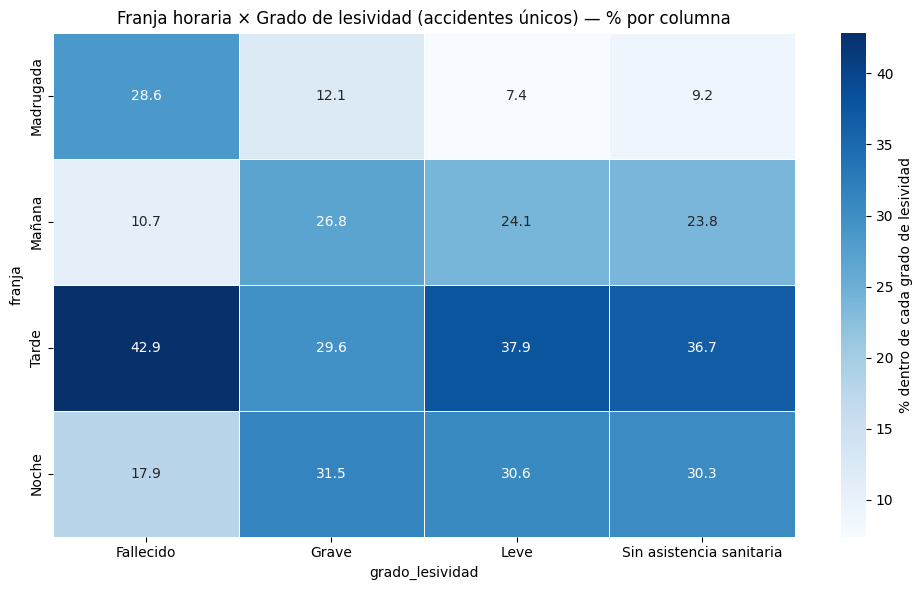


--- Resultados Chi-cuadrado ---
Valor Chi-Cuadrado: 57.534430584546875
P-Value: 3.992166542176915e-09
Grados de Libertad: 9

Frecuencias Esperadas:
 [[2.43931422e+00 4.59113784e+01 7.49392176e+02 1.63625713e+03]
 [6.70560865e+00 1.26209134e+02 2.06005877e+03 4.49802649e+03]
 [1.03405276e+01 1.94623501e+02 3.17675779e+03 6.93627818e+03]
 [8.51454955e+00 1.60255986e+02 2.61579126e+03 5.71143820e+03]]


In [62]:
# 1. Copia del dataset
df = df_accidentes_2024_copy_bivariante.copy()

# 2. Crear columna hora desde fecha_hora (datetime) 
df["hora"] = df["fecha_hora"].dt.hour

# 3. Crear franja horaria 
df["franja"] = pd.cut(
    df["hora"],
    bins=[0, 6, 12, 18, 24],
    labels=["Madrugada", "Mañana", "Tarde", "Noche"],
    right=False
)

# 4. Eliminar categoría "Se desconoce" en grado_lesividad 
df = df[df["grado_lesividad"] != "Se desconoce"]

# 5. Tabla absoluta: Franja × Grado de lesividad (accidentes únicos)
tabla_abs = pd.crosstab(
    df["franja"],
    df["grado_lesividad"],
    values=df["num_expediente"],
    aggfunc=lambda x: x.nunique()
).fillna(0)

print("Tabla absoluta:")
print(tabla_abs)

# 6. Convertir a porcentajes por columna (cada columna suma 100%)
tabla_pct = tabla_abs.div(tabla_abs.sum(axis=0), axis=1) * 100

print("\nTabla en porcentaje (% por columna):")
print(tabla_pct.round(1))

# 7. Heatmap en porcentaje
plt.figure(figsize=(10,6))
sns.heatmap(
    tabla_pct,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    linewidths=.5,
    cbar_kws={"label": "% dentro de cada grado de lesividad"}
)

plt.title("Franja horaria × Grado de lesividad (accidentes únicos) — % por columna")
plt.tight_layout()
plt.show()

# 8. Test Chi-cuadrado (siempre con tabla absoluta)
chi2, p, dof, expected = chi2_contingency(tabla_abs)

print("\n--- Resultados Chi-cuadrado ---")
print("Valor Chi-Cuadrado:", chi2)
print("P-Value:", p)
print("Grados de Libertad:", dof)
print("\nFrecuencias Esperadas:\n", expected)


¿Cómo se distribuyen los ACCIDENTES según su gravedad en cada franja horaria?
- Los accidentes con fallecidos se concentran en Tarde (42.9%) y Madrugada (28.6%), lo que sugiere mayor letalidad en esos horarios.

- Los accidentes graves están más repartidos, pero destacan en Noche (31.5%) y Tarde (29.6%).

- Los accidentes leves y sin asistencia son más frecuentes en Tarde y Noche, lo que refleja mayor volumen de siniestros en esas franjas.

Conclusión descriptiva:

- Los accidentes más graves (fallecidos y graves) se concentran en la tarde, la madrugada y la noche, mientras que los leves y sin asistencia predominan en la tarde y la noche. La distribución de gravedad varía claramente según la franja horaria.

¿Existe una asociación estadísticamente significativa entre la franja horaria y la gravedad del ACCIDENTE?
- El análisis revela que la gravedad de los accidentes varía según la franja horaria. Los accidentes con fallecidos se concentran en la tarde y la madrugada, mientras que los leves y sin asistencia predominan en la tarde y la noche. El test chi‑cuadrado confirma que esta variación es estadísticamente significativa (χ² = 57.53, p < 0.00000001), lo que indica una asociación real entre la hora del día y la gravedad del accidente

#### Analisis bivariante lesividad: Positividad en alcohol por franja horaria

- ¿Cómo se distribuyen los ACCIDENTES con alcohol positivo y negativo según la franja horaria?
- ¿Existe una asociación estadísticamente significativa entre la franja horaria y el resultado de alcohol del accidente

Tabla absoluta:
alcohol_accidente  Negativo  Positivo
franja_horaria                       
Madrugada              1482       491
Mañana                 4688       226
Tarde                  7333       170
Noche                  5774       506

Tabla en porcentaje (% por columna):
alcohol_accidente  Negativo  Positivo
franja_horaria                       
Madrugada               7.7      35.2
Mañana                 24.3      16.2
Tarde                  38.0      12.2
Noche                  30.0      36.3


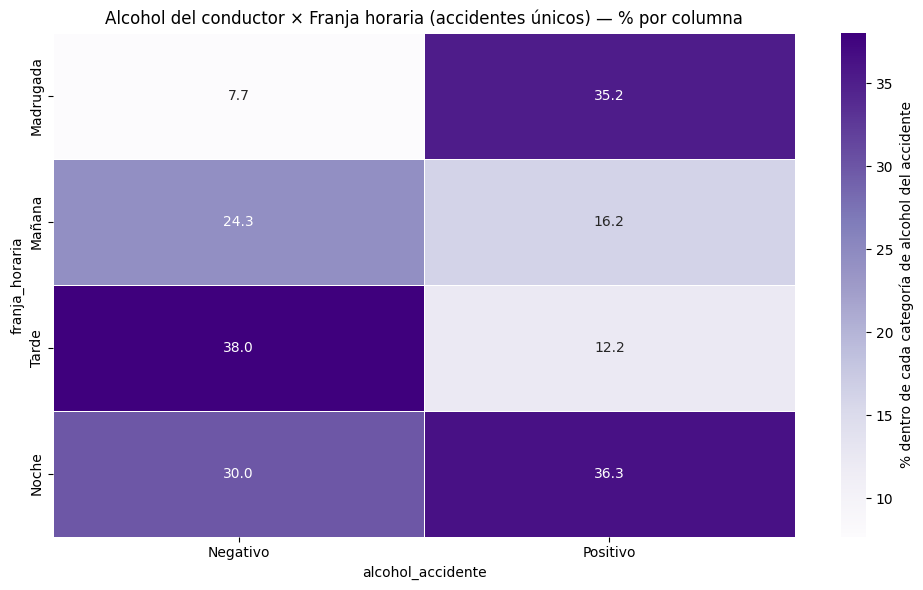


--- Resultados Chi-cuadrado ---
Valor Chi-Cuadrado: 1325.81568935298
P-Value: 3.6837477457408866e-287
Grados de Libertad: 3

Frecuencias Esperadas:
 [[1840.03488147  132.96511853]
 [4582.83396226  331.16603774]
 [6997.35515239  505.64484761]
 [5856.77600387  423.22399613]]


In [63]:
# 1. Copia del dataset 
df = df_accidentes_2024_copy_bivariante.copy()

# 2. Filtrar alcohol registrado (opcional pero recomendable)
df = df[df["positiva_alcohol"] != "No consta"]

# 3. Crear columna hora desde fecha_hora 
df["hora"] = df["fecha_hora"].dt.hour

# 5. Filtrar solo conductores para clasificar el accidente
df_cond = df[df["tipo_persona"].str.lower() == "conductor"]

# 6. Clasificar accidente según alcohol del conductor
alcohol_accidente = df_cond.groupby("num_expediente")["positiva_alcohol"].apply(
    lambda x: "Positivo" if "Positivo" in x.values else "Negativo"
).reset_index().rename(columns={"positiva_alcohol": "alcohol_accidente"})

# 7. Unir clasificación al dataframe original
df = df.merge(alcohol_accidente, on="num_expediente", how="left")

# 8. Tabla absoluta: Alcohol del accidente × Franja (accidentes únicos)
tabla_abs = pd.crosstab(
    df["franja_horaria"],
    df["alcohol_accidente"],
    values=df["num_expediente"],
    aggfunc=lambda x: x.nunique()
).fillna(0)

print("Tabla absoluta:")
print(tabla_abs)

# 9. Convertir a porcentajes por columna
tabla_pct = tabla_abs.div(tabla_abs.sum(axis=0), axis=1) * 100

print("\nTabla en porcentaje (% por columna):")
print(tabla_pct.round(1))

# 10. Heatmap en porcentaje
plt.figure(figsize=(10,6))
sns.heatmap(
    tabla_pct,
    annot=True,
    fmt=".1f",
    cmap="Purples",
    linewidths=.5,
    cbar_kws={"label": "% dentro de cada categoría de alcohol del accidente"}
)

plt.title("Alcohol del conductor × Franja horaria (accidentes únicos) — % por columna")
plt.tight_layout()
plt.show()

# 11. Test Chi-cuadrado (sobre tabla absoluta)
chi2, p, dof, expected = chi2_contingency(tabla_abs)

print("\n--- Resultados Chi-cuadrado ---")
print("Valor Chi-Cuadrado:", chi2)
print("P-Value:", p)
print("Grados de Libertad:", dof)
print("\nFrecuencias Esperadas:\n", expected)


¿Cómo se distribuyen los ACCIDENTES con alcohol positivo y negativo según la franja horaria?

- Los accidentes con alcohol positivo se concentran en Madrugada (35.2%) y Noche (36.3%), lo que sugiere mayor prevalencia de alcohol en horarios nocturnos.

- Los accidentes con alcohol negativo se distribuyen más en Tarde (38%) , reflejando una actividad más diurna y posiblemente laboral.

Conclusión descriptiva:

- Los accidentes con alcohol positivo se concentran en horarios nocturnos (madrugada y noche), mientras que los negativos predominan en franjas diurnas (tarde). Esto sugiere un patrón horario diferenciado según el consumo de alcohol.

¿Existe una asociación estadísticamente significativa entre la franja horaria y el resultado de alcohol del accidente?

- El p‑value es prácticamente cero, lo que indica una asociación extremadamente significativa.

- Esto significa que la franja horaria influye fuertemente en la presencia de alcohol en los conductores implicados en accidentes.

- La distribución observada no se explica por azar.

Conclusión:

- Existe una asociación estadísticamente significativa entre la franja horaria y el resultado de alcohol del accidente (p < 0.000…287). La prevalencia de alcohol positivo en conductores varía significativamente según la hora del día.

## MULTIVARIANTE

In [64]:
df_accidentes_2024_copy_multivariante=df_accidentes_2024_copy_univariante.copy()

#### Analisis multivariante Geografico: Analisis de la coordenada x e y del accidente con distribucion por distrito

¿Qué nos da este estudio? (Interpretación del scatterplot espacial por distrito)
Este gráfico te ofrece un análisis multivariante espacial basado en:

- coordenada_x_utm → posición Este-Oeste
- coordenada_y_utm → posición Norte-Sur
- distrito → categoría que colorea los puntos

En esencia, estás visualizando la distribución geográfica de los accidentes y cómo se reparte por distrito.

1. Te muestra la forma espacial de cada distrito
Cada color representa un distrito. Al ver los puntos distribuidos en el plano UTM, puedes observar:
- La forma aproximada de cada distrito
- Su extensión geográfica
- Si es compacto, alargado, disperso, irregular…

Esto es casi un “mapa conceptual” sin necesidad de un mapa real.

2. Te permite ver la densidad de accidentes por zona
Aunque no es un heatmap, la densidad visual te da pistas:

- Zonas con muchos puntos superpuestos → áreas de alta siniestralidad
- Zonas con pocos puntos → áreas más seguras o con menos tráfico

Vamos a responder a la siguiente pregunta:
- ¿Qué distritos presentan mayor densidad de accidentes por km² en Madrid?




C:\Users\César\AppData\Local\Temp\ipykernel_4408\3991779633.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gdf_web.groupby("distrito")["geometry"]
C:\Users\César\AppData\Local\Temp\ipykernel_4408\3991779633.py:19: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  .apply(lambda x: x.unary_union.centroid)


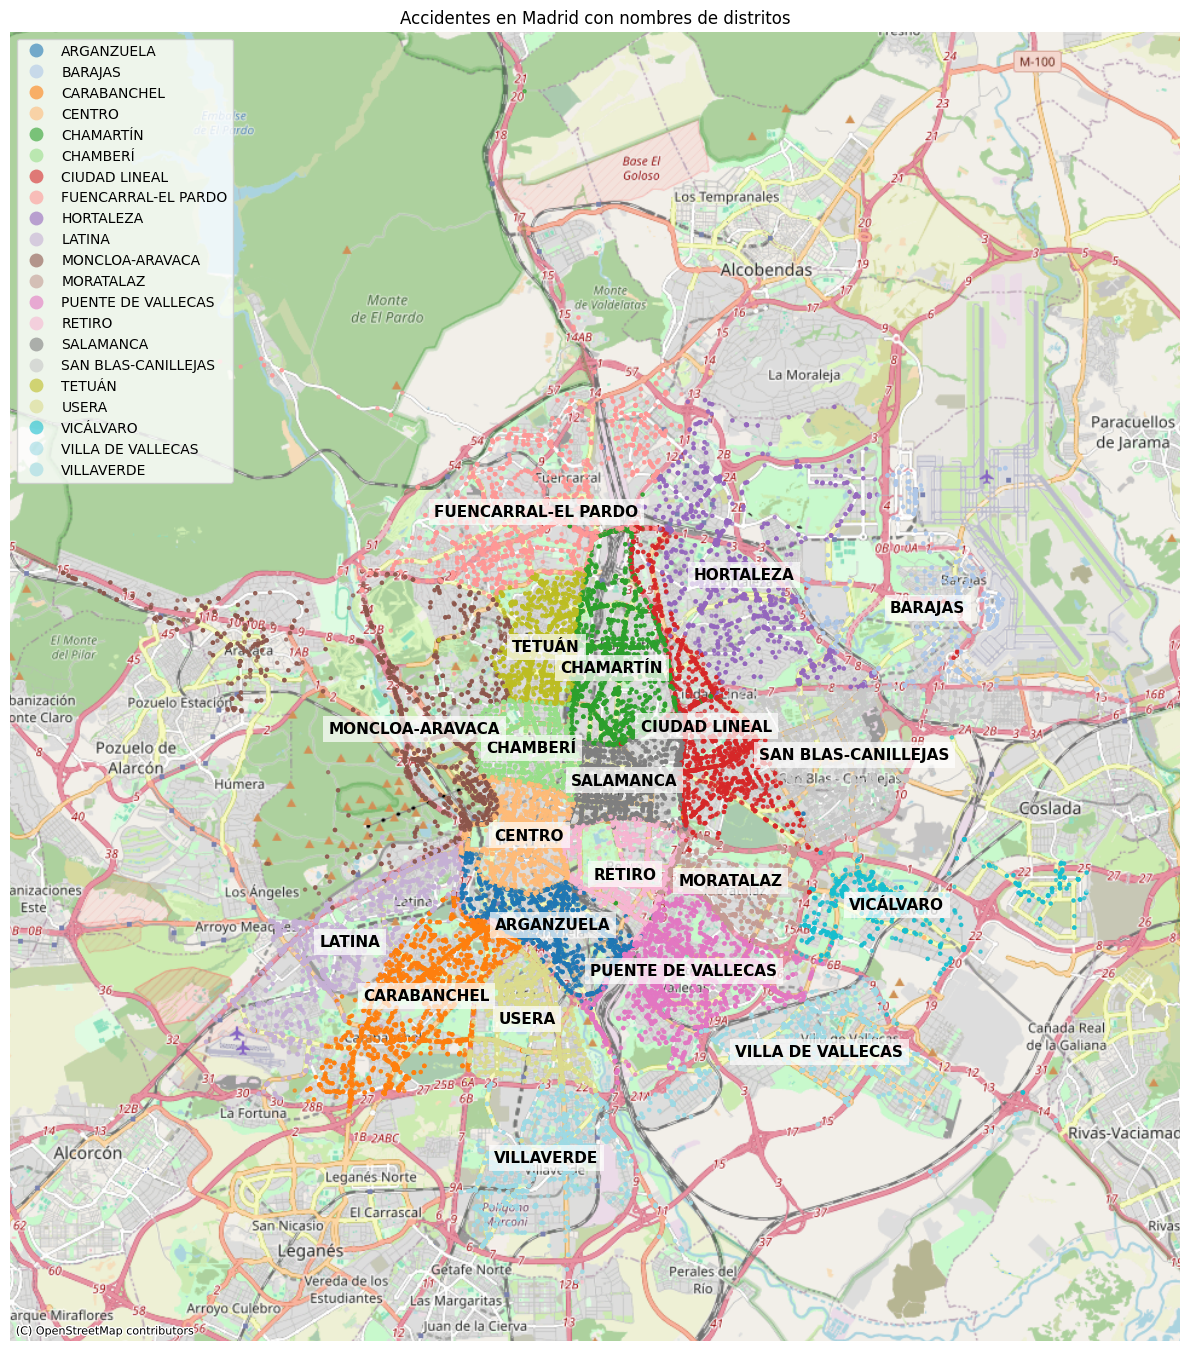

In [67]:
# 1. Convertir tu dataframe a GeoDataFrame

df = df_accidentes_2024_copy_multivariante.copy()

gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["coordenada_x_utm"], df["coordenada_y_utm"]),
    crs="EPSG:25830"
)

# 2. Reproyectar a Web Mercator

gdf_web = gdf.to_crs(epsg=3857)

# 3. Calcular el centro aproximado de cada distrito

centros = (
    gdf_web.groupby("distrito")["geometry"]
    .apply(lambda x: x.unary_union.centroid)
    .reset_index()
)

# 4. Crear el mapa con colores por distrito

fig, ax = plt.subplots(figsize=(12, 16))

gdf_web.plot(
    ax=ax,
    column="distrito",
    markersize=5,
    alpha=0.6,
    legend=True,
    categorical=True,
    cmap="tab20"
)

# 5. Añadir mapa base

ctx.add_basemap(
    ax,
    source=ctx.providers.OpenStreetMap.Mapnik,
    zoom=12
)

# 6. Añadir los nombres de los distritos

for _, row in centros.iterrows():
    ax.text(
        row.geometry.x,
        row.geometry.y,
        row["distrito"],
        fontsize=11,
        fontweight="bold",
        color="black",
        ha="center",
        va="center",
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="none")
    )

# 7. Ajustes finales

ax.set_title("Accidentes en Madrid con nombres de distritos")
ax.set_axis_off()

plt.tight_layout()
plt.show()


In [68]:
# 1. Superficie oficial de los 21 distritos de Madrid (km²)
superficie_distritos = {
    "CENTRO": 5.23,
    "ARGANZUELA": 6.46,
    "RETIRO": 5.47,
    "SALAMANCA": 5.38,
    "CHAMARTÍN": 5.99,
    "TETUÁN": 5.38,
    "CHAMBERÍ": 4.69,
    "FUENCARRAL-EL PARDO": 237.81,
    "MONCLOA-ARAVACA": 46.65,
    "LATINA": 25.41,
    "CARABANCHEL": 14.76,
    "USERA": 7.75,
    "PUENTE DE VALLECAS": 14.89,
    "MORATALAZ": 6.34,
    "CIUDAD LINEAL": 11.43,
    "HORTALEZA": 27.41,
    "VILLAVERDE": 20.29,
    "VILLA DE VALLECAS": 48.34,
    "VICÁLVARO": 14.40,
    "SAN BLAS-CANILLEJAS": 22.36,
    "BARAJAS": 41.94
}

df_superficie = pd.DataFrame(
    list(superficie_distritos.items()),
    columns=["distrito", "area_km2"]
)

# 2. Copia del dataframe original
df_acc = df_accidentes_2024_copy_multivariante.copy()

# 3. Contar EXPEDIENTES ÚNICOS por distrito
acc_por_distrito = (
    df_acc.groupby("distrito")["num_expediente"]
    .nunique()
    .reset_index(name="n_accidentes_unicos")
)

# 4. Unir accidentes únicos + superficie
df_densidad = acc_por_distrito.merge(df_superficie, on="distrito", how="left")

# 5. Calcular densidad REAL
df_densidad["densidad_accidentes_km2"] = (
    df_densidad["n_accidentes_unicos"] / df_densidad["area_km2"]
)

# 6. Ordenar de mayor a menor densidad
df_densidad = df_densidad.sort_values(
    "densidad_accidentes_km2", ascending=False
)

df_densidad


C:\Users\César\AppData\Local\Temp\ipykernel_4408\1193755618.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_acc.groupby("distrito")["num_expediente"]


distrito  n_accidentes_unicos  area_km2  \
14            SALAMANCA                 1393      5.38   
3                CENTRO                 1327      5.23   
4             CHAMARTÍN                 1470      5.99   
5              CHAMBERÍ                  954      4.69   
16               TETUÁN                 1014      5.38   
13               RETIRO                 1010      5.47   
0            ARGANZUELA                 1088      6.46   
6         CIUDAD LINEAL                 1244     11.43   
17                USERA                  818      7.75   
12   PUENTE DE VALLECAS                 1530     14.89   
2           CARABANCHEL                 1440     14.76   
11            MORATALAZ                  574      6.34   
15  SAN BLAS-CANILLEJAS                  949     22.36   
9                LATINA                  965     25.41   
20           VILLAVERDE                  704     20.29   
8             HORTALEZA                  769     27.41   
18            VICÁLVARO                  388     14.40   
10      MONCLOA-ARAVACA                 1050     46.65   
19    VILLA DE VALLECAS                  517     48.34   
1               BARAJAS                  394     41.94   
7   FUENCARRAL-EL PARDO                 1097    237.81   

    densidad_accidentes_km2  
14               258.921933  
3                253.728489  
4                245.409015  
5                203.411514  
16               188.475836  
13               184.643510  
0                168.421053  
6                108.836395  
17               105.548387  
12               102.753526  
2                 97.560976  
11                90.536278  
15                42.441860  
9                 37.977174  
20                34.696895  
8                 28.055454  
18                26.944444  
10                22.508039  
19                10.695077  
1                  9.394373  
7                  4.612926

¿Qué distritos presentan mayor densidad de accidentes por km² en Madrid?

En el Scatterplot muestra zonas con alta densidad visual (muchos puntos superpuestos) y el calculo de densidad por km2 confirma si esa concetracion es relativa al tamaño del distrito y efectivamente vemos que el top 5 en funcion a su tamaño se concentran de la siguiente forma:
- Distrito de Salamanca
- Distrito de Centro
- Distrito de Chamartin
- Distrito de Chamberi
- Distrito de Tetuan


#### Analisis multivariante de lesividad: Distribución de la lesividad de las personas implicadas según distrito y tipo de accidente

En este estudio vamos hacernos la siguiente pregunta:
- ¿Cómo varía el grado de lesividad en función del distrito y del tipo de accidente?

C:\Users\César\AppData\Local\Temp\ipykernel_4408\1948117591.py:28: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  .pivot_table(
C:\Users\César\AppData\Local\Temp\ipykernel_4408\1948117591.py:28: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  .pivot_table(
C:\Users\César\AppData\Local\Temp\ipykernel_4408\1948117591.py:28: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  .pivot_table(
C:\Users\César\AppData\Local\Temp\ipykernel_4408\1948117591.py:28: FutureWarning: The default value of observed=False is deprec

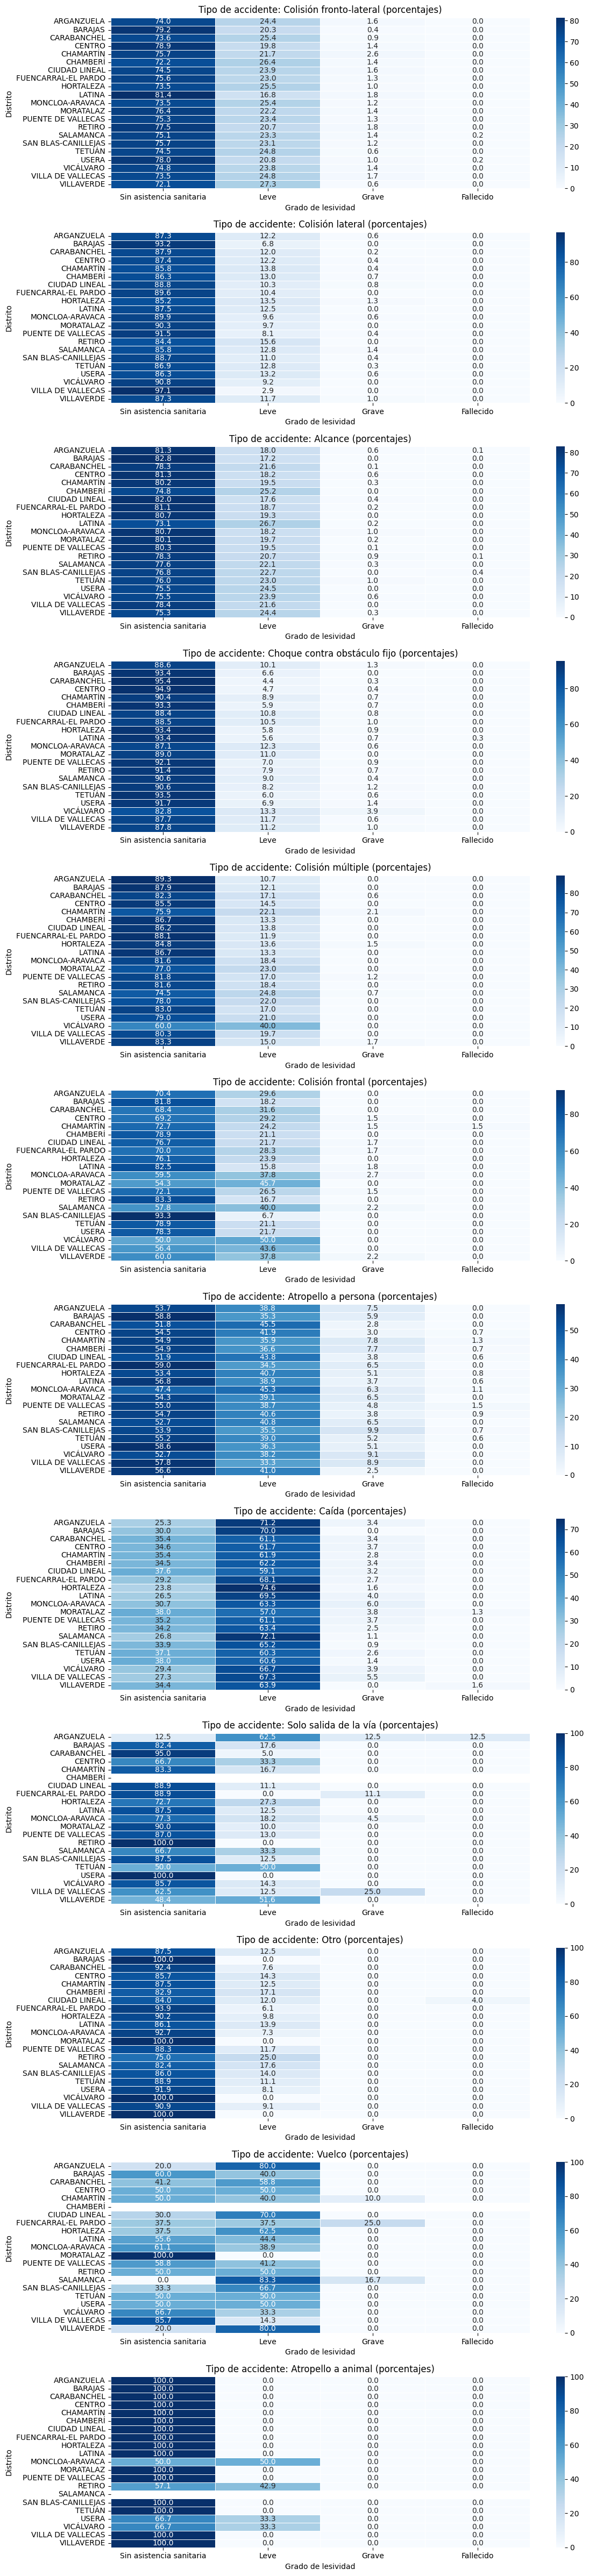

In [69]:
# Filtrar registros válidos
df_filtrado = df_accidentes_2024_copy_multivariante[
    (df_accidentes_2024_copy_multivariante["grado_lesividad"].str.lower() != "no consta") &
    (df_accidentes_2024_copy_multivariante["tipo_accidente"].str.lower() != "no consta")
]

# Lista de tipos de accidente
tipos = df_filtrado["tipo_accidente"].unique()

# Crear figura
fig, axes = plt.subplots(
    nrows=len(tipos),
    ncols=1,
    figsize=(12, 4 * len(tipos)),
    sharex=False
)

if len(tipos) == 1:
    axes = [axes]

orden_lesividad = ["Sin asistencia sanitaria", "Leve", "Grave", "Fallecido"]

for ax, tipo in zip(axes, tipos):

    # Tabla de valores absolutos
    tabla_abs = (
        df_filtrado[df_filtrado["tipo_accidente"] == tipo]
        .pivot_table(
            index="distrito",
            columns="grado_lesividad",
            values="num_expediente",
            aggfunc="count",
            fill_value=0
        )
        .reindex(columns=orden_lesividad, fill_value=0)
    )

    # Convertir a porcentajes por fila (distrito)
    tabla_pct = tabla_abs.div(tabla_abs.sum(axis=1), axis=0) * 100

    sns.heatmap(
        tabla_pct,
        cmap="Blues",
        annot=True,
        fmt=".1f",   # porcentaje con 1 decimal
        linewidths=.5,
        ax=ax
    )

    ax.set_title(f"Tipo de accidente: {tipo} (porcentajes)")
    ax.set_xlabel("Grado de lesividad")
    ax.set_ylabel("Distrito")
    ax.set_xticklabels(orden_lesividad, rotation=0)

    # Centrar verticalmente los nombres de los distritos
    ax.set_yticks([i + 0.5 for i in range(len(tabla_pct.index))])
    ax.set_yticklabels(tabla_pct.index, rotation=0, va='center')
    ax.tick_params(axis='y', labelsize=10)

# Aumentar margen izquierdo si los nombres son largos
plt.subplots_adjust(left=0.30)

plt.tight_layout()
plt.show()



¿Cómo varía el grado de lesividad en función del distrito y del tipo de accidente?
- La mayoría de los accidentes son leves o sin asistencia sanitaria
- En casi todos los tipos de accidente, los porcentajes de “Sin asistencia sanitaria” y “Leve” superan el 90% en muchos distritos. Esto indica que, aunque los accidentes son frecuentes, la mayoría no generan lesiones graves.

- En los heatmaps de atropello a persona y colisión frontal, aparecen porcentajes más altos en las categorías “Grave” y “Fallecido”.

- Los distritos periféricos presentan más gravedad en accidentes de salida de vía 
En tipos como “Solo salida de la vía”, distritos como Fuencarral-El Pardo,  Villa de Vallecas y Arganzuela muestran mayor proporción de heridos graves.

- Algunos tipos de accidente tienen perfiles de lesividad casi nulos. En “Atropello a animal”, la mayoría de los distritos tienen 100% en “Sin asistencia sanitaria”. Esto indica que no suelen implicar lesiones humanas.

#### Análisis multivariante de lesividad: según sexo y rango de edad

En este estudio vamos hacernos la siguiente pregunta:
- ¿Cómo varía el grado de lesividad en función del sexo y la edad de las personas implicadas en accidentes de tráfico?

C:\Users\César\AppData\Local\Temp\ipykernel_4408\4164441281.py:51: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  .pivot_table(
C:\Users\César\AppData\Local\Temp\ipykernel_4408\4164441281.py:51: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  .pivot_table(
C:\Users\César\AppData\Local\Temp\ipykernel_4408\4164441281.py:51: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  .pivot_table(
C:\Users\César\AppData\Local\Temp\ipykernel_4408\4164441281.py:51: FutureWarning: The default value of observed=False is deprec

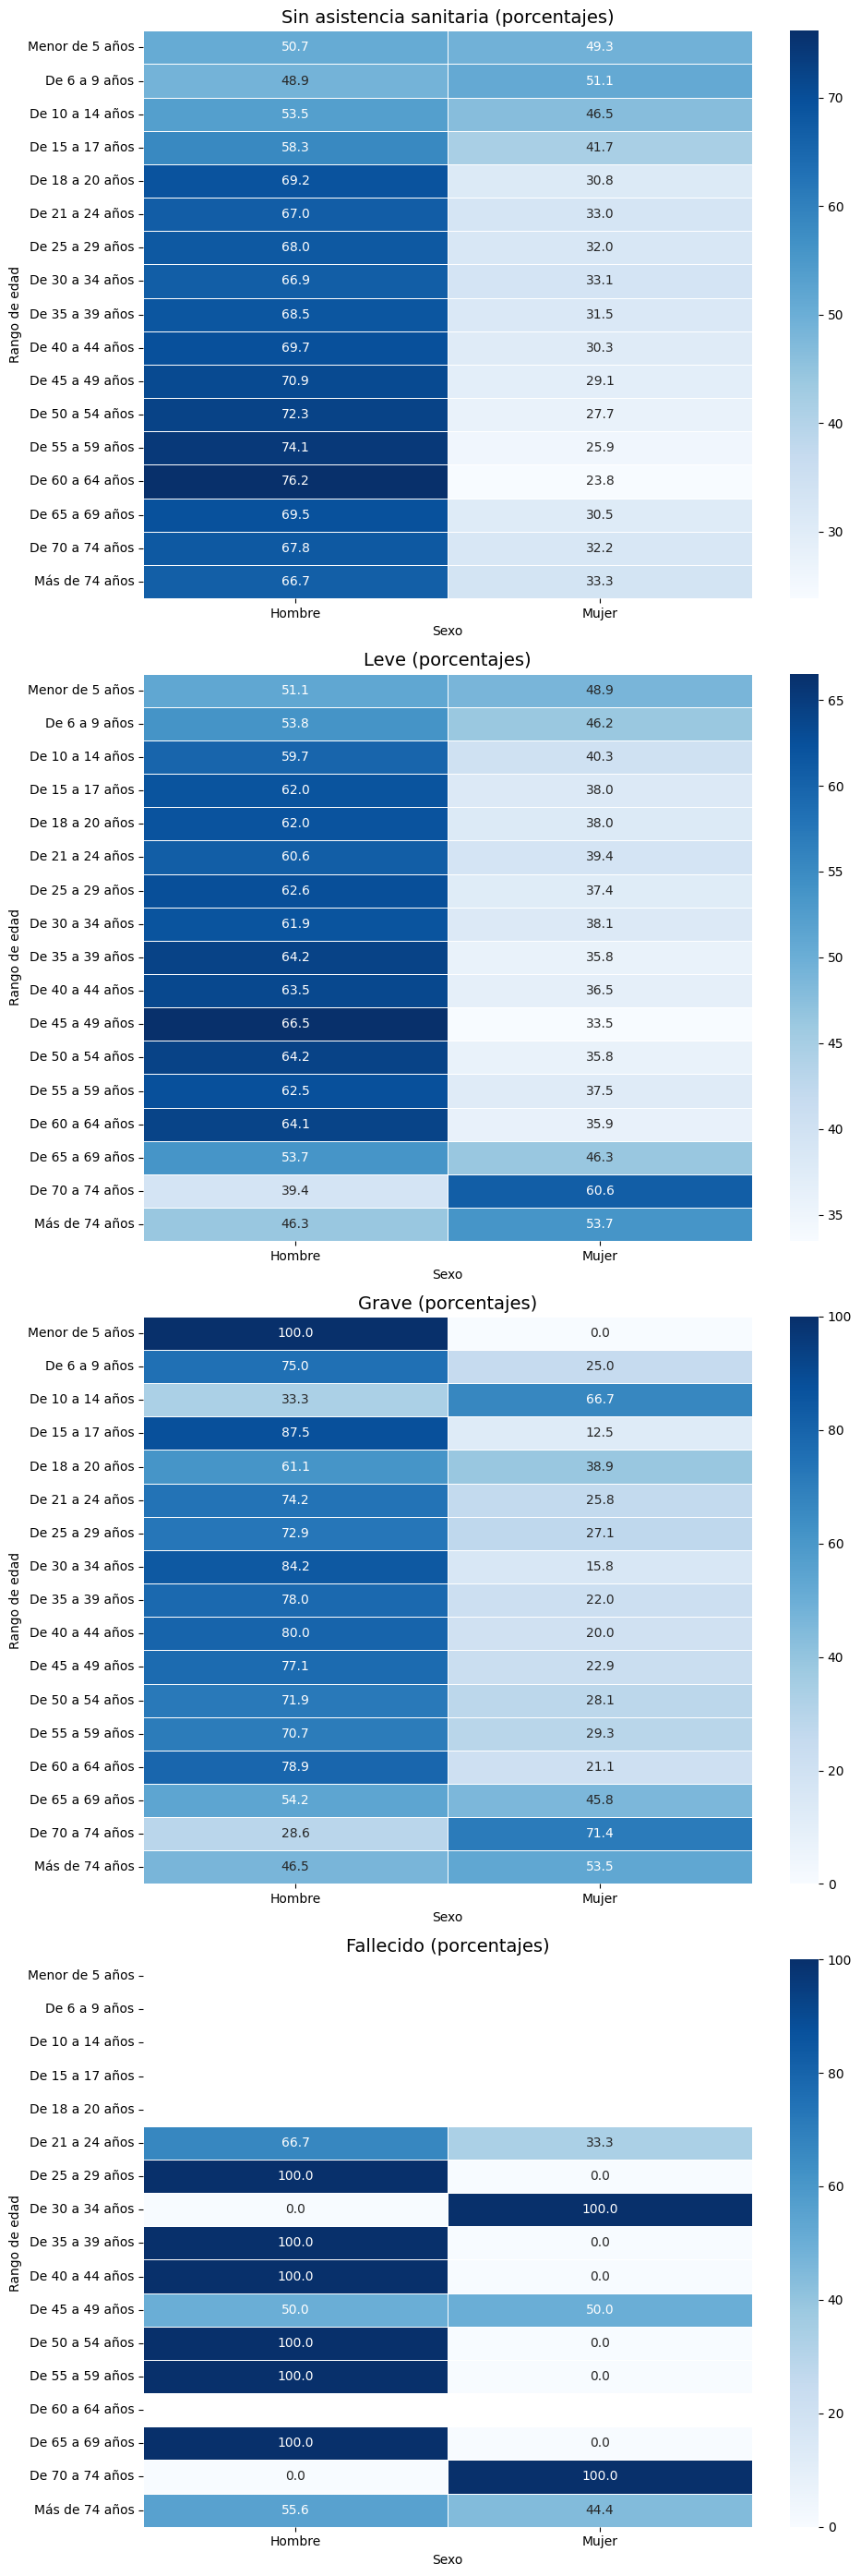

In [70]:
# 0. Limpieza robusta de rango_edaD
df = df_accidentes_2024_copy_multivariante.copy()

df["rango_edad"] = df["rango_edad"].astype(str).str.strip()

valores_malos = ["Desconocido", "desconocido", "DESCONOCIDO", "", " ", None]
df.loc[df["rango_edad"].isin(valores_malos), "rango_edad"] = np.nan


# 1. Definir orden correcto de edades

orden_edad = [
    "Menor de 5 años", "De 6 a 9 años", "De 10 a 14 años", "De 15 a 17 años",
    "De 18 a 20 años", "De 21 a 24 años", "De 25 a 29 años", "De 30 a 34 años",
    "De 35 a 39 años", "De 40 a 44 años", "De 45 a 49 años", "De 50 a 54 años",
    "De 55 a 59 años", "De 60 a 64 años", "De 65 a 69 años", "De 70 a 74 años",
    "Más de 74 años"
]

df["rango_edad"] = pd.Categorical(df["rango_edad"], categories=orden_edad, ordered=True)


# 2. Filtrado final

df_lesividad = df[
    (df["grado_lesividad"].str.lower() != "no consta") &
    (df["sexo"].str.lower() != "desconocido") &
    (df["rango_edad"].notna())
]

orden_lesividad = ["Sin asistencia sanitaria", "Leve", "Grave", "Fallecido"]
orden_sexo = ["Hombre", "Mujer"]


# 3. Crear figura con 4 heatmaps (porcentajes)

fig, axes = plt.subplots(
    nrows=4,
    ncols=1,
    figsize=(10, 28),
    sharex=False
)

for ax, les in zip(axes, orden_lesividad):

    df_sub = df_lesividad[df_lesividad["grado_lesividad"] == les]

    # Tabla de conteos absolutos
    tabla_abs = (
        df_sub
        .pivot_table(
            index="rango_edad",
            columns="sexo",
            values="num_expediente",
            aggfunc="count",
            fill_value=0
        )
        .reindex(columns=orden_sexo, fill_value=0)
        .sort_index()
    )

    # Convertir a porcentajes por fila (rango de edad)
    tabla_pct = tabla_abs.div(tabla_abs.sum(axis=1), axis=0) * 100

    sns.heatmap(
        tabla_pct,
        cmap="Blues",
        annot=True,
        fmt=".1f",  # porcentaje con 1 decimal
        linewidths=.5,
        ax=ax
    )

    ax.set_title(f"{les} (porcentajes)", fontsize=14)
    ax.set_xlabel("Sexo")
    ax.set_ylabel("Rango de edad")

    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(orden_sexo, ha='center')

plt.tight_layout()
plt.show()


¿Cómo varía el grado de lesividad en función del sexo y la edad de las personas implicadas en accidentes de tráfico?
Sin asistencia sanitaria:
- prredominio masculino en todas las edades a partir de los 15 años.
- A partir de los 50 años, los hombres representan más del 70% de los casos sin asistencia.
- Esto sugiere que los hombres tienden a implicarse en accidentes que no requieren atención médica, posiblemente por mayor exposición vial o menor percepción de riesgo.

Lesiones leves:
- También predominan los hombres en casi todos los grupos, especialmente entre los 35 y 59 años (más del 64%).
- Sin embargo, a partir de los 70 años, el patrón se invierte: las mujeres superan el 60% en el grupo 70–74 y el 53.7% en mayores de 74.
- Esto puede reflejar una mayor vulnerabilidad femenina en edades avanzadas o una mayor propensión a reportar lesiones leves.

Lesiones graves:
- Fuerte predominio masculino en casi todos los grupos: entre 70% y 87% en edades adultas.

Excepciones notables:

- De 10 a 14 años: mayoría femenina (66.7%)
- De 70 a 74 años: mayoría femenina (71.4%)
- Más de 74 años: mayoría femenina (53.5%)

Esto sugiere que las mujeres mayores tienen mayor probabilidad de sufrir lesiones graves en caso de accidente.

Aunque los datos son escasos, se observan patrones extremos:

- En edades medias (25 a 59 años), los fallecidos son casi exclusivamente hombres (100% en varios grupos).
- En mayores de 74 años, el patrón se equilibra (55.6% hombres, 44.4% mujeres).
- En el grupo 70–74 años, los fallecidos son exclusivamente mujeres (100%).